In [1]:
## trying on docker. Working from base python 3 kernel 

import fwiVis.fwiVis as fv

import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
import zarr #Didn't build into the env, needed to run "mamba install -c conda-forge zarr" took awhile, and was killed w/out mamba. Wait, it actually only worked with pip? 
import rasterio
from rasterio.plot import plotting_extent
import datetime as dt
from datetime import timedelta, date
#import imageio ## Need a diff script for image porcessing. 
#conda install -c conda-forge netCDF4 #maybe pip install? May have already been satisfied
# pip install h5netcdf

In [2]:
#s3.ls("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM")



#url = "s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM"
#with rasterio.open(url) as src:
#    print(scr.profile)

#test = rasterio.open("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS.201908030000.d01.cog")


#root_moist = xr.open_dataset("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS.200207030000.d01.cog")

In [3]:
#test.height

In [4]:
#band1 = test.read(1)

In [95]:
#band1

In [96]:
#band1.plot

In [5]:
## make a seres of string to read in LIS data for correct day 

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2021, 8, 1)
end_dt = date(2021, 9, 30)
dates = []
for dt in daterange(start_dt, end_dt):
    date = dt.strftime("%Y%m%d")
    #print(date)
    dates.append(date)

In [98]:
#def daterange(date1, date2):
#    for n in range(int ((date2 - date1).days)+1):
#        yield date1 + timedelta(n)
#start_dt_l = date(2021, 8, 7)
#end_dt_l = date(2021, 9, 30)
#dates_long = []
#for dt in daterange(start_dt_l, end_dt_l):
#    date_l = dt.strftime("%Y%m%d")
#    #print(date)
#    dates_long.append(date_l)

In [99]:
#dates 

In [100]:
root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS.202108140000.d01.cog")

/tmp/ipykernel_28903/3090770367.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS.202108140000.d01.cog")


In [101]:

root_extent = plotting_extent(root_moist[0], root_moist.rio.transform())
root_moist

<xarray.DataArray (band: 1, y: 2110, x: 1560)>
[3291600 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 52.99 52.98 52.97 52.96 ... 31.94 31.93 31.92 31.91
  * x        (x) float64 -125.0 -125.0 -125.0 -125.0 ... -109.4 -109.4 -109.4
Attributes:
    transform:           (0.009994664762122057, 0.0, -124.99500274658203, 0.0...
    crs:                 +init=epsg:4326
    res:                 (0.009994664762122057, 0.009994664762122057)
    is_tiled:            1
    nodatavals:          (0.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

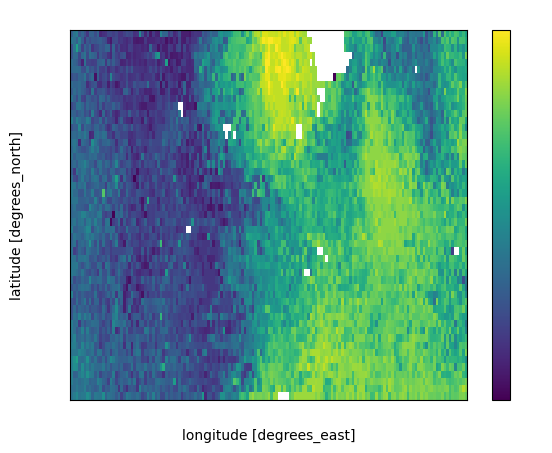

In [102]:
min_lat = 38.5
max_lat = 39
min_lon = -121
max_lon = -119.50

subset = root_moist.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
subset.plot()

In [103]:
## Reading in IMERGE

#imerge = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr/", engine = "zarr")

#fwi_frocasts = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/FWI.GEOS-5.zarr", engine = "zarr")
#fwi_frocasts.plot.scatter()
#?xr.open_dataset

#imerge.

In [104]:
#imerge.plot.scatter(x ="GPM.LATE.v5_BUI", y ="GPM.LATE.v5_FWI" )

In [105]:
s3.ls("s3://veda-data-store-staging/EIS/zarr/")

['veda-data-store-staging/EIS/zarr/.zgroup',
 'veda-data-store-staging/EIS/zarr/FWI.GEOS-5.zarr',
 'veda-data-store-staging/EIS/zarr/FWI_GPM_LATE_v5_Daily.zarr',
 'veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr',
 'veda-data-store-staging/EIS/zarr/OCO2_GEOS_L3CO2_day.zarr',
 'veda-data-store-staging/EIS/zarr/SPL3SMP.zarr']

In [6]:
## Work up for caldor fire, but could switch to an OR fire. 

# Read in Caldor fire 
## Load up helper objects

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map, path_s3 ="veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
stations
st_dict = stations[['Lat', 'Lon']].to_dict('records')

#

foi = [{"Lat":38.586 , 
        "Lon":-120.537833 
    
}]
foi = pd.DataFrame(foi)
st_cls = fv.closest(st_dict, foi)
st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)

#gdf = gdf.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
#gdf['t'] = gdf['t'].astype('datetime64[ns]')

#full_fr = fv.fr_st_merge(gdf, st, sub = True)
#full_fr
st

## Subset to relvatn dates (from CAL FIRE)

# Start 08/14/21 6:54 PM,  End 10/21/21 8:18AM

st = st[st.time > "2021-08-01 12:00:00"]

st = st[st.time < "2021-09-30 12:00:00"]

st

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/
The closest station is 23.48698806042275 km away.


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:127: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:127: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


YYYY  MM  DD  HH  TEMP_C  RH_PERC   VPD_HPA  WDSPD_KPH  PREC_MM  \
40173  2021   8   1  13  34.055   15.089    45.293    9.50480      0.0   
40174  2021   8   1  14  33.875   14.286    45.269   10.92900      0.0   
40175  2021   8   1  15  34.001   15.283    45.070   10.41200      0.0   
40176  2021   8   1  16  34.052   16.461    44.564    8.33850      0.0   
40177  2021   8   1  17  33.086   17.260    41.819    6.23230      0.0   
...     ...  ..  ..  ..     ...      ...       ...        ...      ...   
41607  2021   9  30   7  18.094   15.111    17.639    7.38200      0.0   
41608  2021   9  30   8  19.075   19.237    17.847    0.26967      0.0   
41609  2021   9  30   9  21.913   15.766    22.165    9.72970      0.0   
41610  2021   9  30  10  22.990   15.830    23.643    1.46300      0.0   
41611  2021   9  30  11  23.024   14.822    23.978   11.71100      0.0   

       SNOWD_M  ...  BUI     ISI     FWI  OBSMINUTEDIFFTEMP OBSMINUTEDIFFRH  \
40173      0.0  ...  NaN  16.917  55.711                5.0             5.0   
40174      0.0  ...  NaN  18.473  58.808                5.0             5.0   
40175      0.0  ...  NaN  18.087  58.051                5.0             5.0   
40176      0.0  ...  NaN  16.293  54.431                5.0             5.0   
40177      0.0  ...  NaN  14.653  50.954                5.0             5.0   
...        ...  ...  ...     ...     ...                ...             ...   
41607      0.0  ...  NaN  9.6864  34.938                5.0             5.0   
41608      0.0  ...  NaN  6.7952  27.526                5.0             5.0   
41609      0.0  ...  NaN   11.35   38.76                5.0             5.0   
41610      0.0  ...  NaN  7.6956   29.96                5.0             5.0   
41611      0.0  ...  NaN  13.393  43.123                5.0             5.0   

      OBSMINUTEDIFFWDSPD  OBSMINUTEDIFFPREC  OBSMINUTEDIFFSNOW  HH_format  \
40173                5.0                  5                NaN         13   
40174                5.0                  5                NaN         14   
40175                5.0                  5                NaN         15   
40176                5.0                  5                NaN         16   
40177                5.0                  5                NaN         17   
...                  ...                ...                ...        ...   
41607                5.0                  5                NaN         07   
41608                5.0                  5                NaN         08   
41609                5.0                  5                NaN         09   
41610                5.0                  5                NaN         10   
41611                5.0                  5                NaN         11   

                     time  
40173 2021-08-01 13:00:00  
40174 2021-08-01 14:00:00  
40175 2021-08-01 15:00:00  
40176 2021-08-01 16:00:00  
40177 2021-08-01 17:00:00  
...                   ...  
41607 2021-09-30 07:00:00  
41608 2021-09-30 08:00:00  
41609 2021-09-30 09:00:00  
41610 2021-09-30 10:00:00  
41611 2021-09-30 11:00:00  

[1439 rows x 23 columns]

In [107]:
## Generate a look at caulder for 08/14/2021

fireID = '0'
gdf = fv.load_large_fire(fireID, year = "2021", path_region="Caldor")
gdf['timediff'] = gdf.t - pd.to_datetime("2021-08-14 18:00:00")
gdf['timediff'] = gdf.timediff.astype("int")
#gdf["t"] = gdf["t"].astype("str")
gdf.t.astype("datetime64[ns]")
gdf = gdf.sort_values(by = ["t"])
#gdf.set_index("t")


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:372: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:373: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


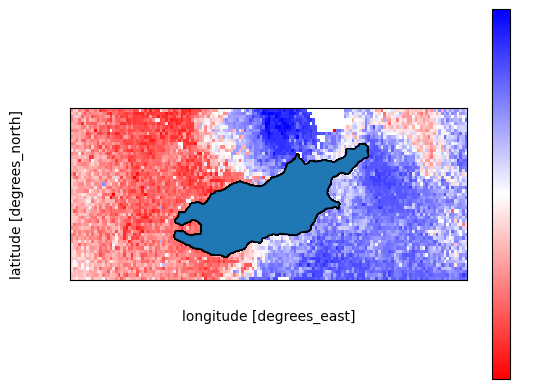

In [108]:
#gdf.explore(column='timediff', #  cmap='RdBu_r', 
#                  style_kwds={'fillOpacity':0})

d0 = 0
df = 135


f, ax = plt.subplots()
subset.plot(cmap = "bwr_r") 
#root_moist.plot()
gdf[d0:df].plot(ax=ax,  edgecolor='black') #facecolor="None"

plt.show()

In [109]:
# Plot each day in loop 
gdf.t.astype("datetime64[ns]")
gdf['hour'] = gdf.t.dt.hour
gdf_d = gdf#gdf[gdf.hour == '12:00:00'] ## only daytime perimeters so daily timestep

In [110]:
root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[0] +"0000.d01.cog")
subset = root_moist.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
#extent = subset
#?plotting_extent
type(subset)

/tmp/ipykernel_28903/1737176777.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[0] +"0000.d01.cog")


RasterioIOError: Operation timed out after 1001 milliseconds with 0 bytes received

In [ ]:
min_lat = 38.5
max_lat = 39
min_lon = -121
max_lon = -119.50

d0 = 0
len_days = len(dates)
for i in range(1, len_days):
    print(i)
    root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")
    subset = root_moist.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    f, ax = plt.subplots()
    subset.plot(ax = ax, cmap = "bwr_r", vmin = 0, vmax = 1, label = "Soil Water Percentile")
    #ax.set_xlable("Longitude")
    #ax.xlable("Longitude")
    #sub_plot = ax.plot(subset, cmap = "bwr_r", vmin= 1, vmax = 1)
    if(i <= 6):

        gdf[d0:i].plot(ax=ax, facecolor="none", edgecolor='none')
    if(i > 6):
        index = i - 6
        gdf[d0:index].plot(ax=ax, facecolor="yellow", edgecolor='black') #facecolor="None"
    #ax.xlable("Longitude")
    ax.set_ylabel("Latitude", color = "white")
    ax.set_xlabel("Longitude", color = "white")
    ax.set_title("Soil Water Percentiles", color = "white")
    #ax.spines["bottom"].set_color('white')
    #ax.spines["top"].set_color('white')
    #ax.spines["left"].set_color('white')
    #ax.spines["right"].set_color('white')
    #ax.xaxis.label.set_color('white')
    #ax.tick_params(colors='white')
    #plt.savefig(fname = (""+ m + "_vs_" + f+".pdf"))
    params = {"text.color" : "white",
          "xtick.color" : "white",
          "ytick.color" : "white"}
    plt.rcParams.update(params)
    if(i < 10):
        i_write = "0" + str(i)
    else:
        i_write = str(i)
    #plt.savefig('/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/LIS_visualize/SW_fig/Caldor_Soil_moisture_raster_' + i_write + '.png', transparent=True, dpi = 450)
    plt.show()

In [ ]:
## take the "final" perimeter average of soil moisture
#gdf.loc[48].geometry
final = gdf.loc[0:len_days]
#final.geometry


#root_moist_clip = rio.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS.202108140000.d01.cog", 
#                                   masked=True).rio.clip(final.geometry)


In [111]:
### Timeseries plot of Soil Moisture

## Dummy axis variables

date_df = pd.DataFrame()
date_df["dates_fl"] = dates

#date_df["dates_fl"] = dates_long
date_df["dates_clean"] = date_df["dates_fl"].astype("datetime64[ns]")
date_df["dates_clean"] = date_df["dates_clean"].astype("str") + " 12:00:00"
date_df["dates_clean"] = date_df["dates_clean"].astype("datetime64[ns]")

date_df["dates_clean"]
date_df["mean_sw"] = np.nan

#date_df[date_df.dates_fl == dates[4]].mean_sw = np.nan

In [112]:
#st.time

In [113]:
## Working Soil Water animation through time with fire weather

#d0 = 0
#len_days = len(dates)
#date_df["mean_sw"] = np.nan
#for i in range(0, len_days):
#    root_moist_clip = rio.open_rasterio(("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] + "0000.d01.cog"), masked=True).rio.clip(final.geometry) 
#    date_df.mean_sw[date_df.dates_fl == dates[i]] = float(root_moist_clip.mean())
#    #print(date_df.mean_sw[date_df.dates_fl == dates[i]])
#    #print(date_df)
#    f, ax = plt.subplots()
#    ax.scatter(y = date_df.mean_sw, x = date_df.dates_clean, c  = date_df.mean_sw, cmap  = "bwr_r", vmin = 0, vmax = 1)
#    ax.tick_params(axis='x', labelrotation = 90)
#    plt.ylim([0, 1])
#    plt.xlim(min(date_df.dates_clean), max(date_df.dates_clean))
#    ax2=ax.twinx()
#    ax2.plot(st.time, st.FWI, color="orange",  alpha=0.3)
#    ax2.set_ylabel("FWI",color="orange")
#    plt.show()

In [114]:
d0 = 0
len_days = len(dates)
date_df["mean_sw"] = np.nan
for i in range(0, len_days):
    root_moist_clip = rio.open_rasterio(("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] + "0000.d01.cog"), masked=True).rio.clip(final.geometry) 
    date_df.mean_sw[date_df.dates_fl == dates[i]] = float(root_moist_clip.mean())
    #print(date_df.mean_sw[date_df.dates_fl == dates[i]])
    #print(date_df)

/tmp/ipykernel_28903/2910950312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df.mean_sw[date_df.dates_fl == dates[i]] = float(root_moist_clip.mean())
/tmp/ipykernel_28903/2910950312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df.mean_sw[date_df.dates_fl == dates[i]] = float(root_moist_clip.mean())
/tmp/ipykernel_28903/2910950312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df.mean_sw[date_df.dates_f

In [115]:
#gdf

In [116]:
merge_date = date_df
merge_date = merge_date.rename(columns={"dates_clean": "t"})
#merge_date.rename
#merge_date
st = st.rename(columns = {"time": "t"})
#st

In [117]:


full_fr = pd.merge(gdf,st, on = "t", how = "outer")
#full_fr.sort_values("t")

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


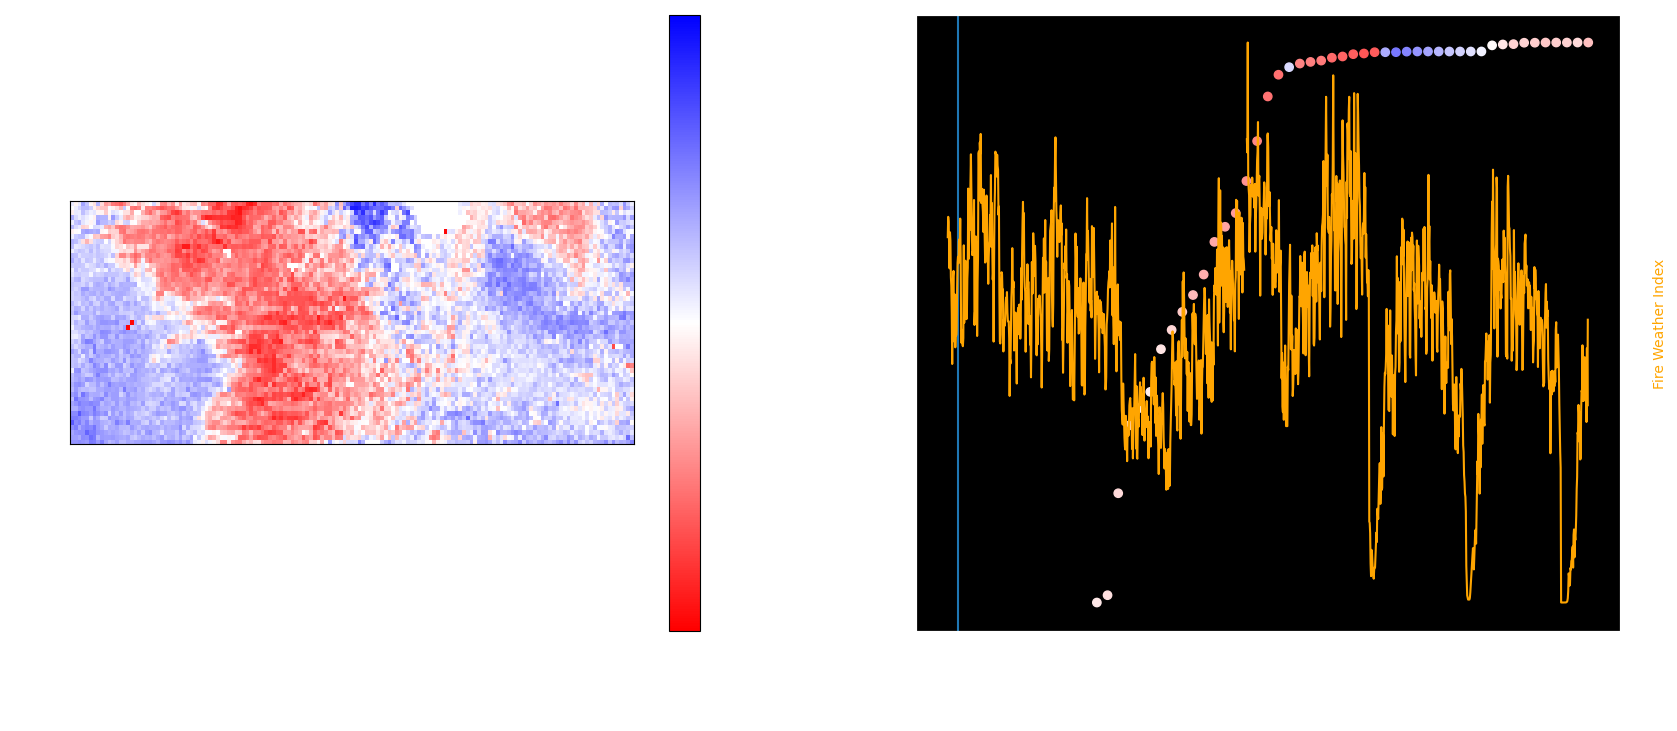

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


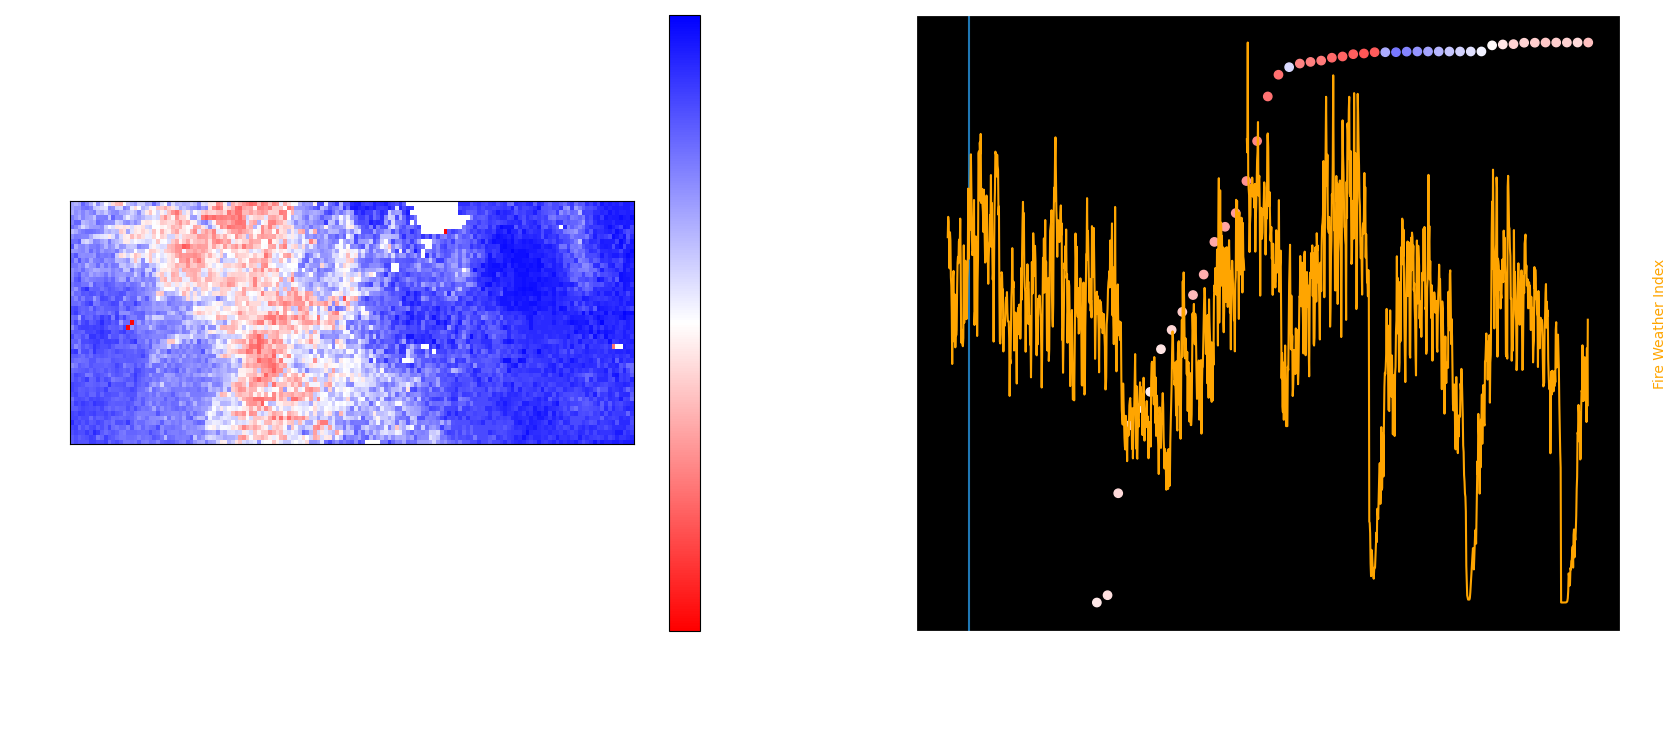

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


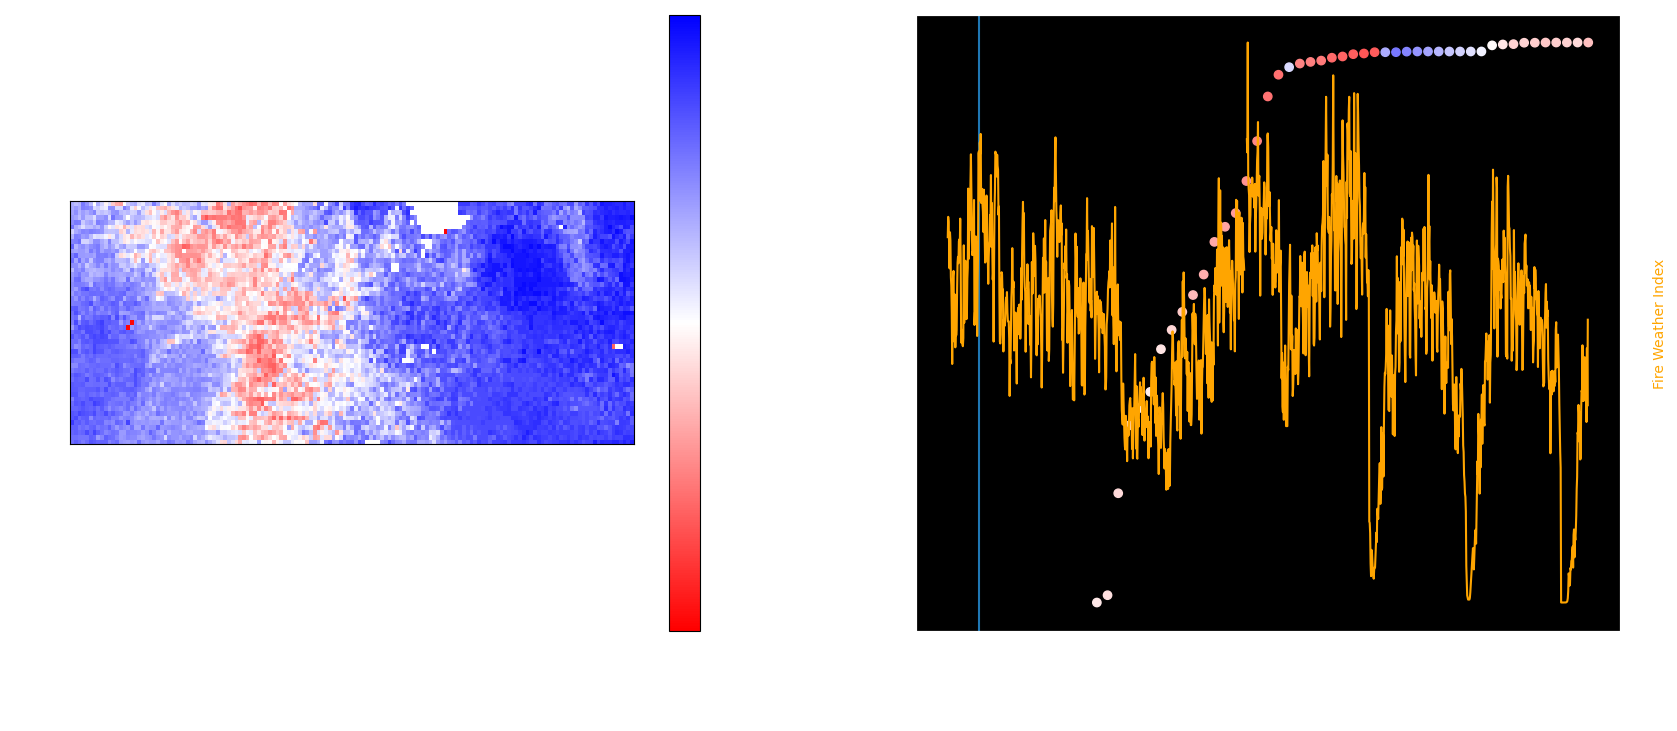

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


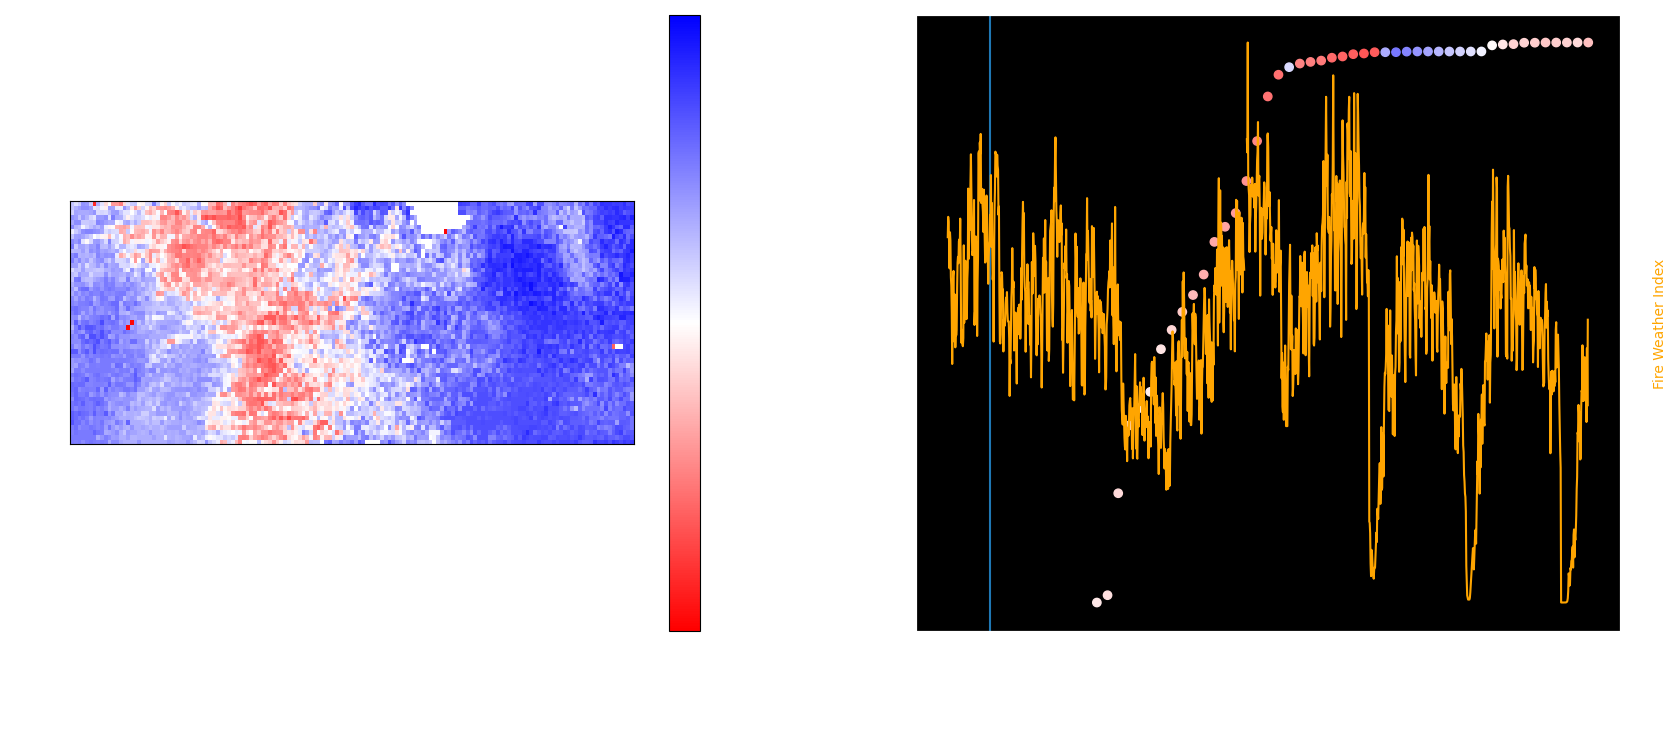

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


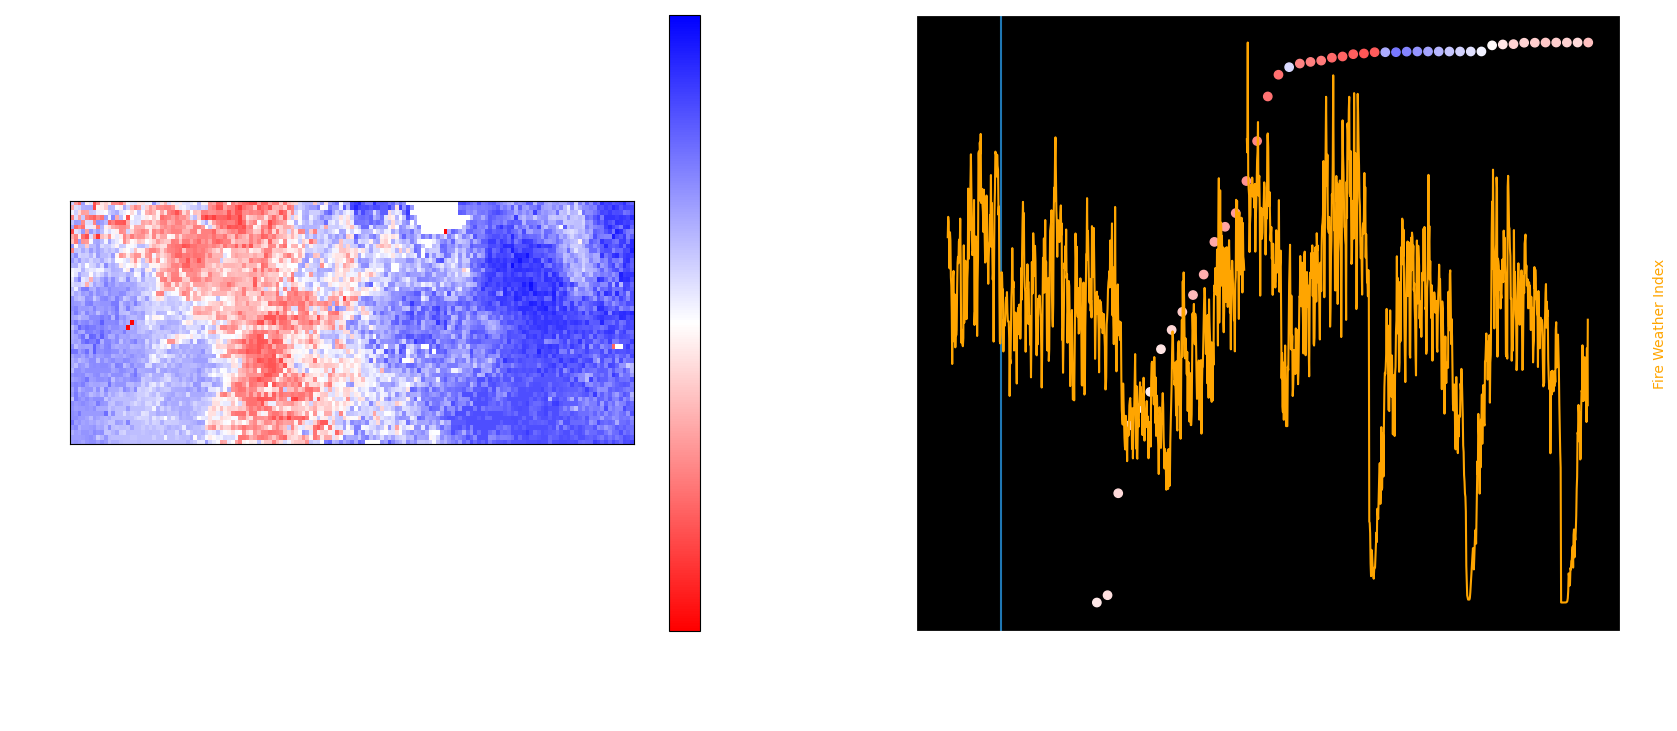

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


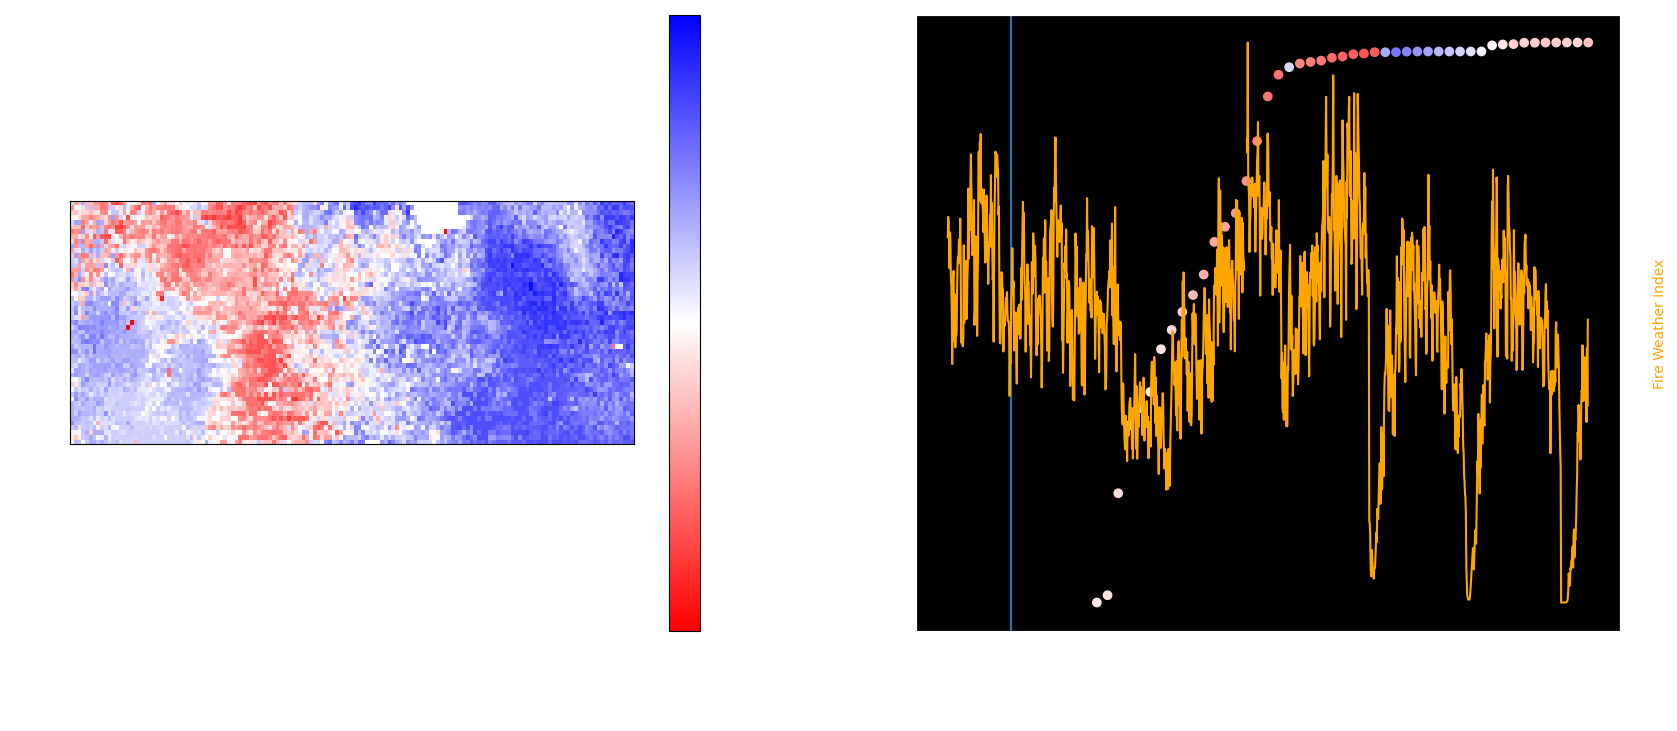

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


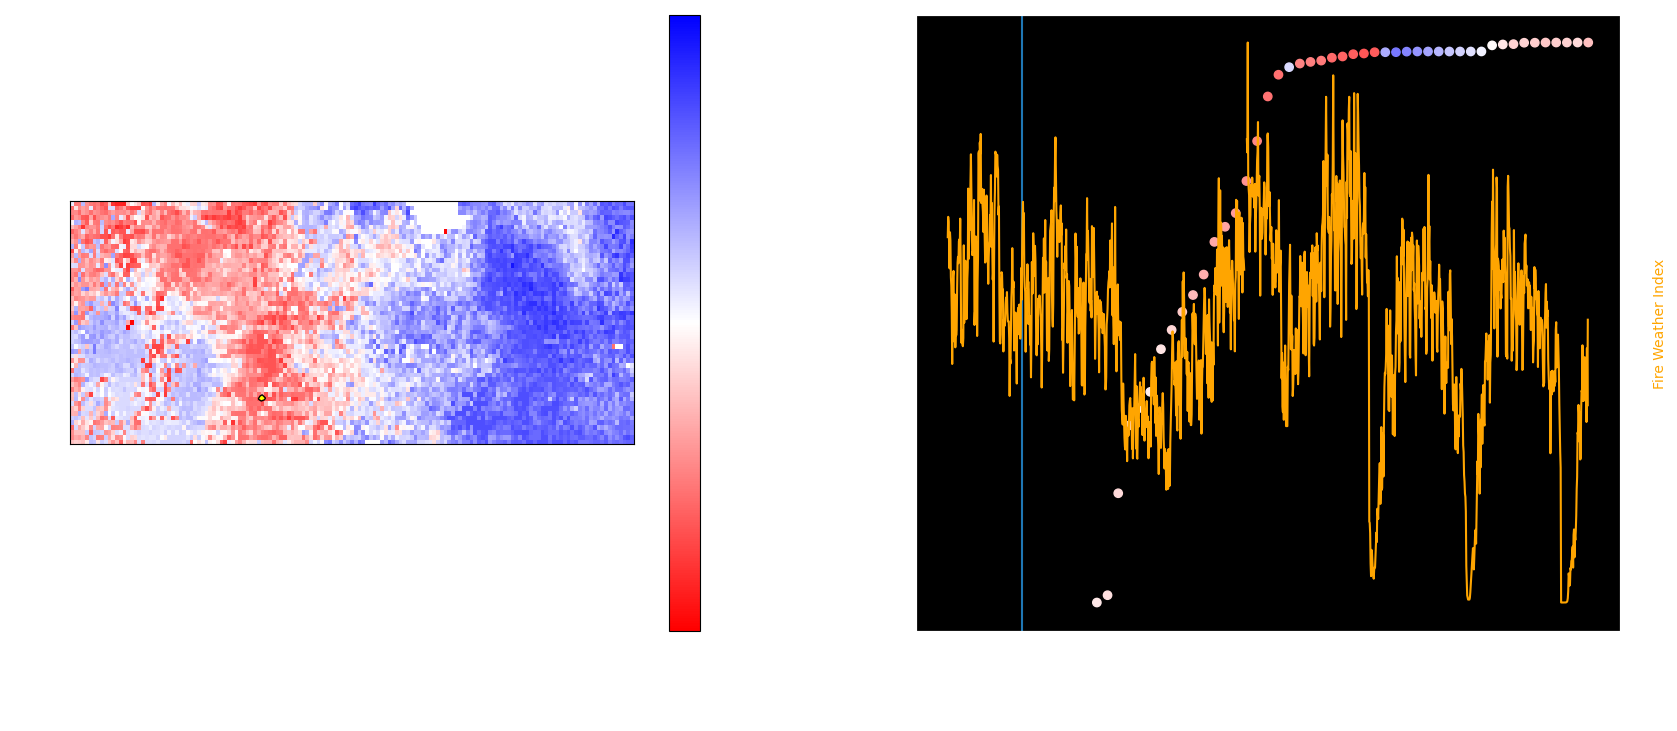

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


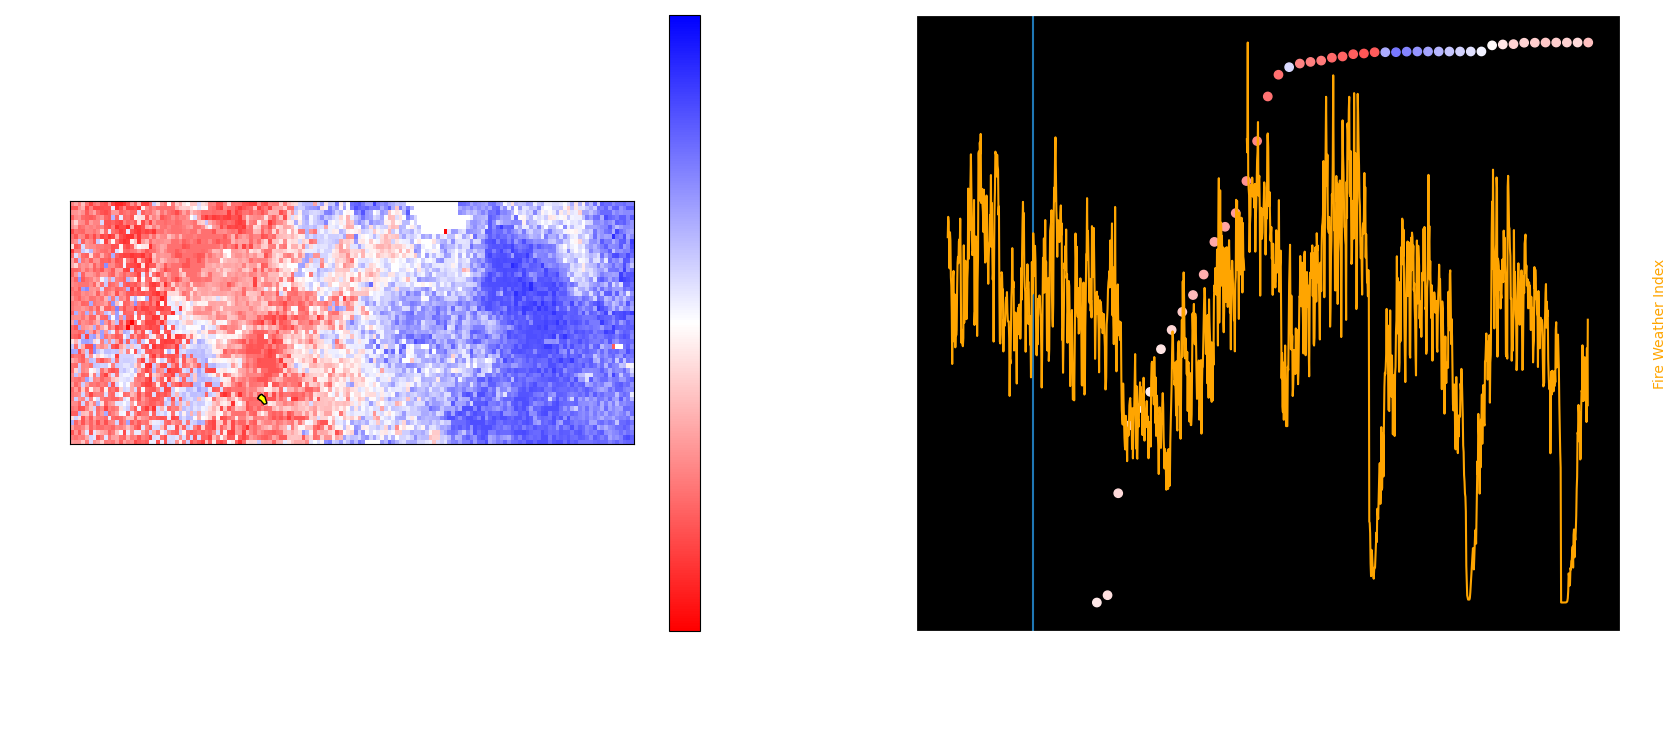

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


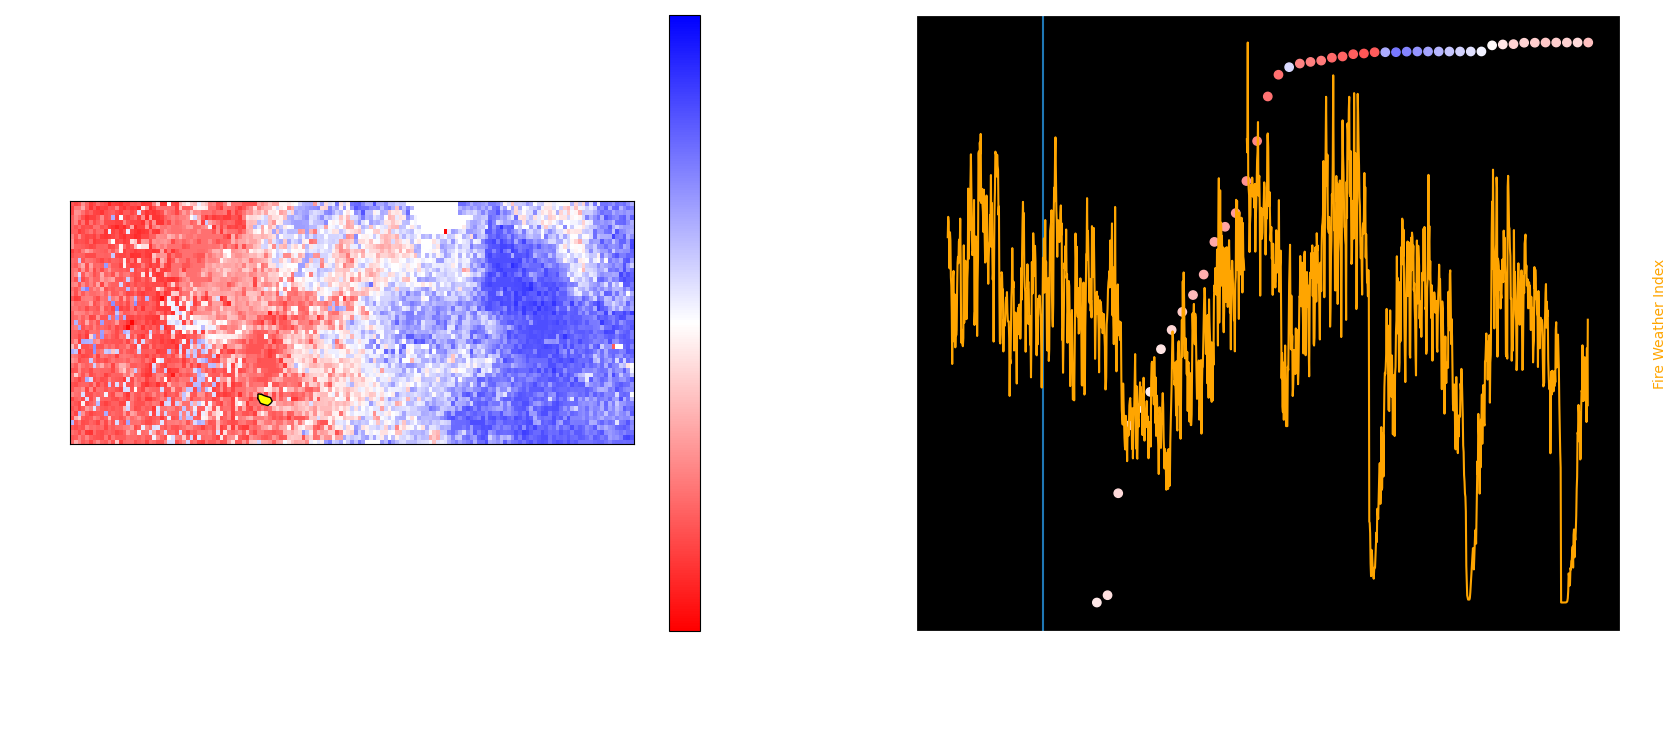

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


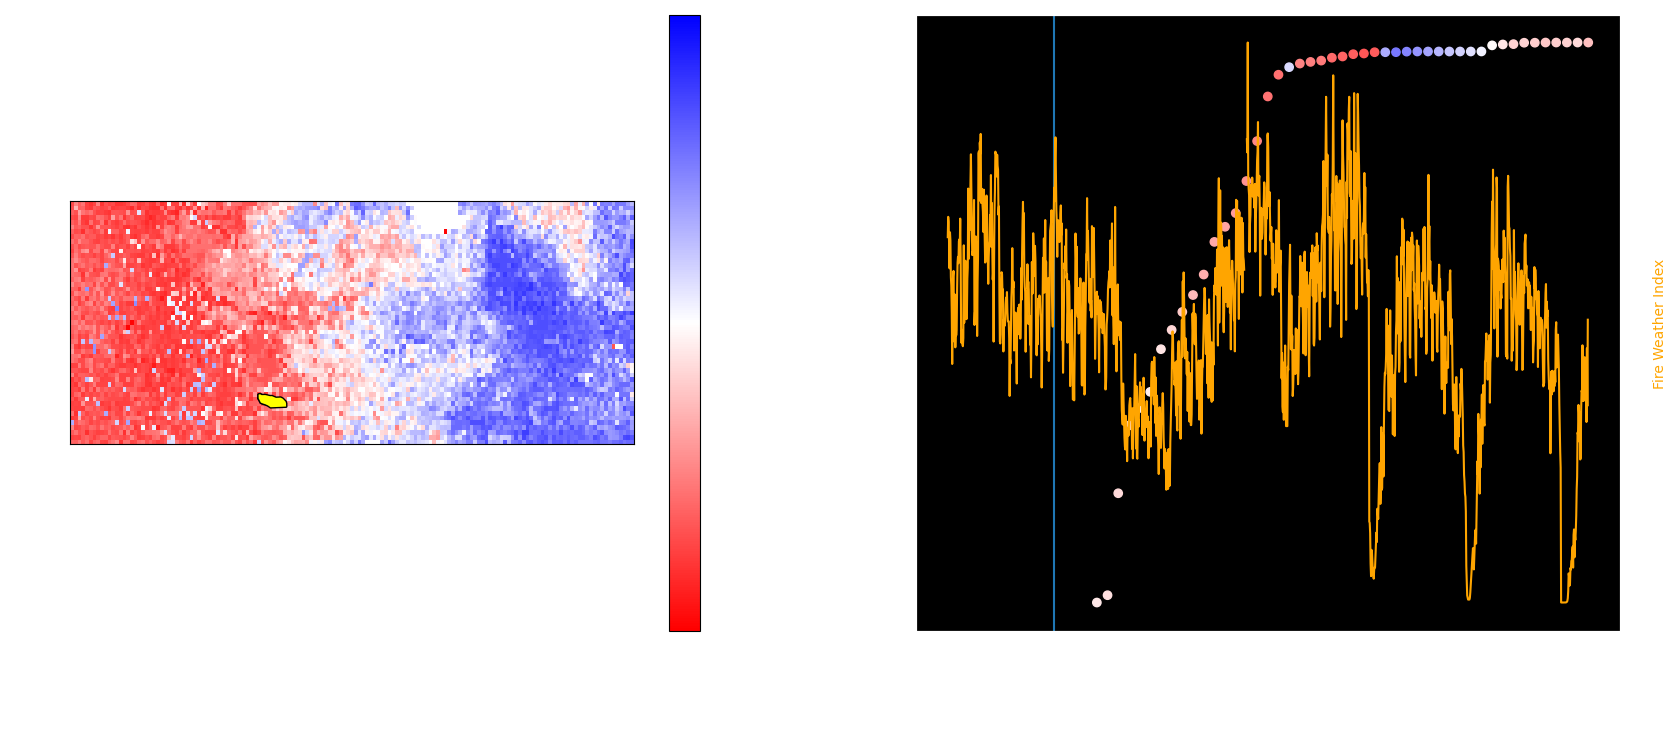

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


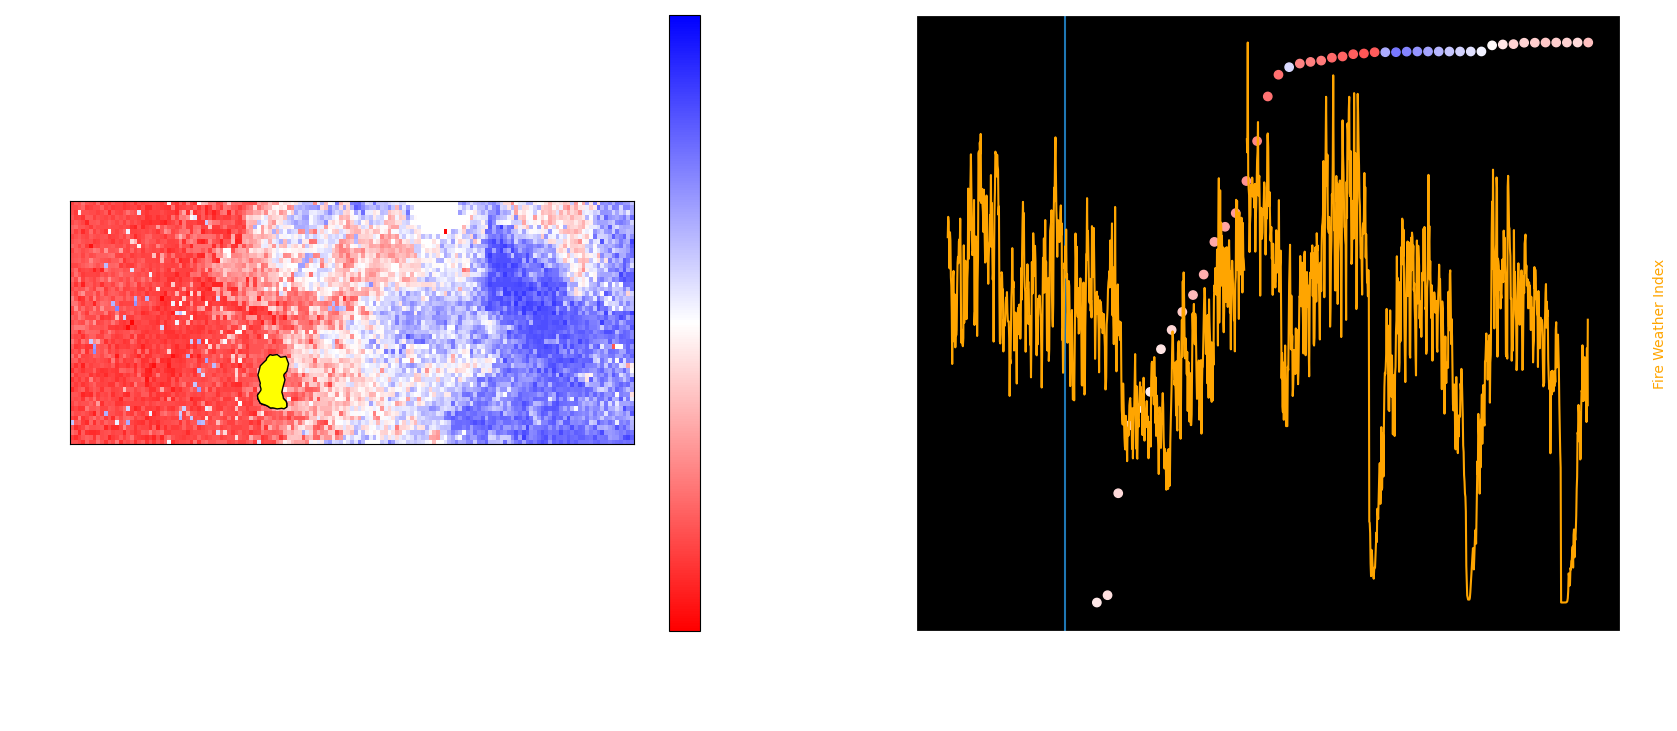

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


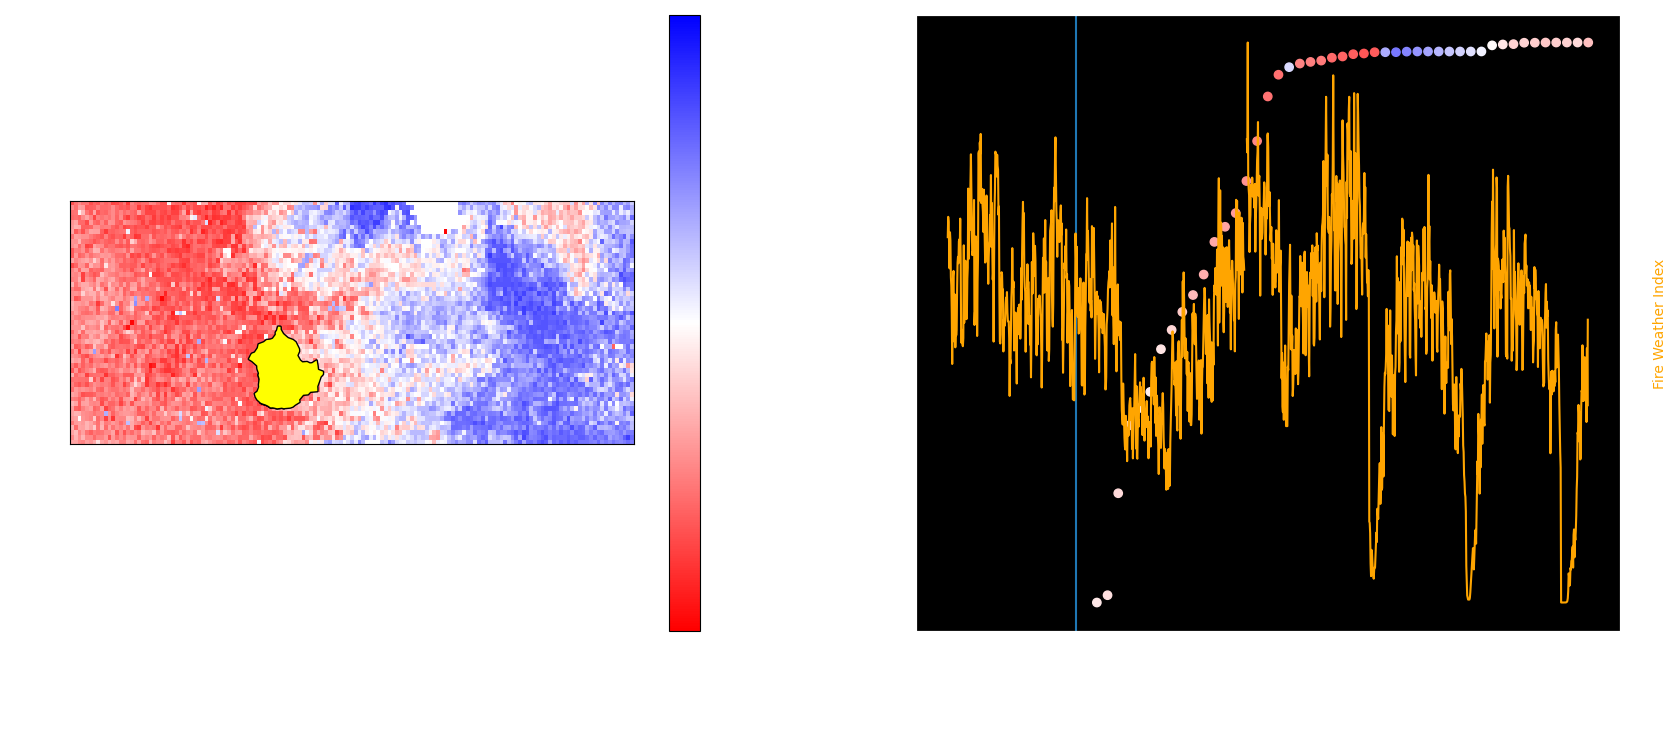

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


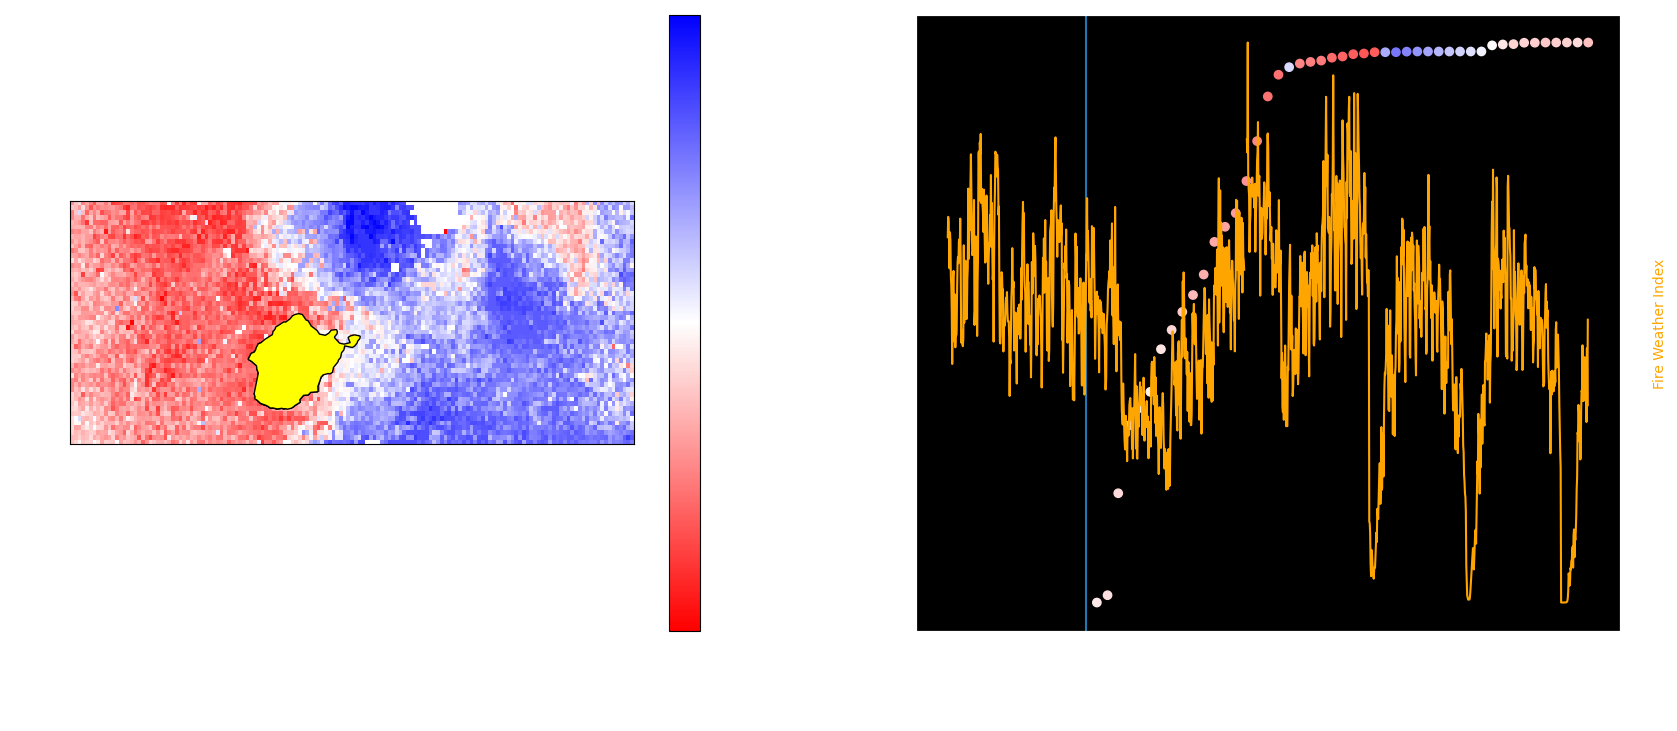

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


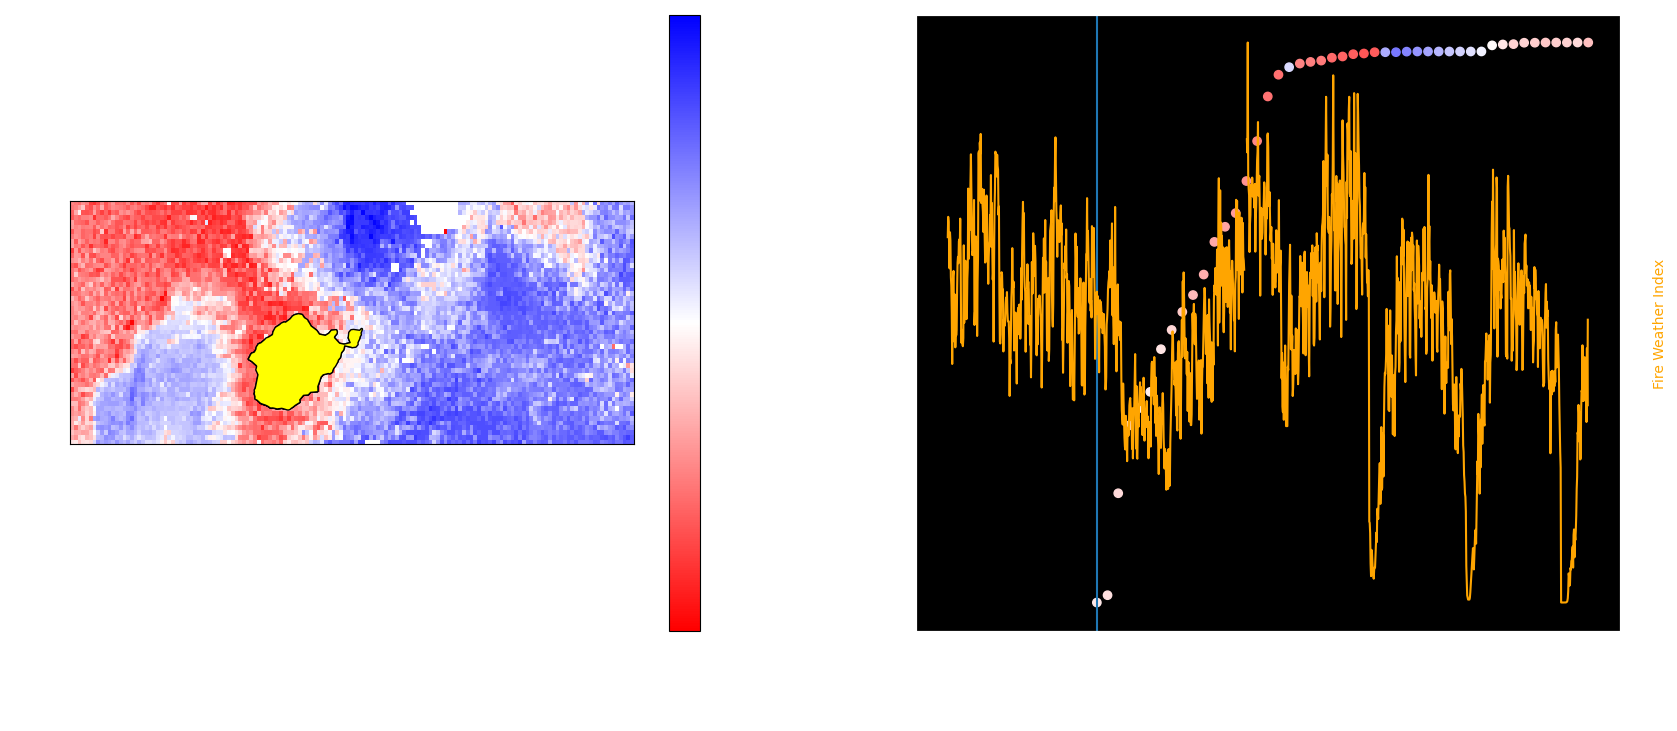

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


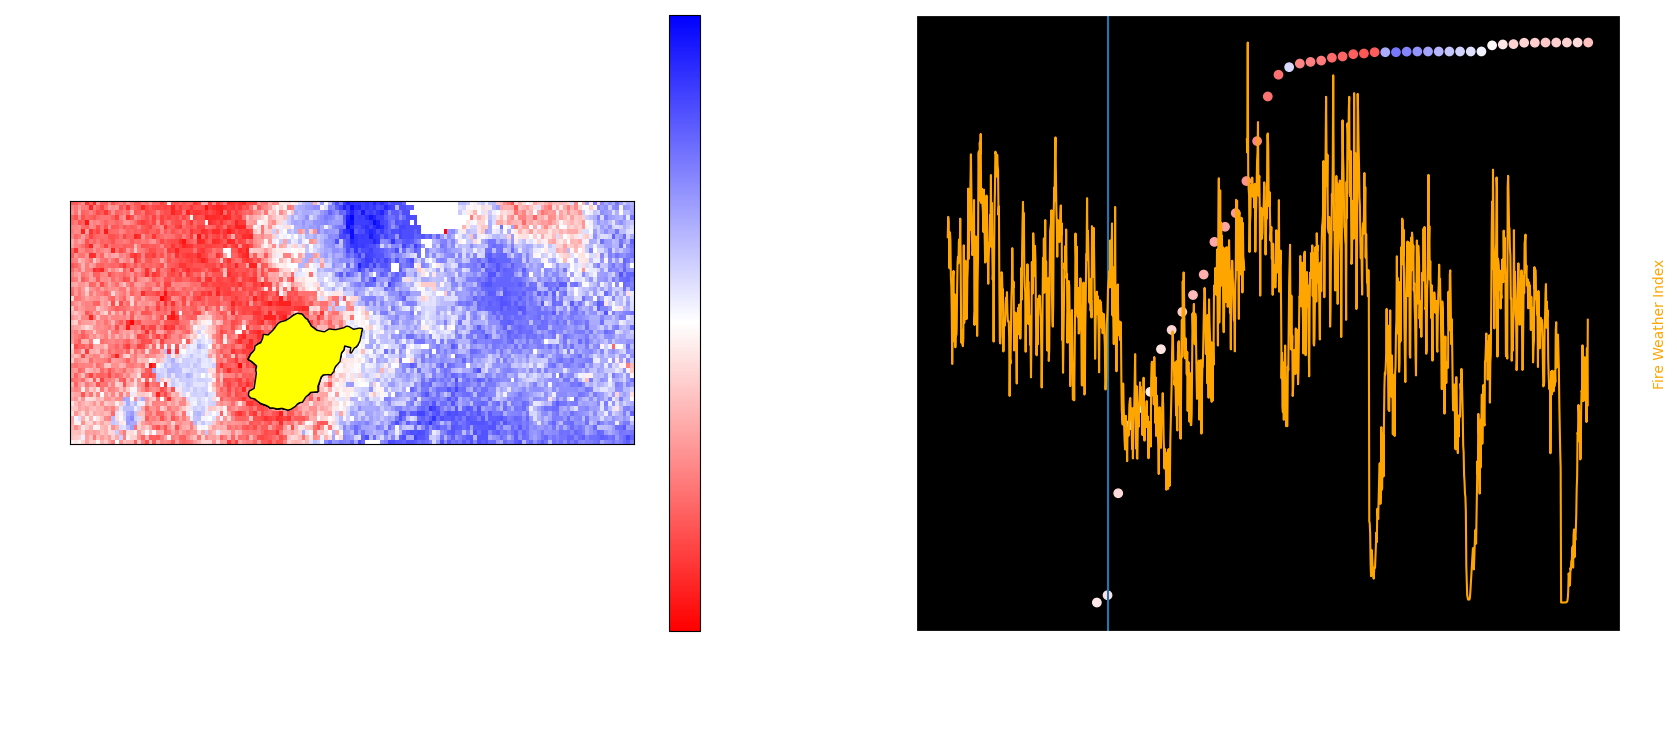

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


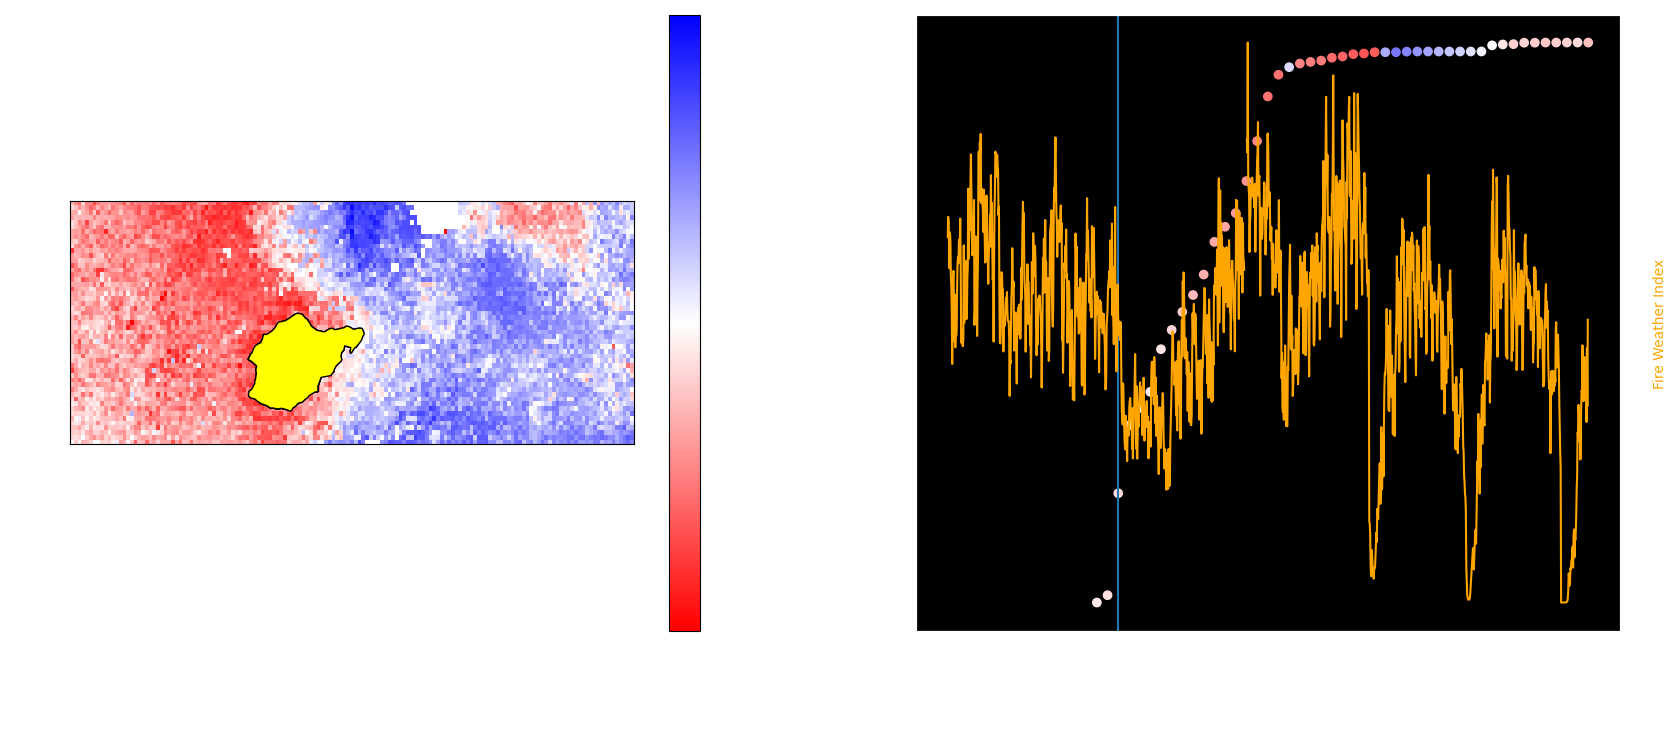

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


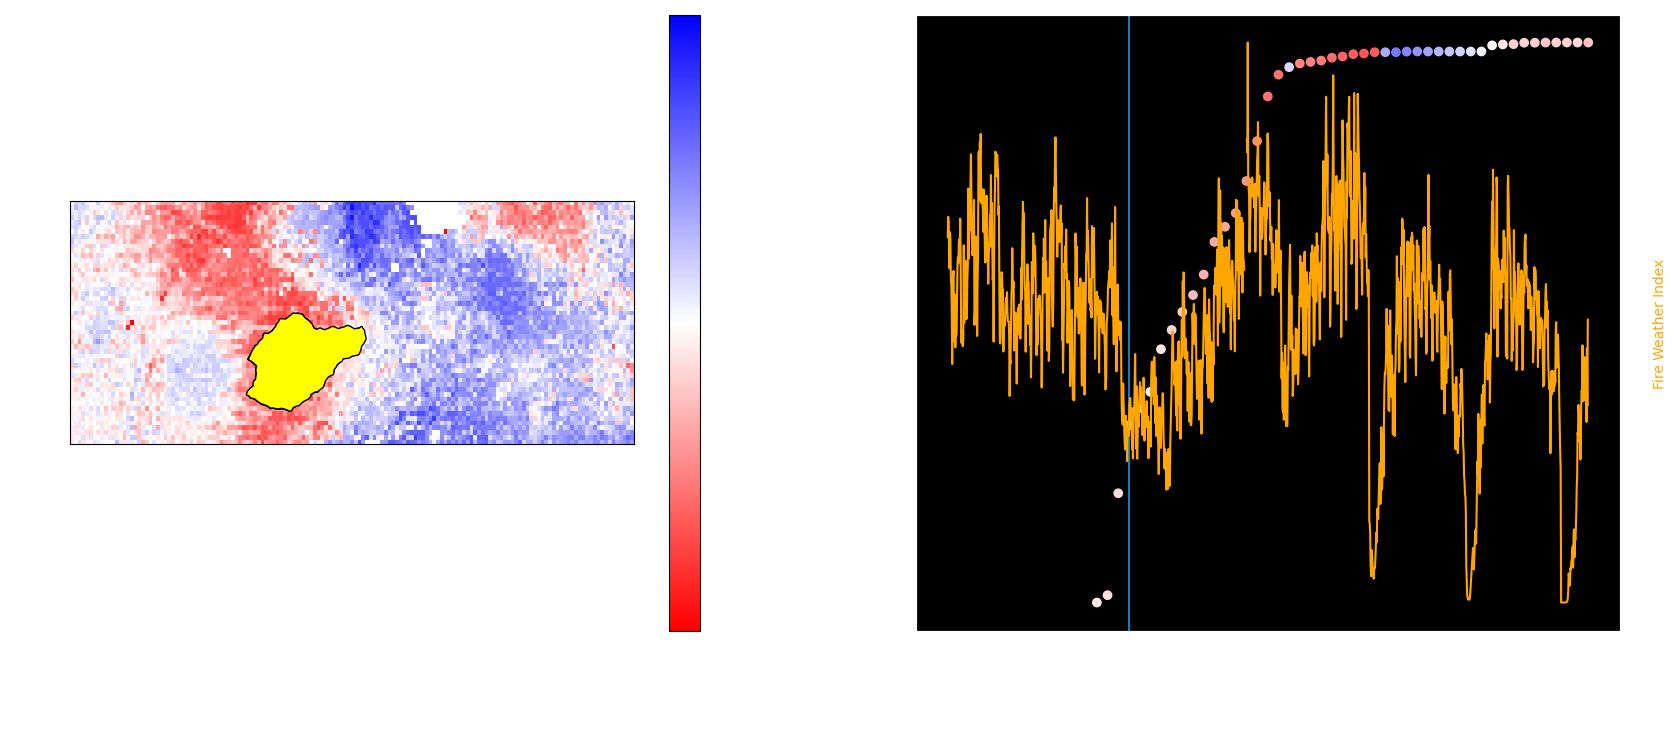

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


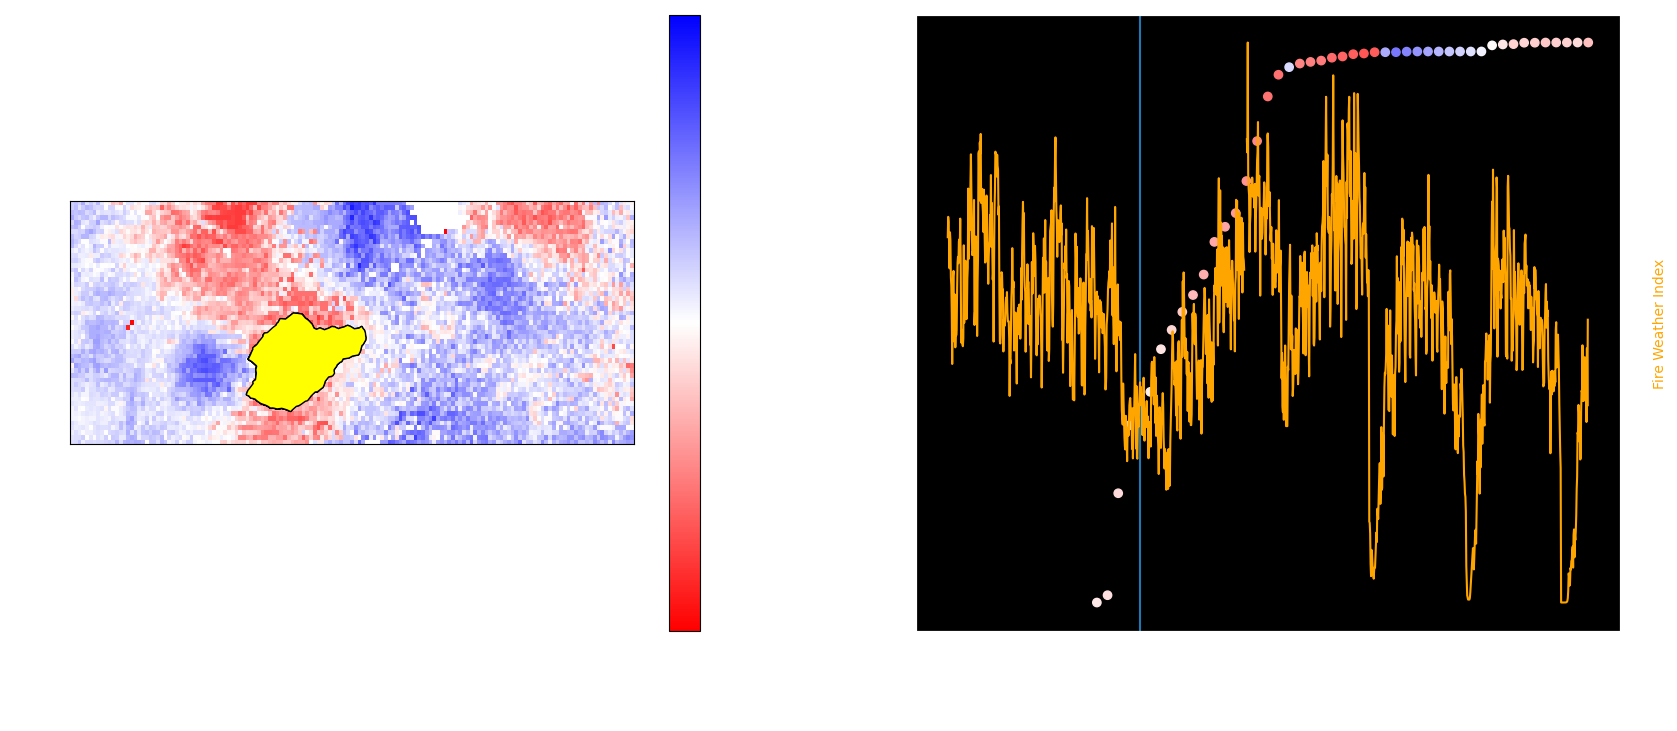

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


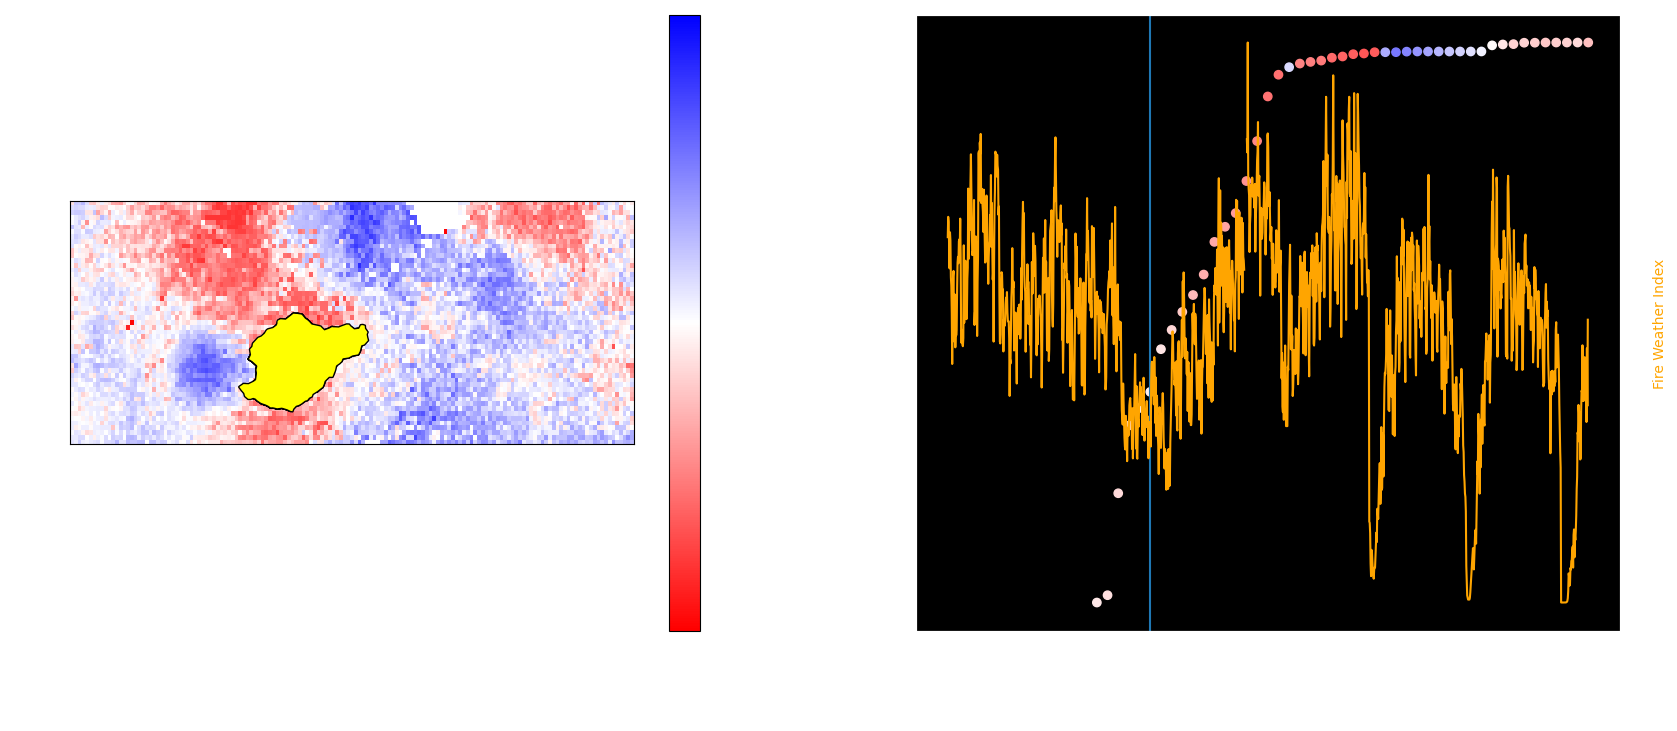

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


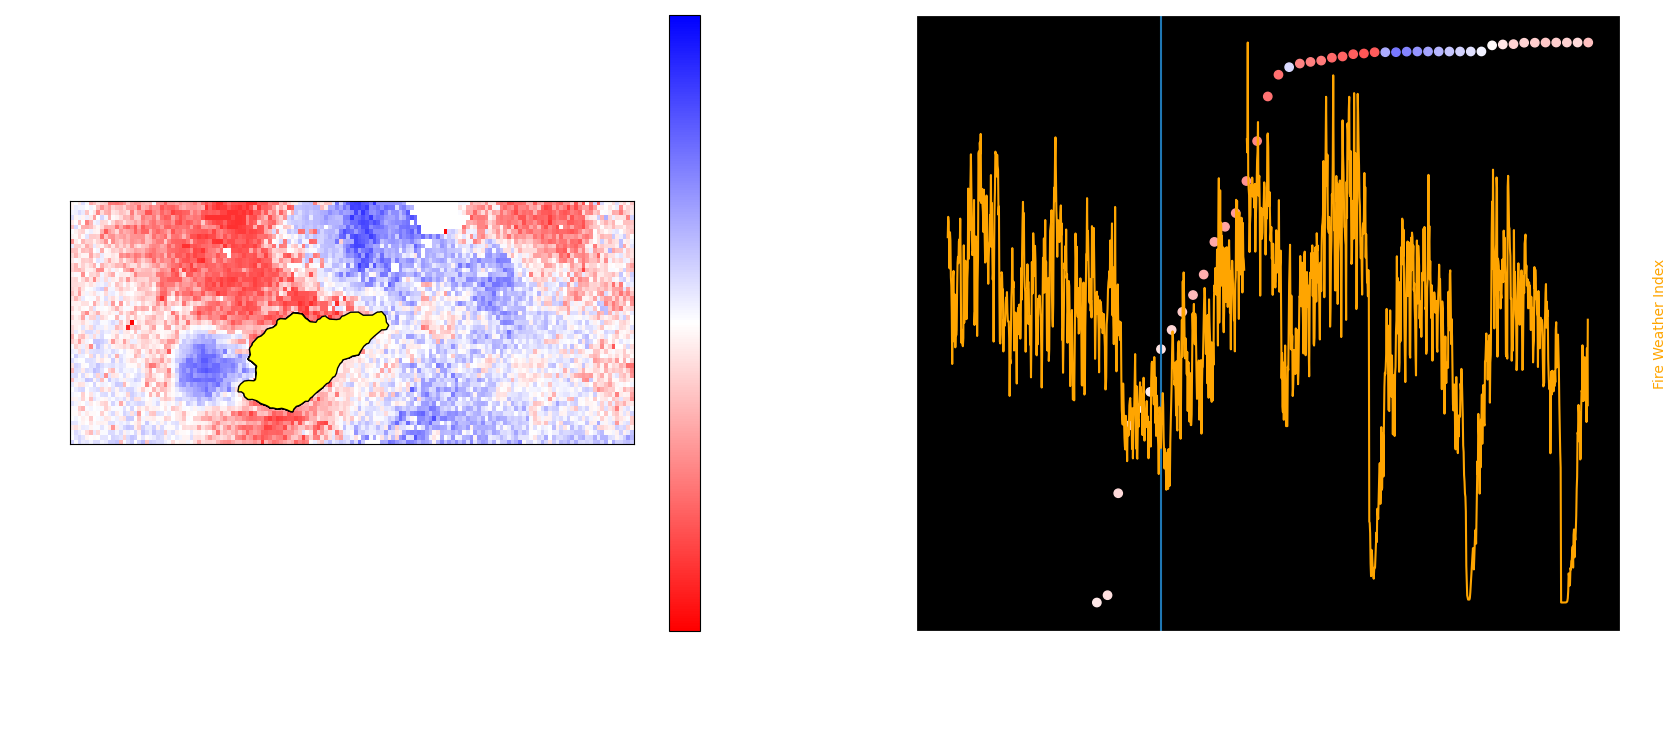

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


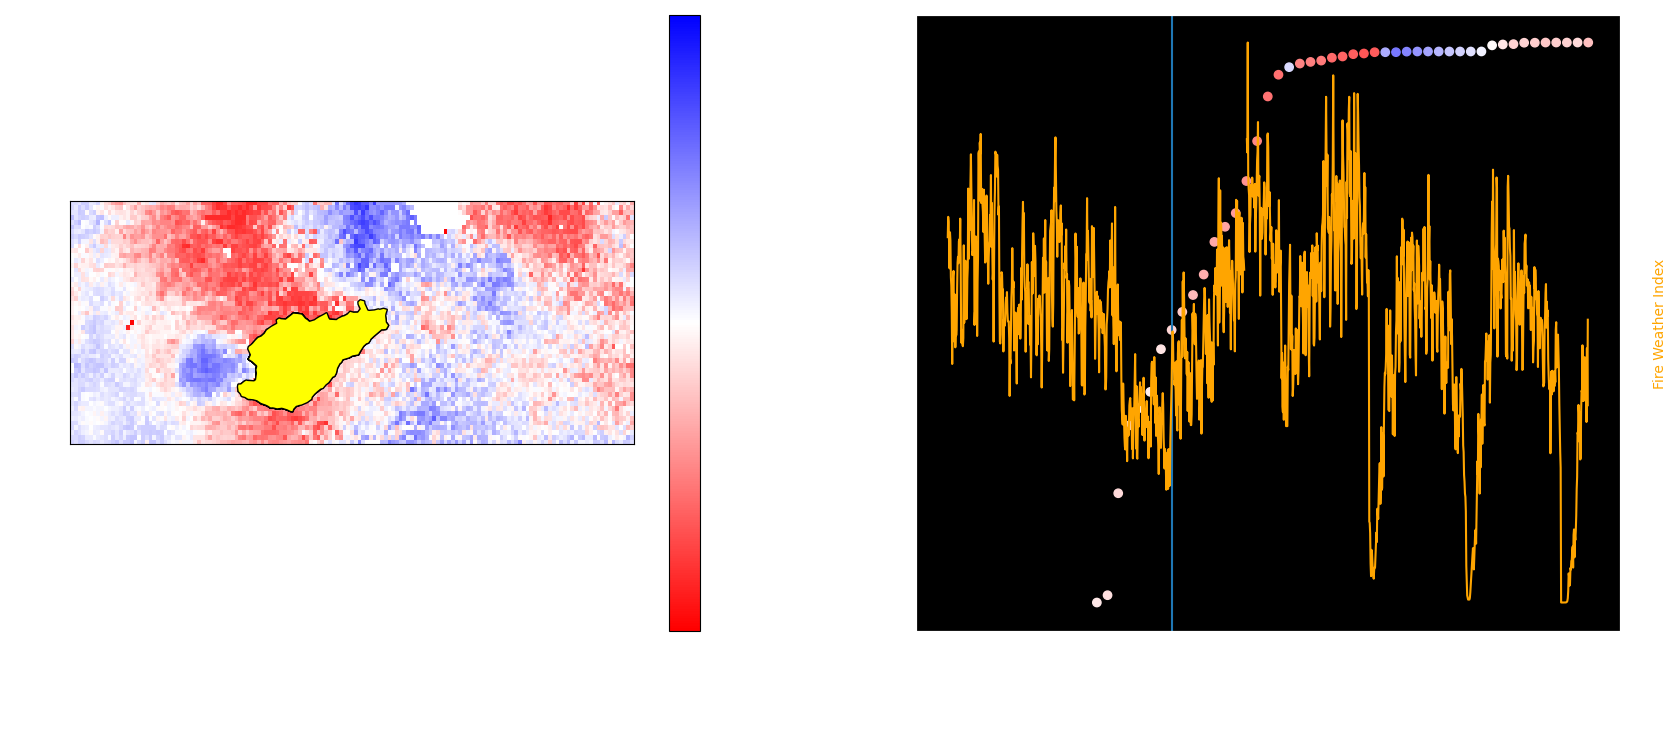

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


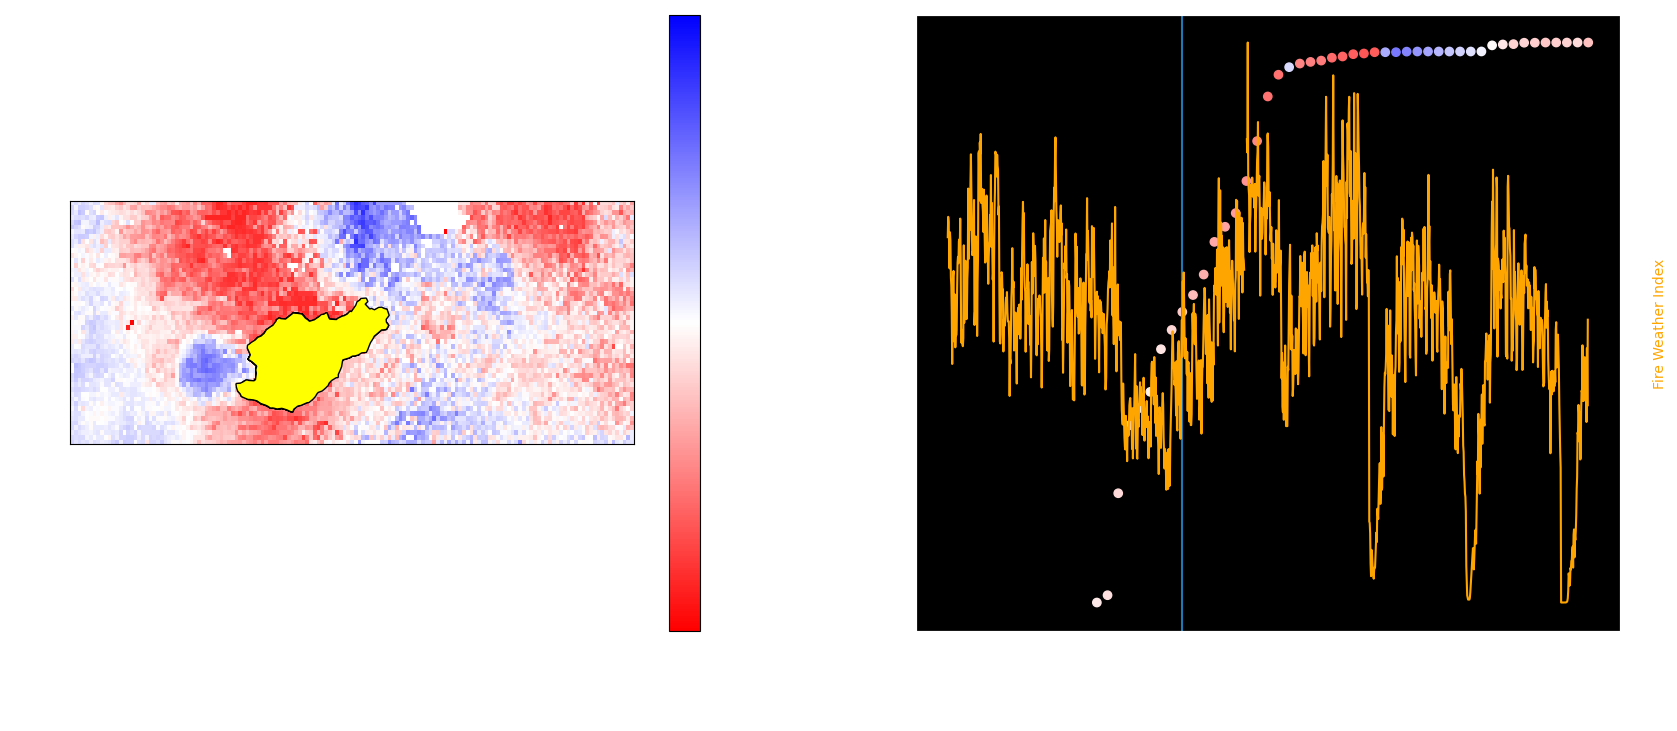

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


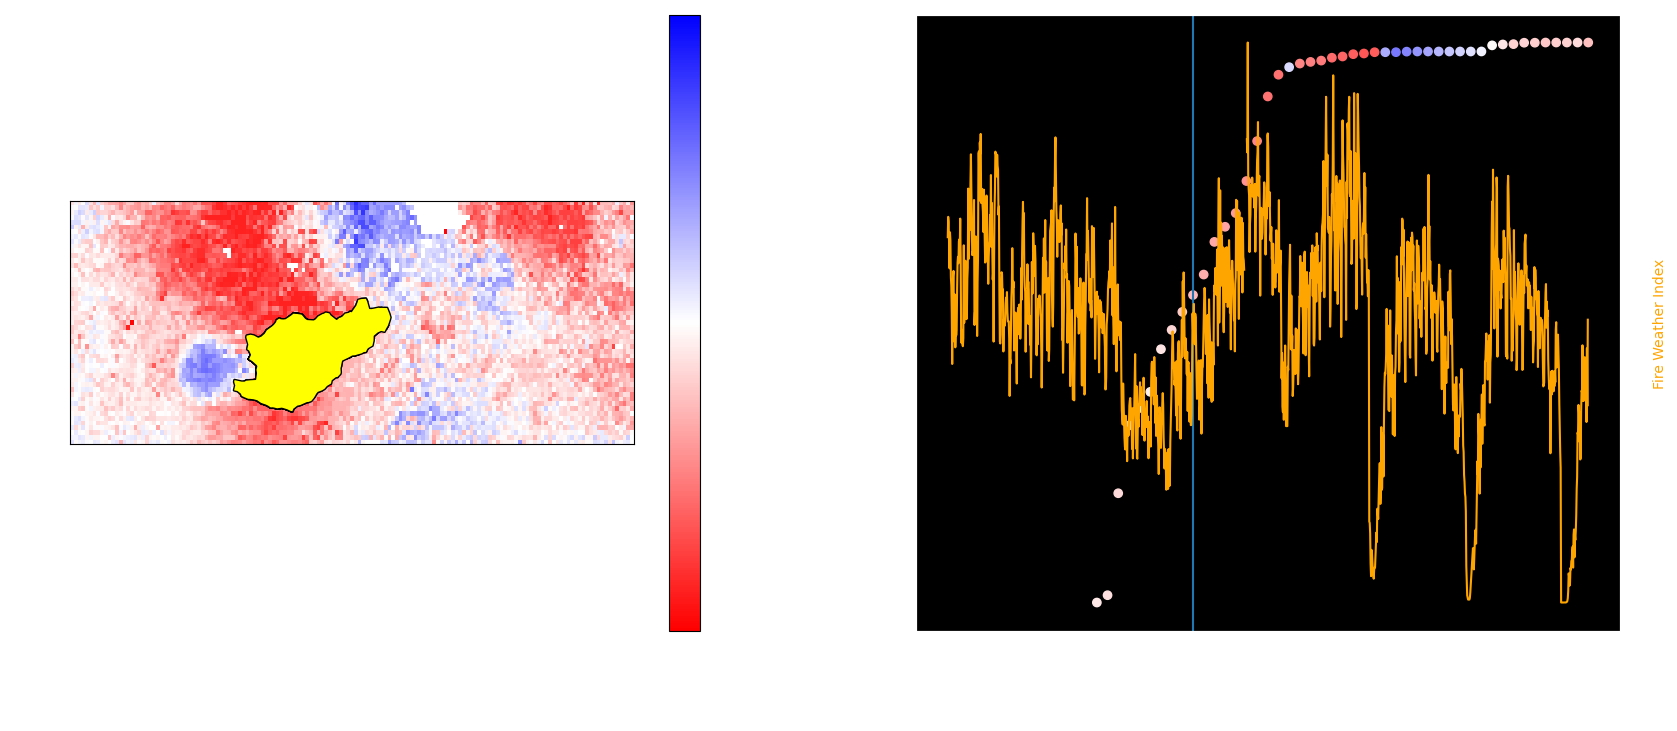

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


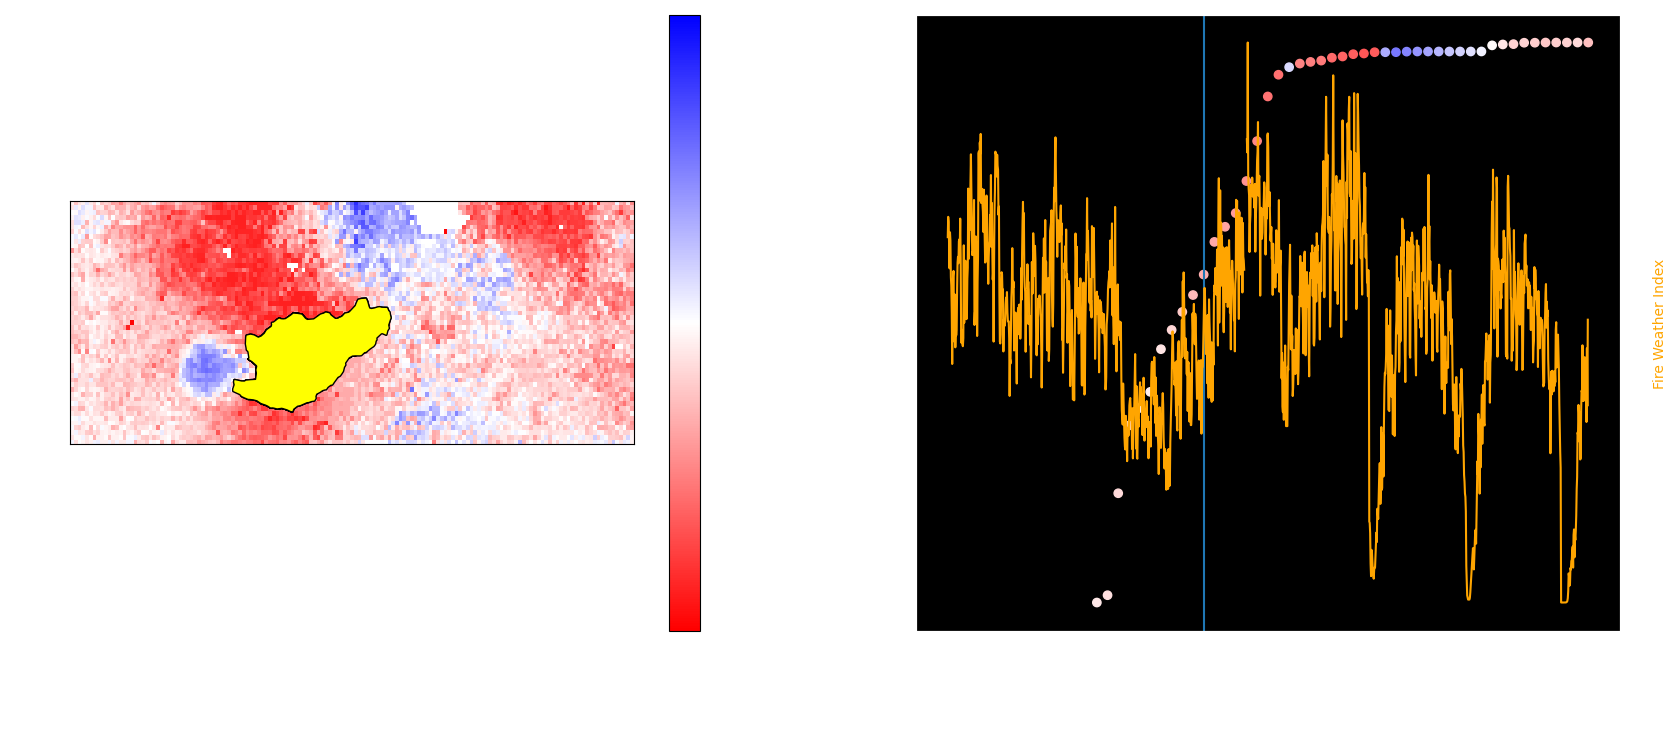

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


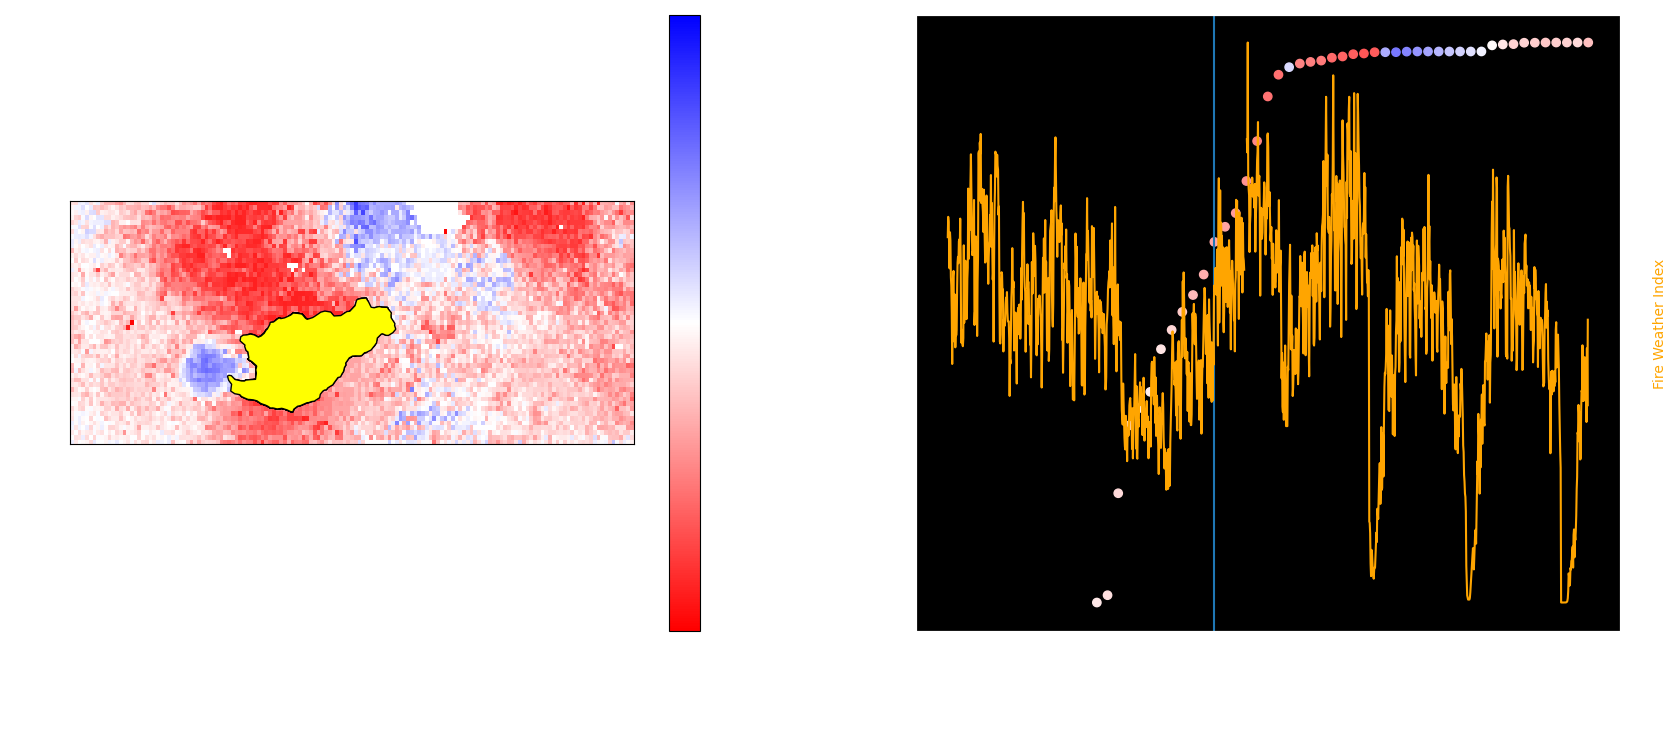

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


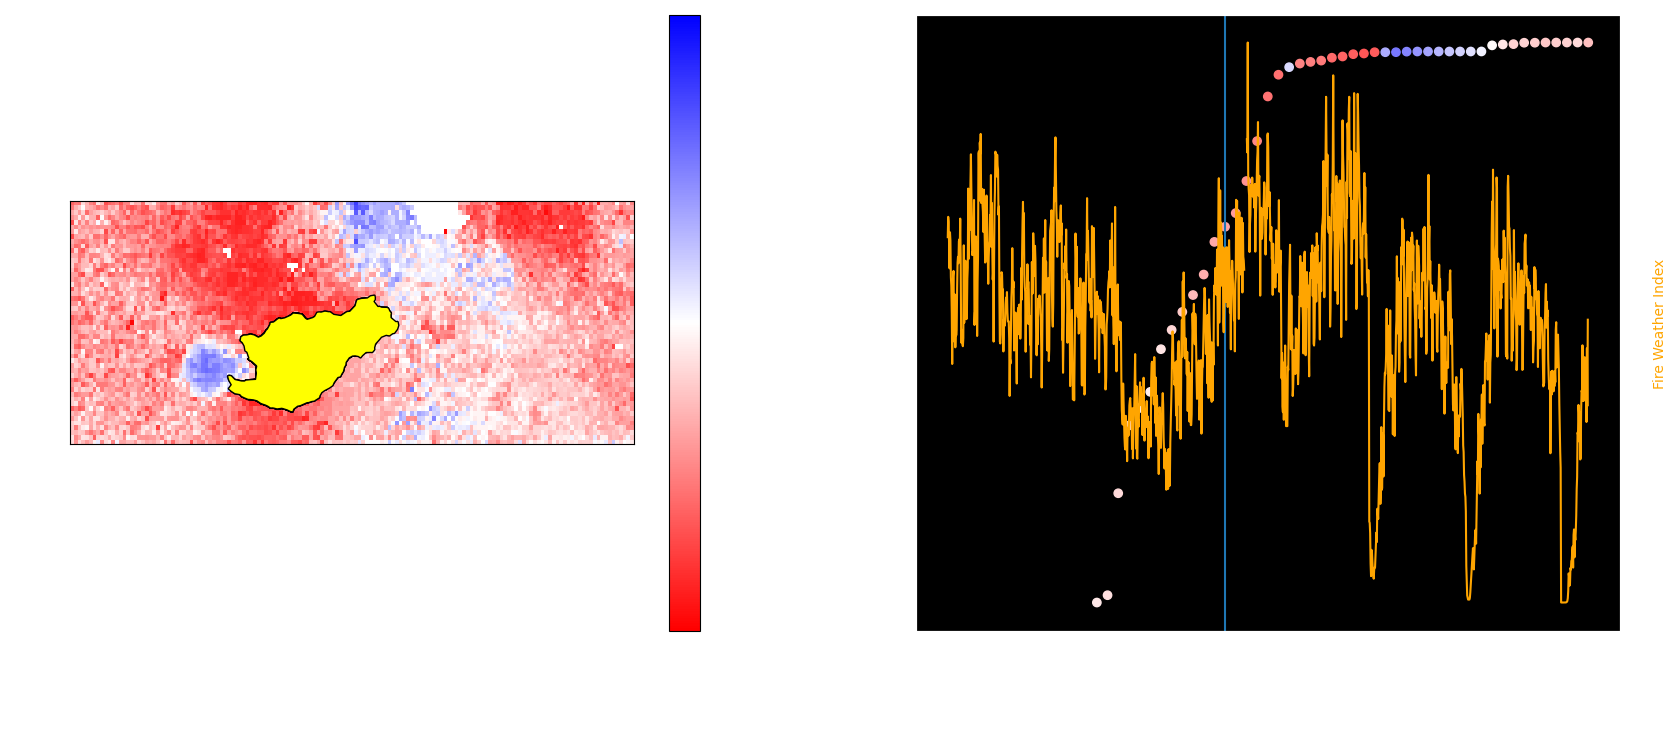

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


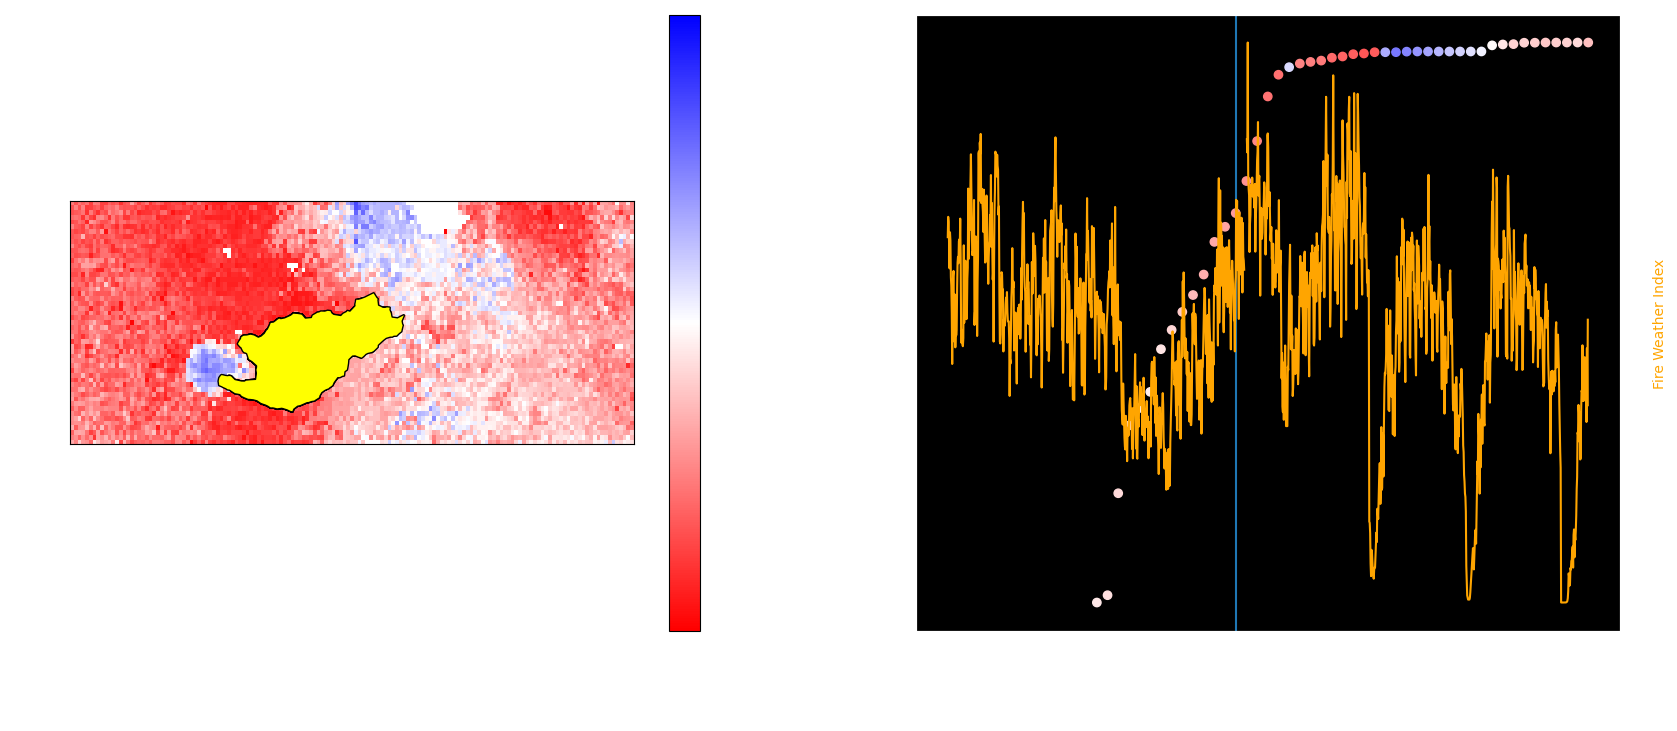

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


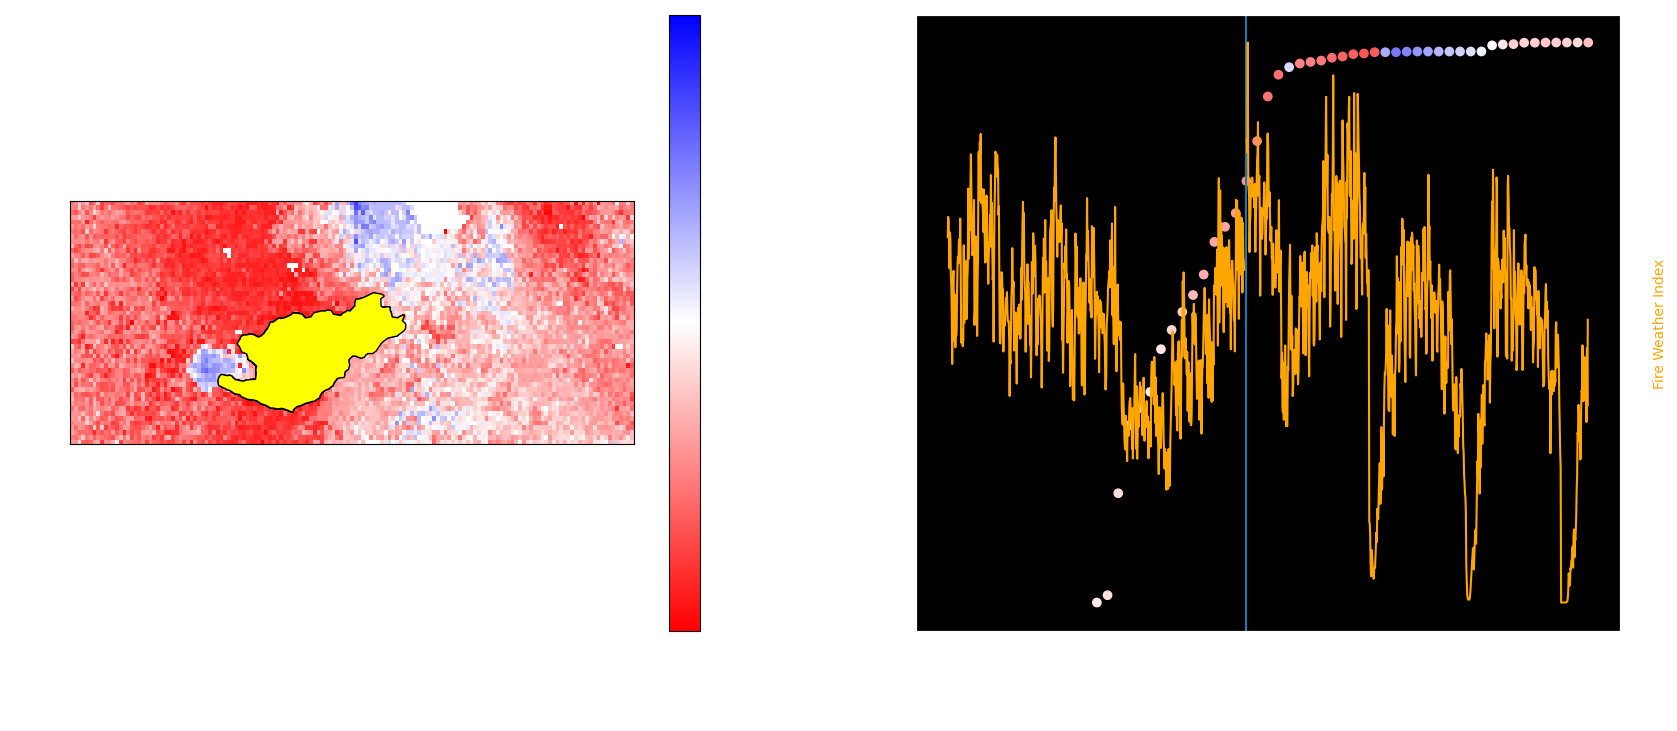

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


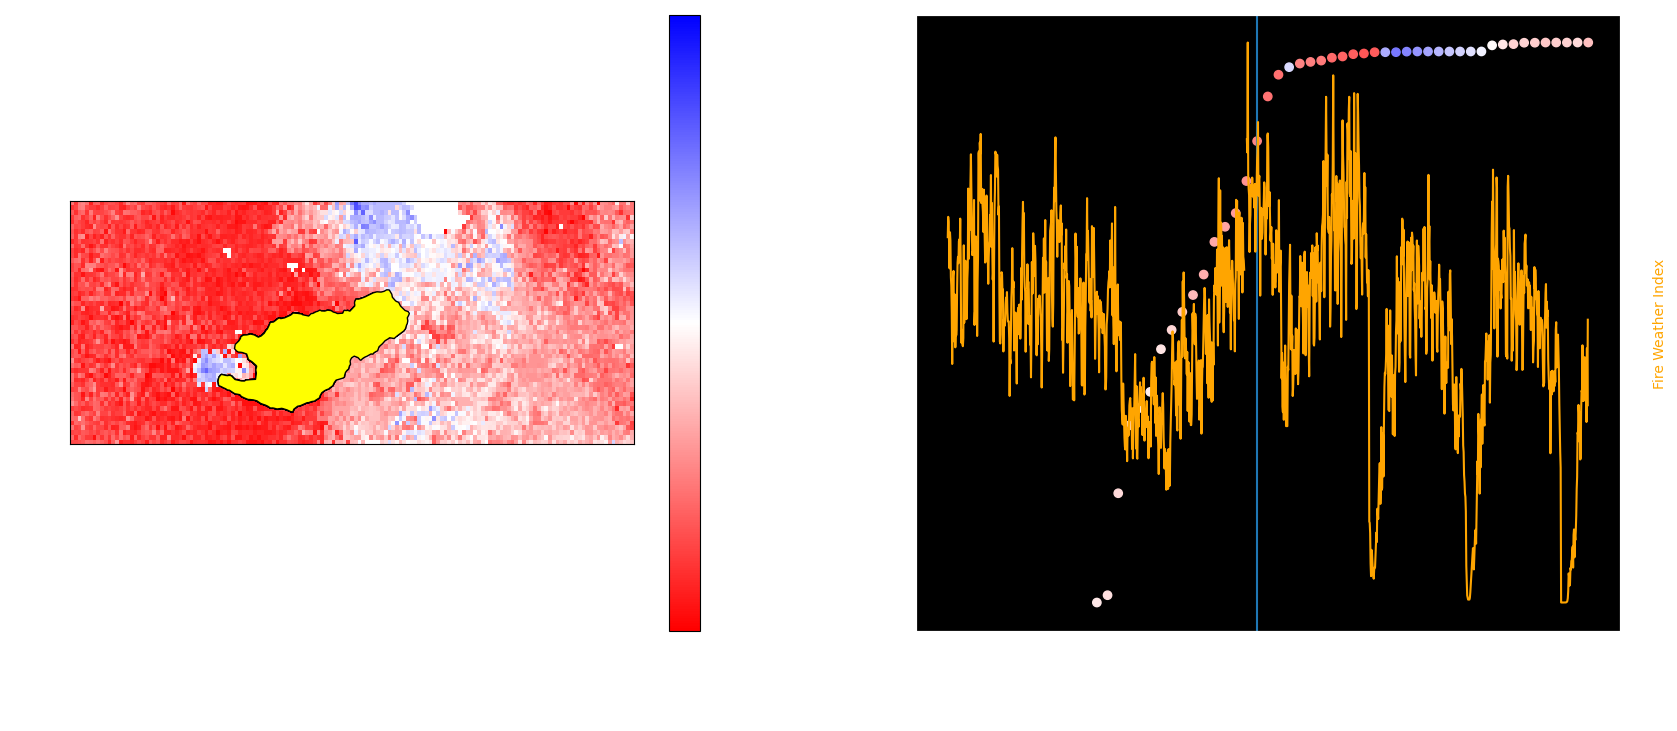

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


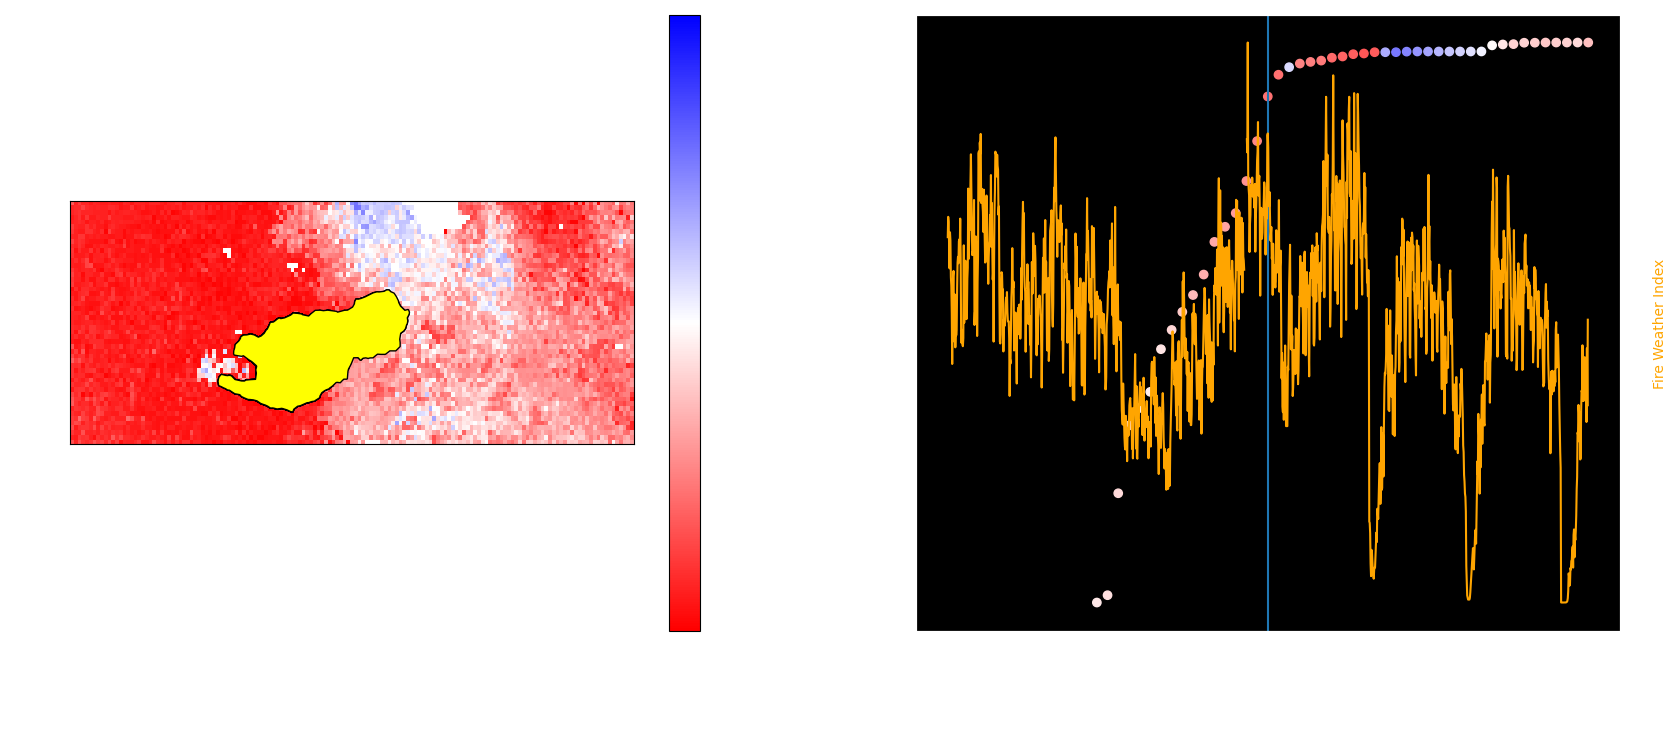

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


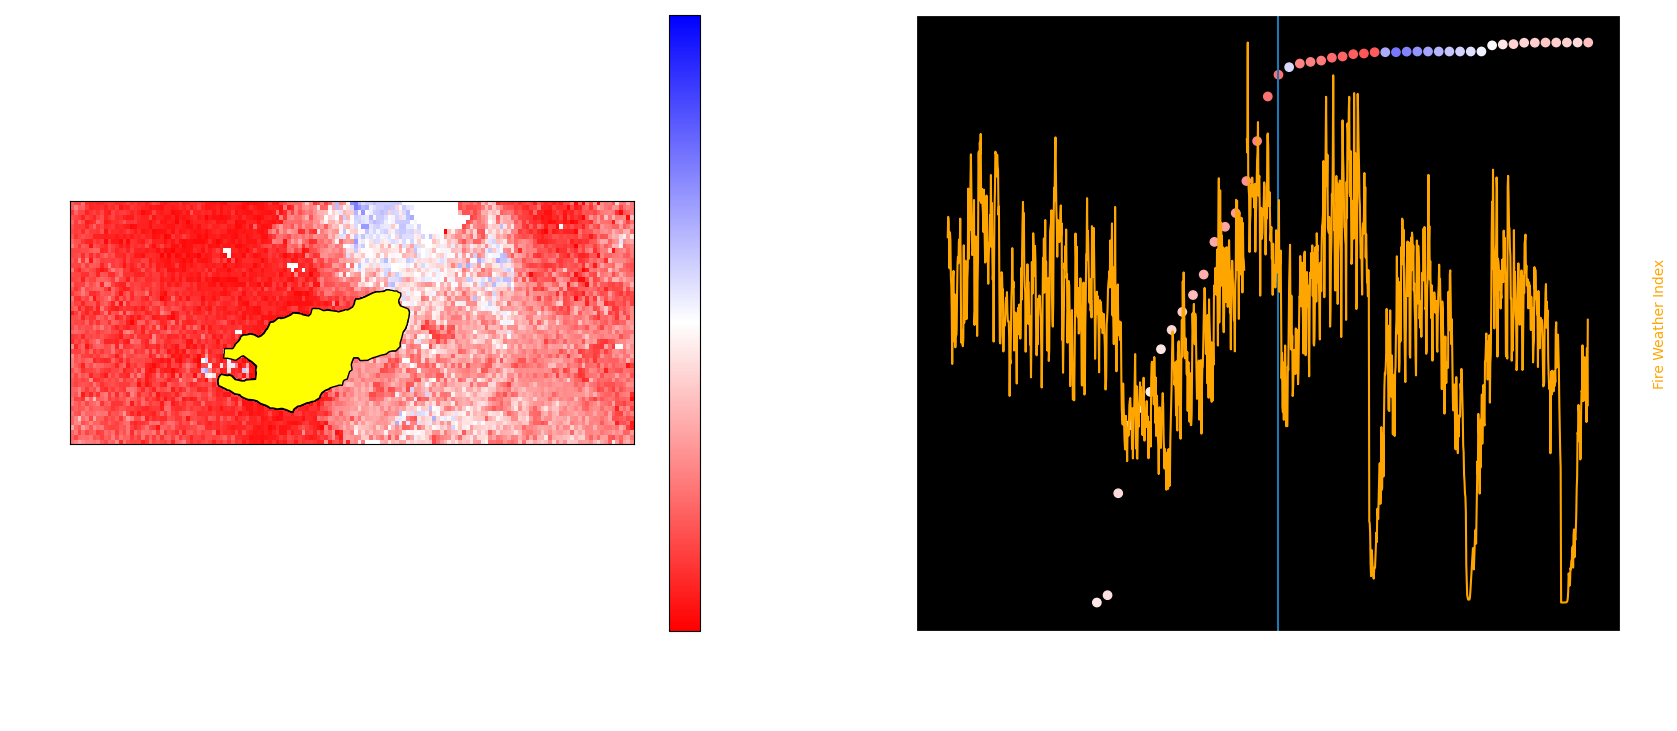

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


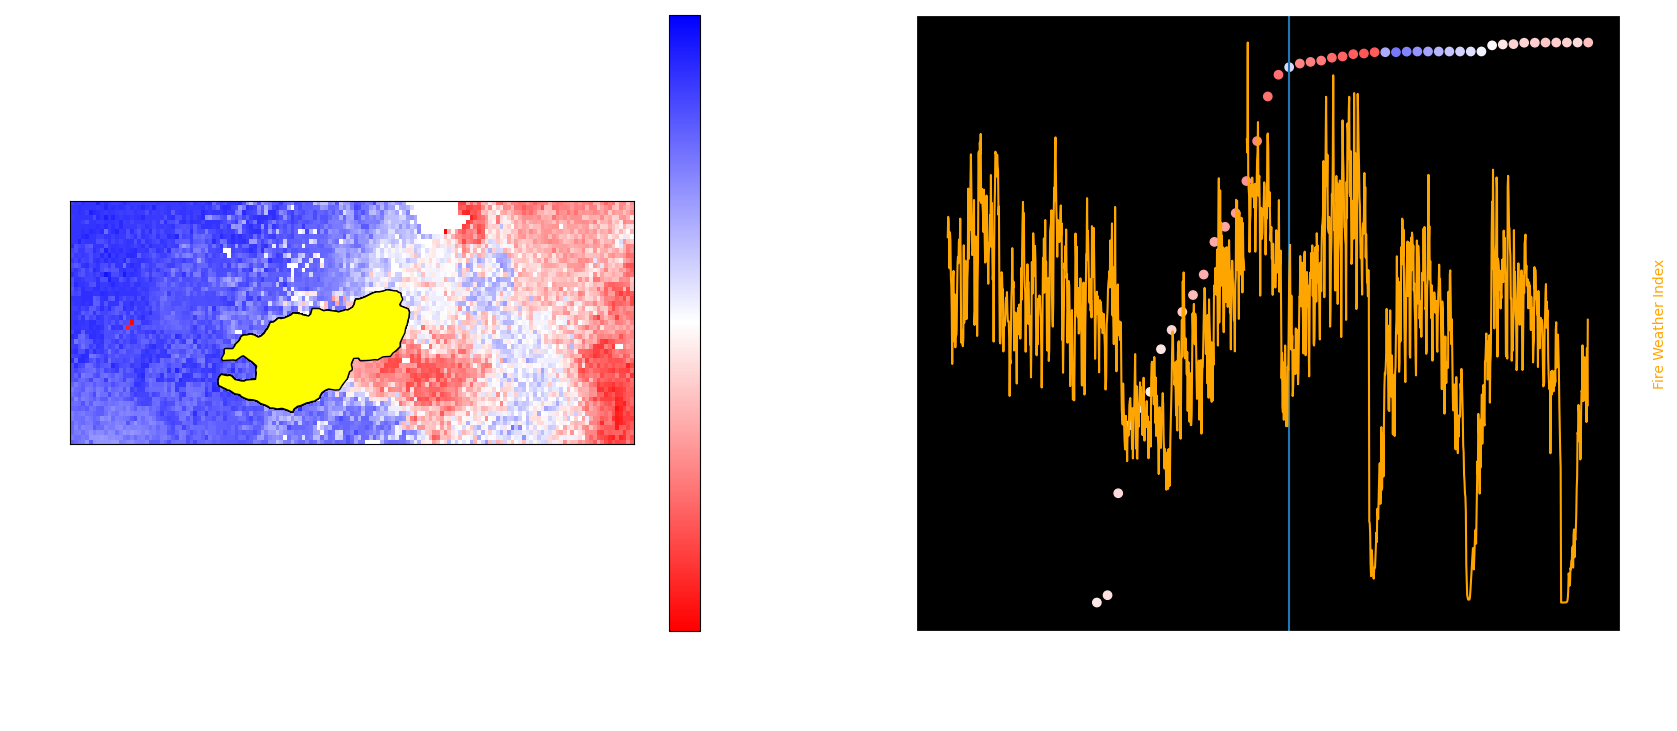

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


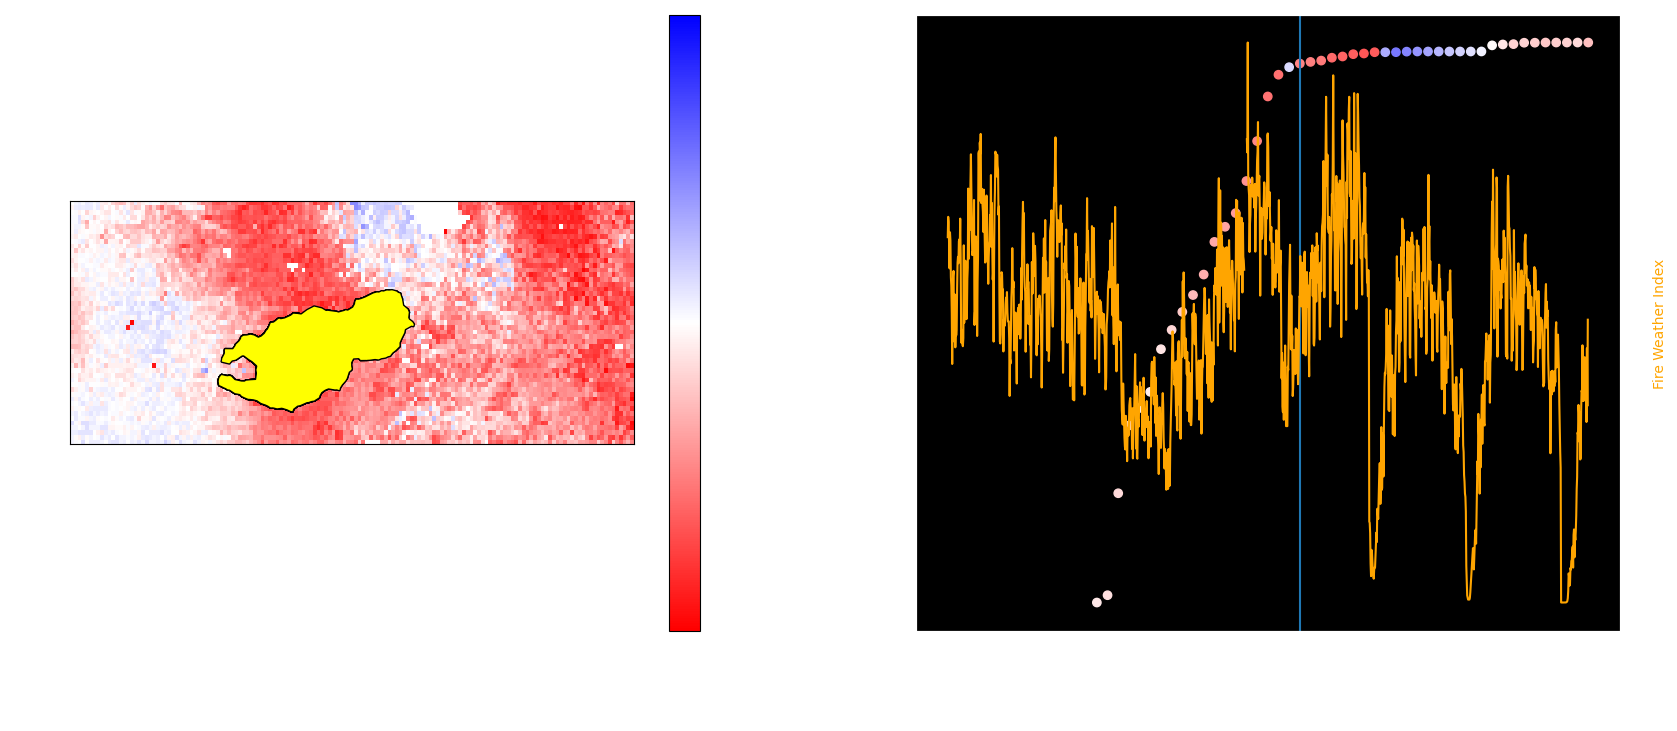

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


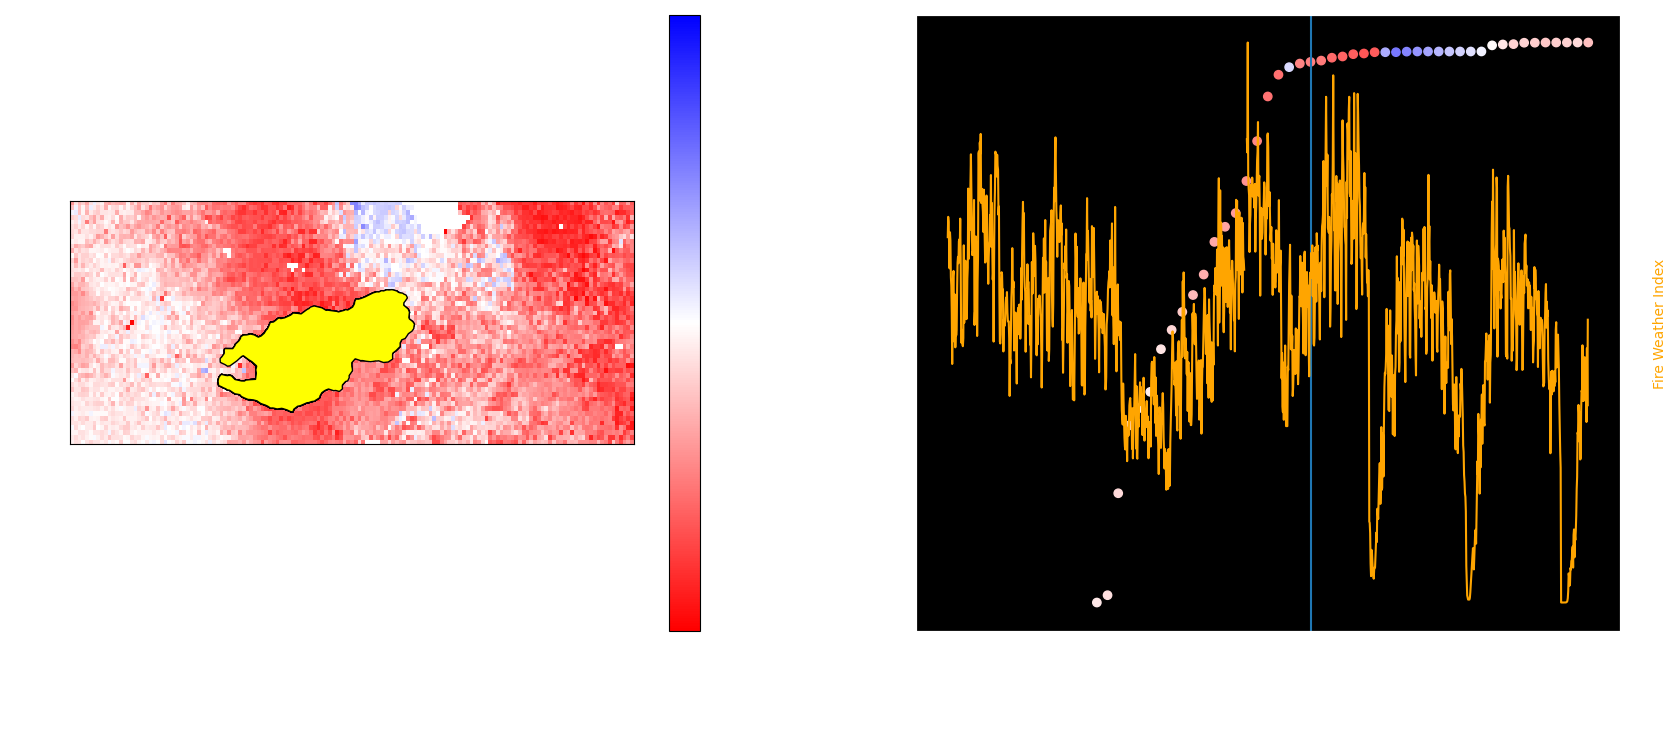

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


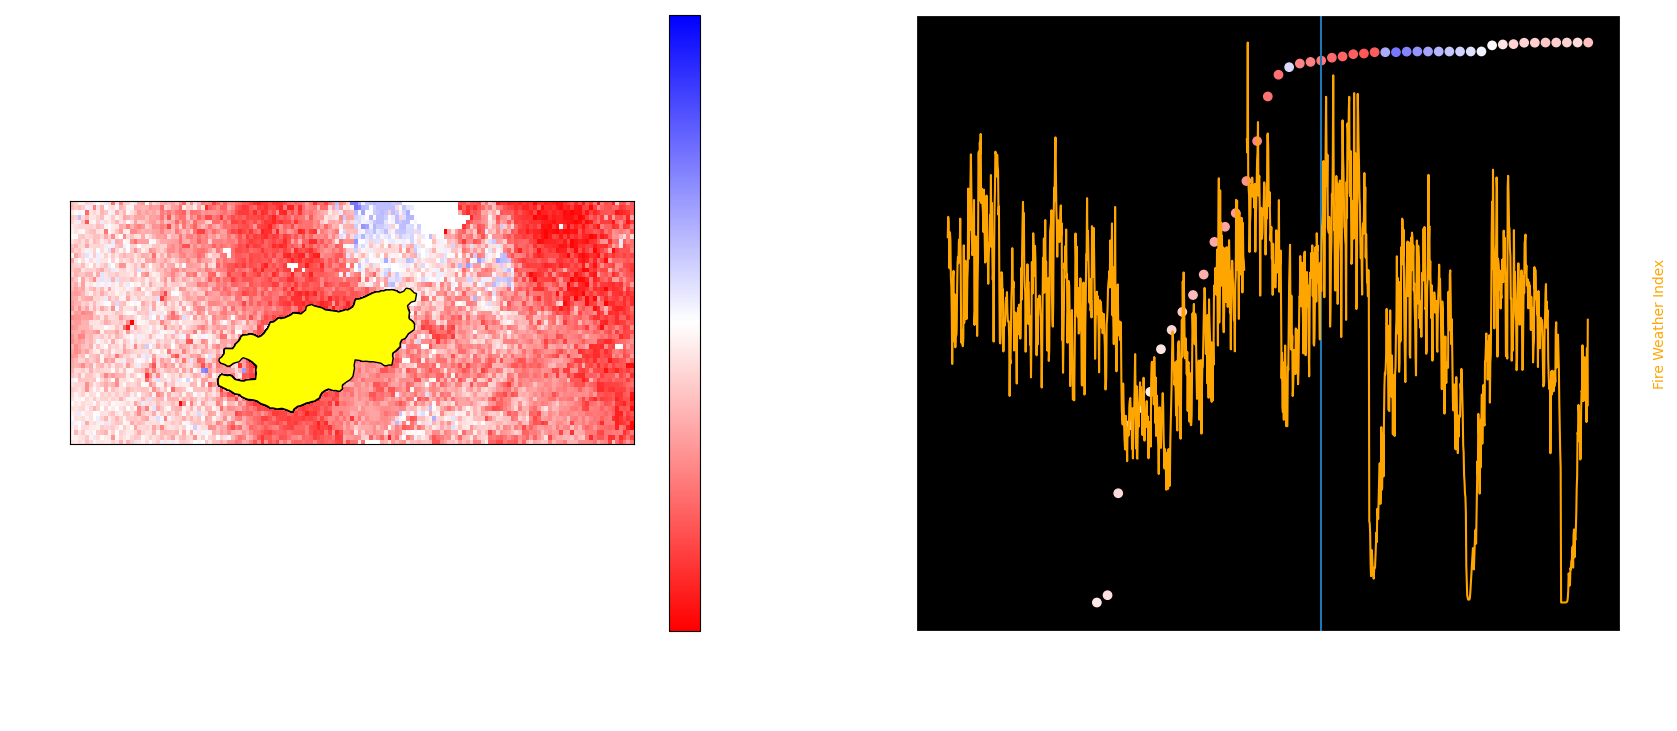

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


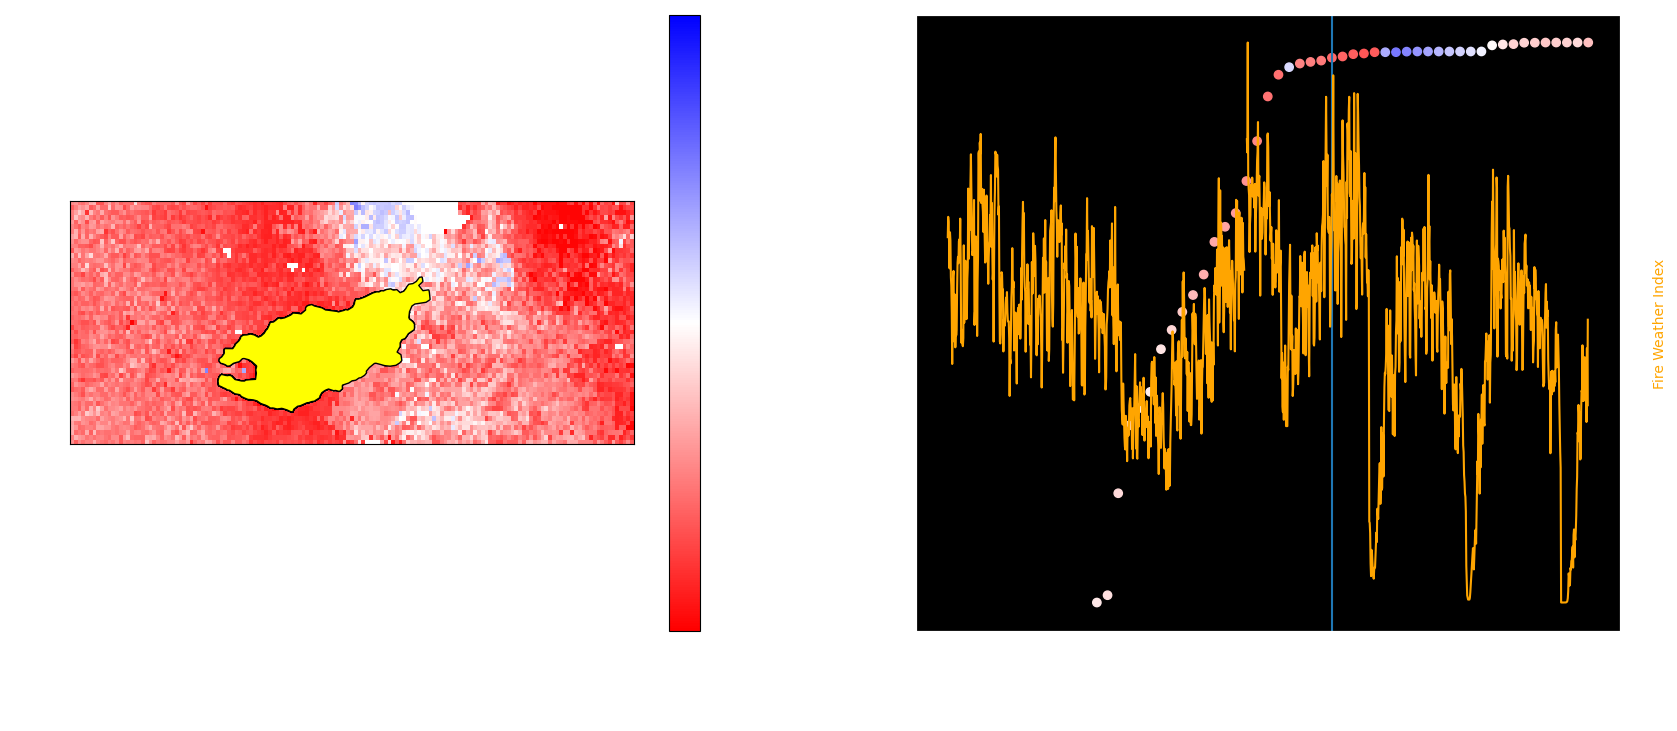

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


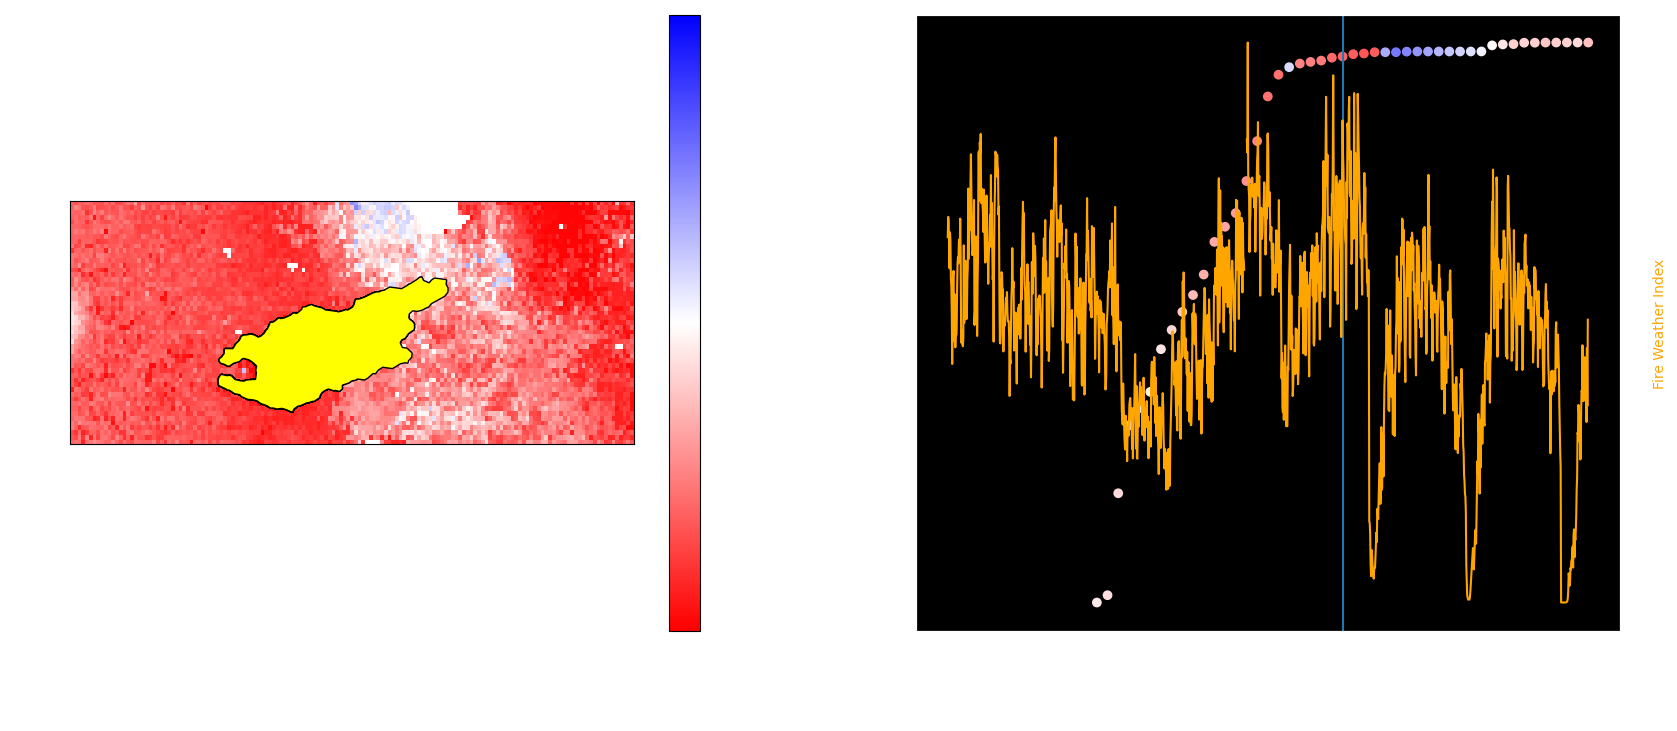

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


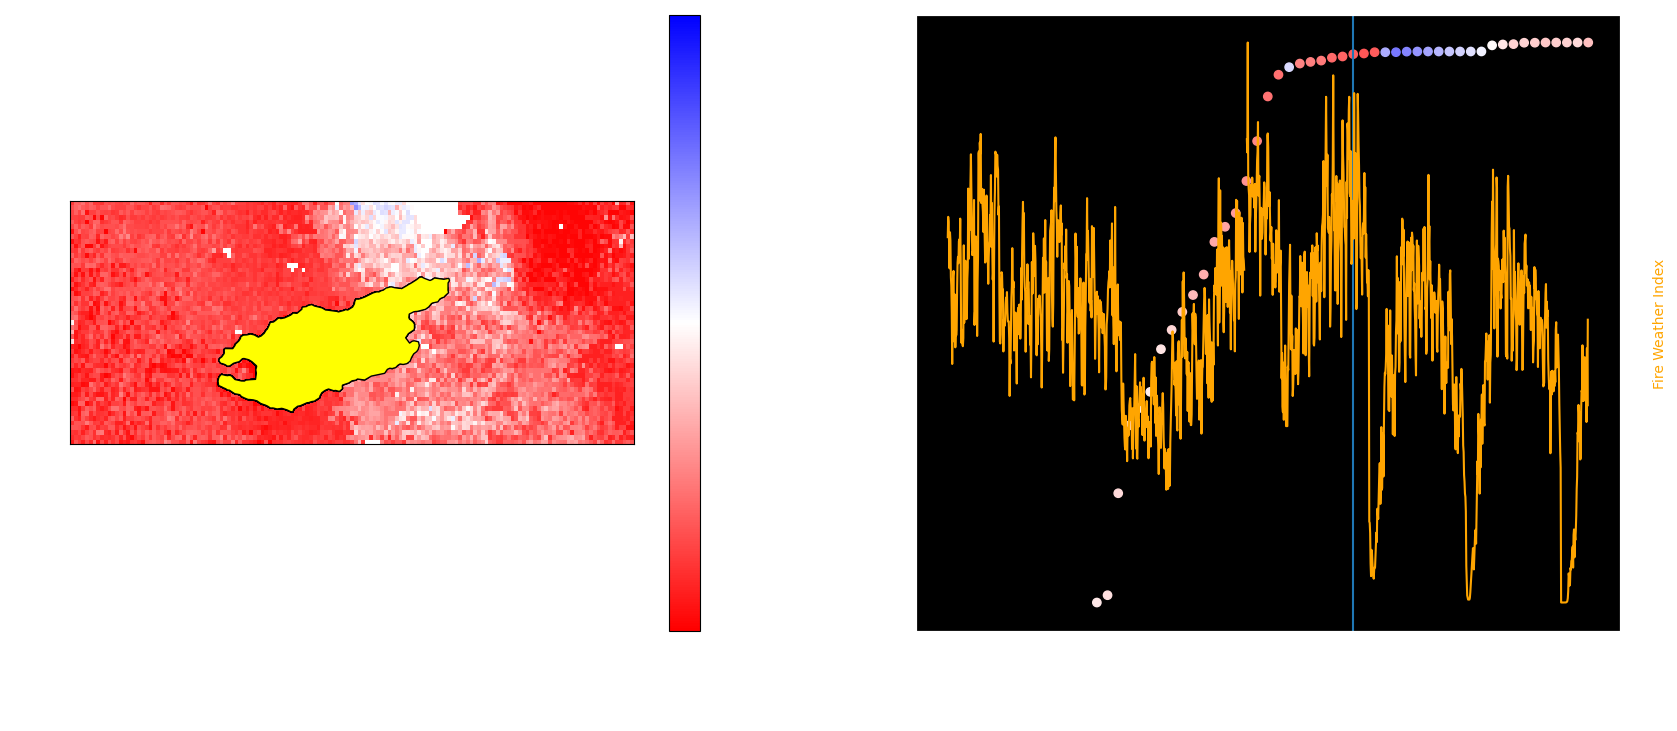

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


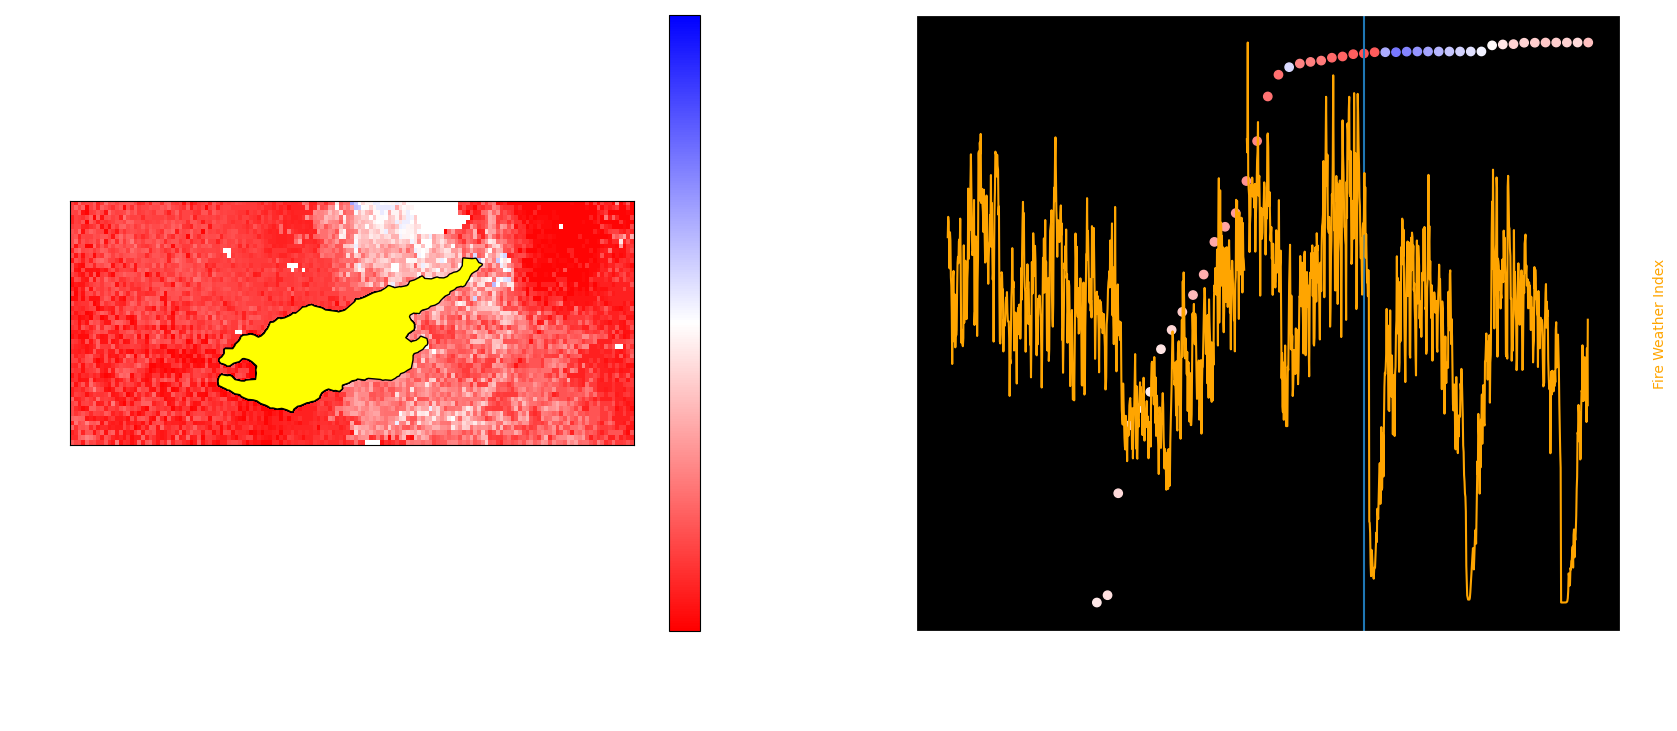

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


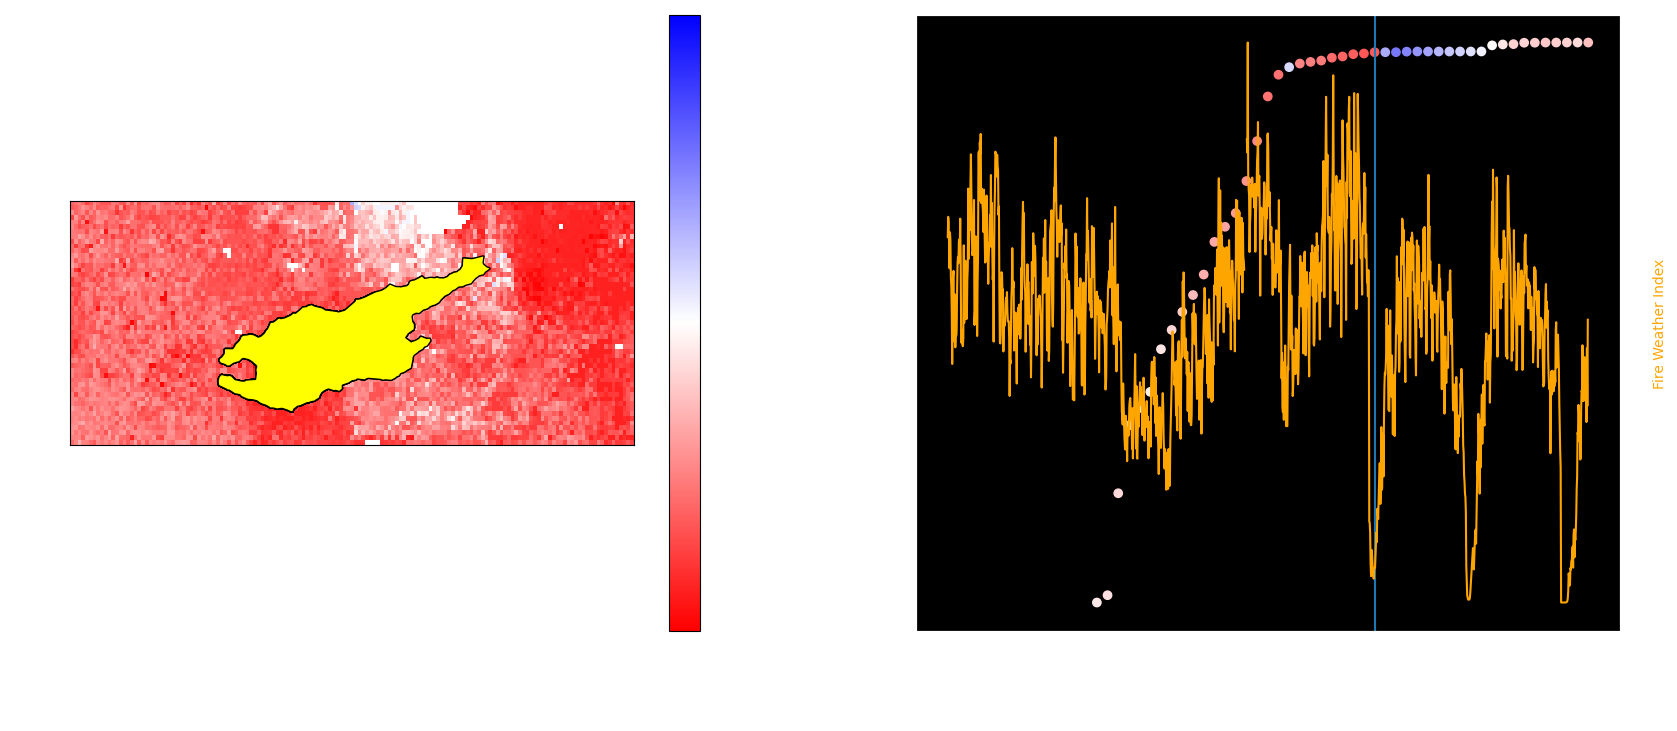

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


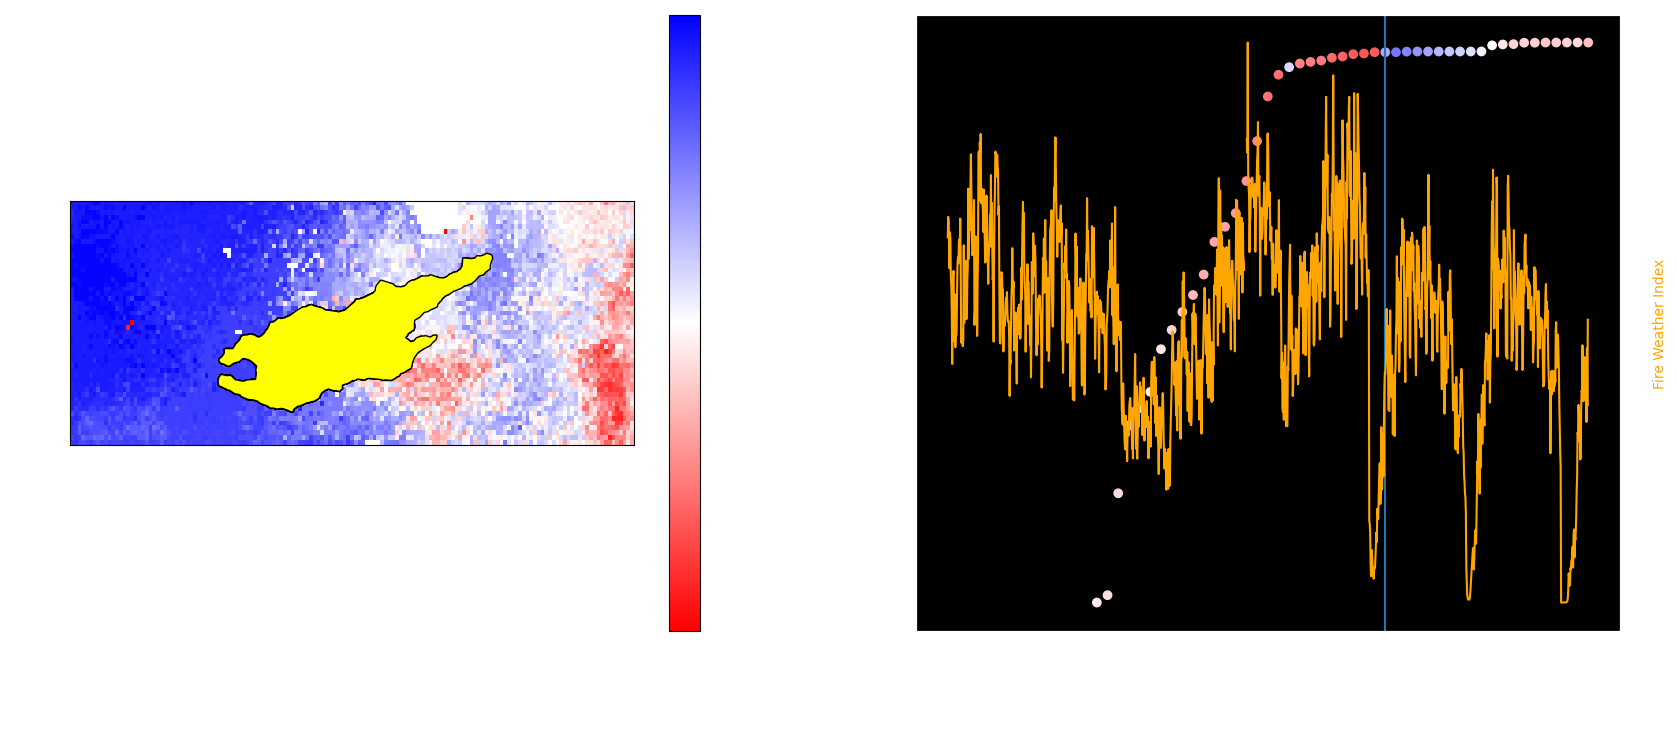

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


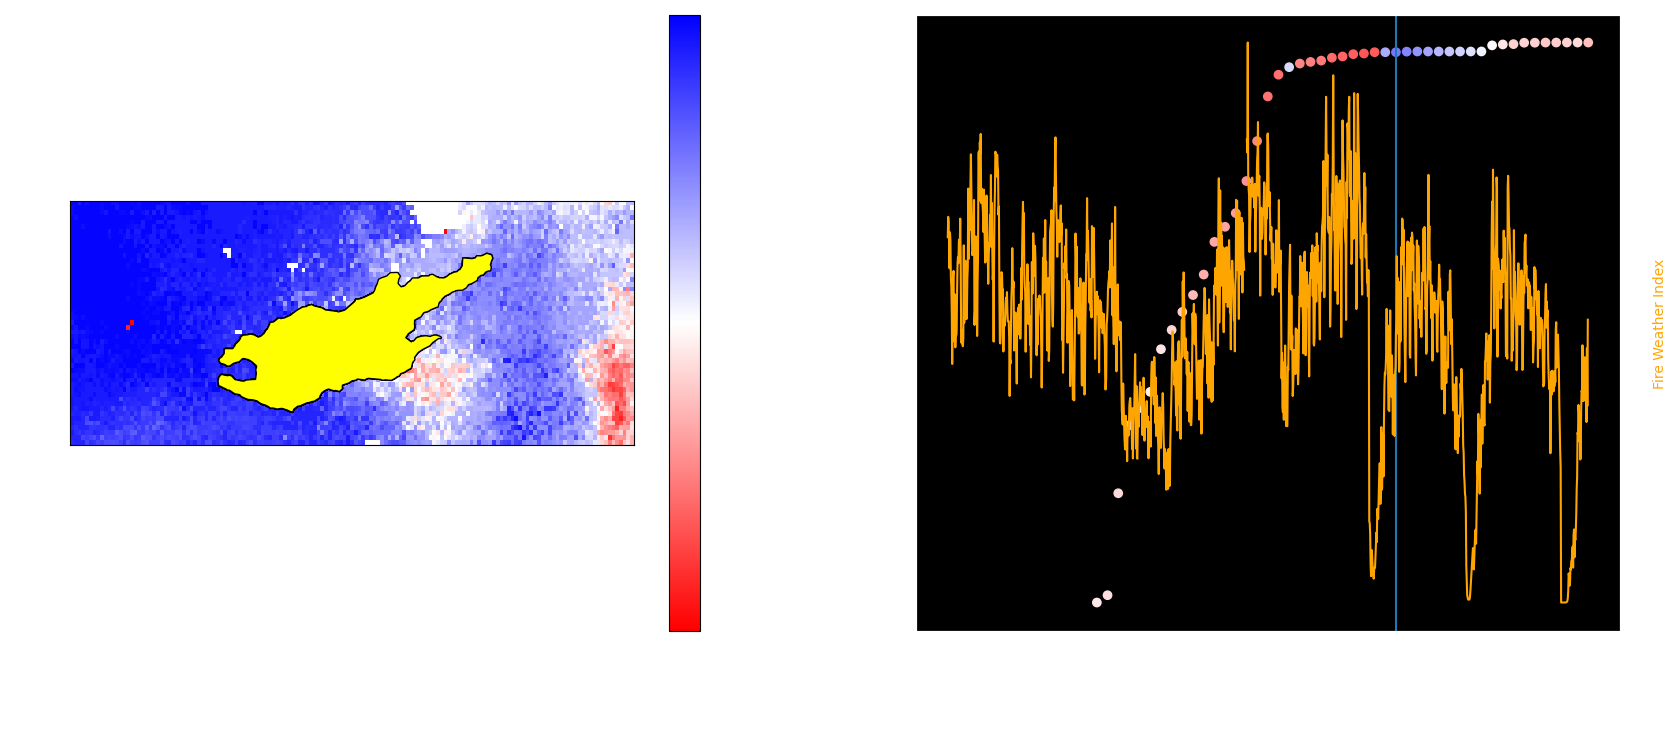

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


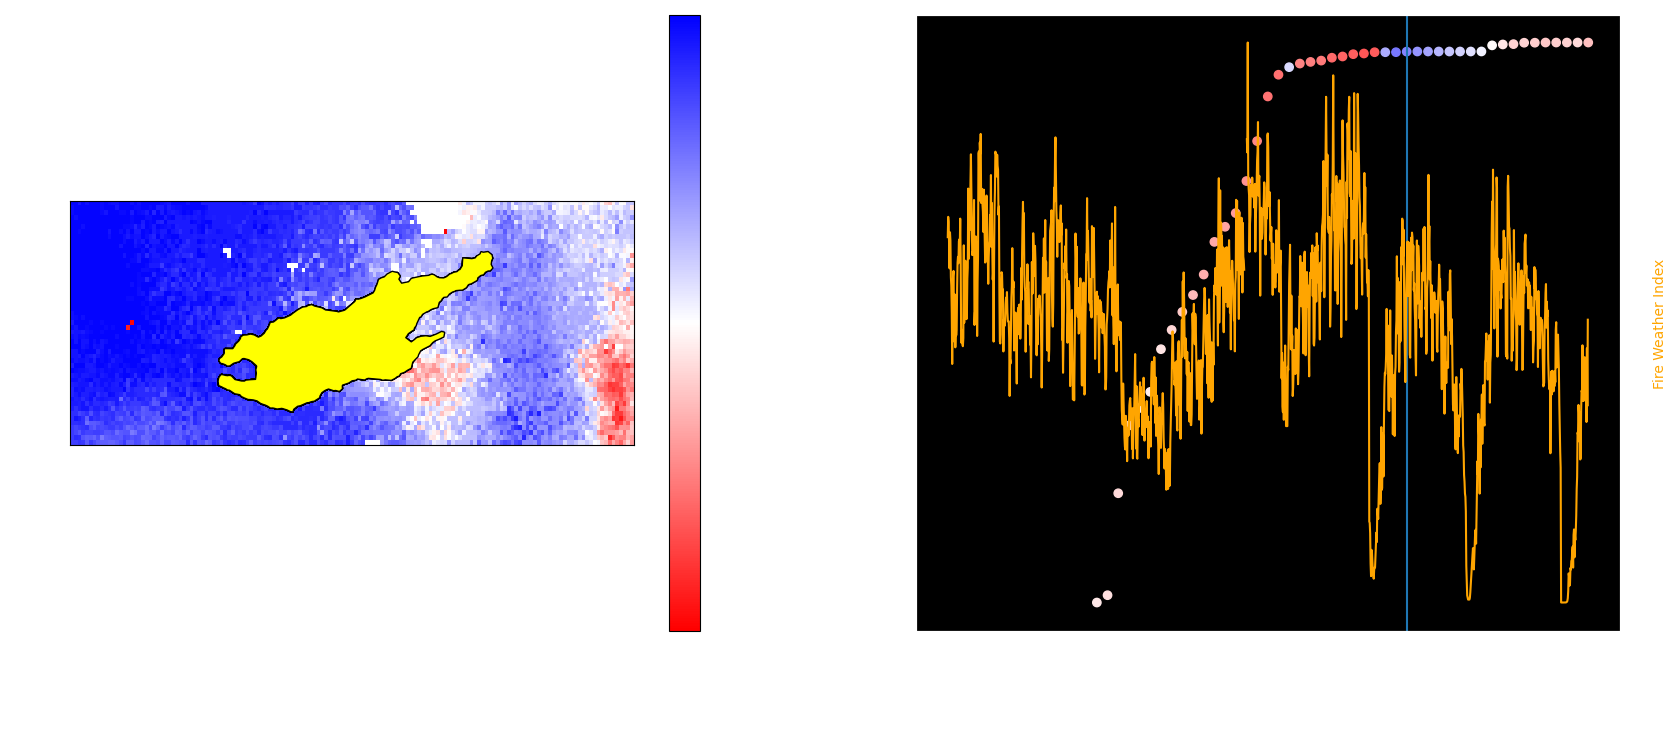

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


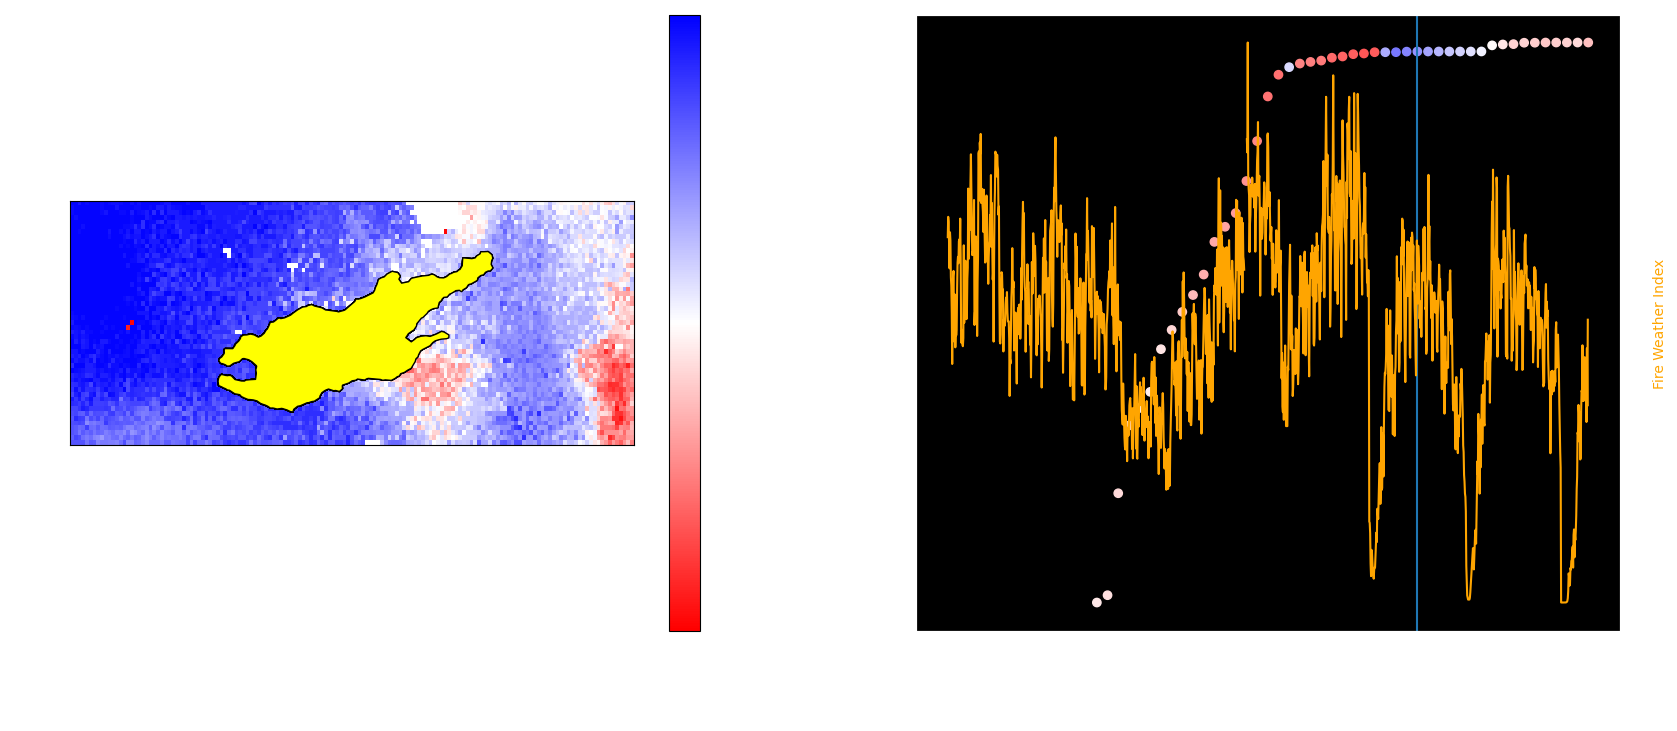

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


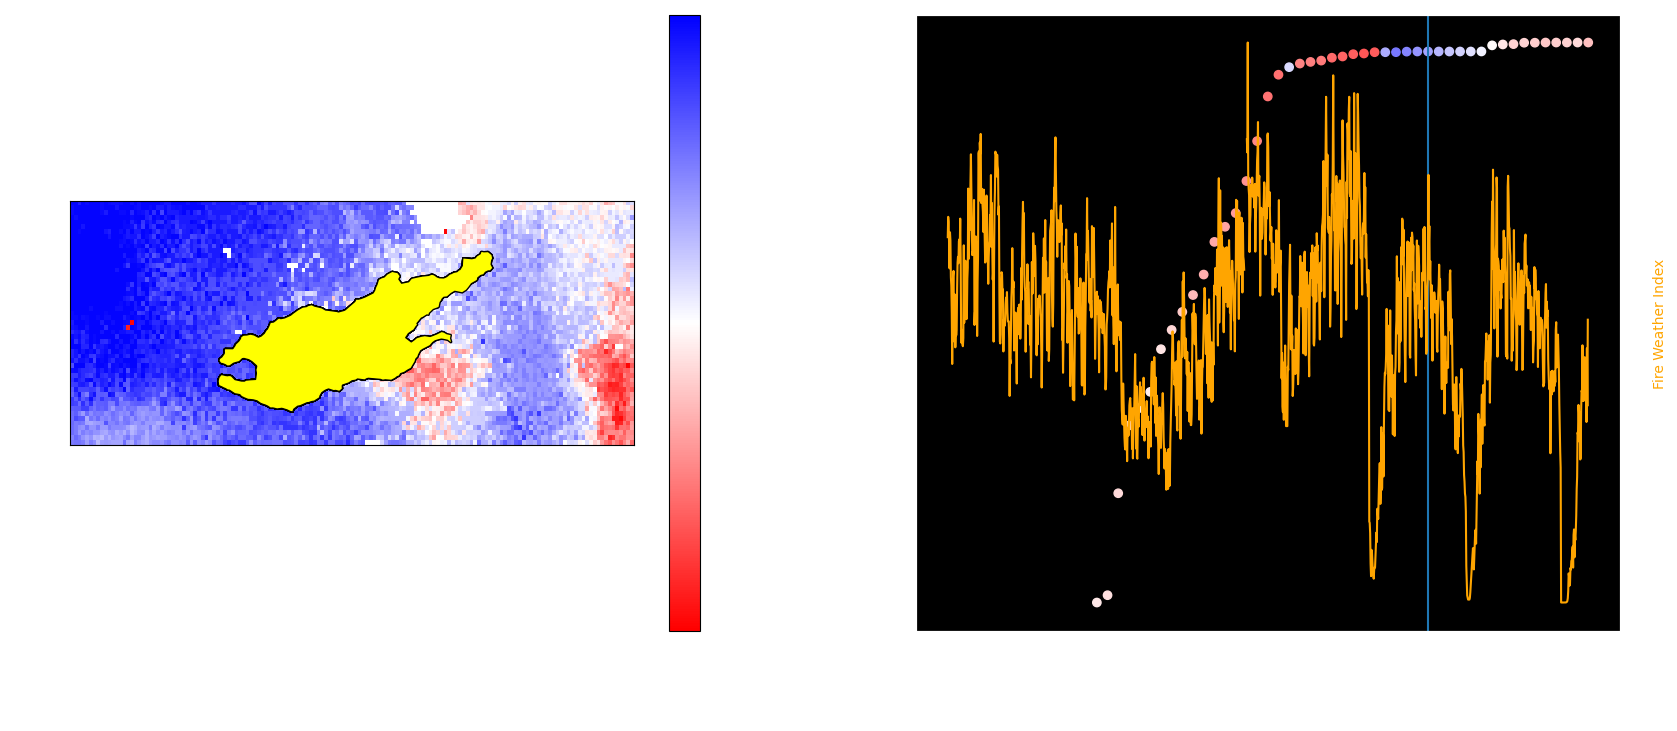

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


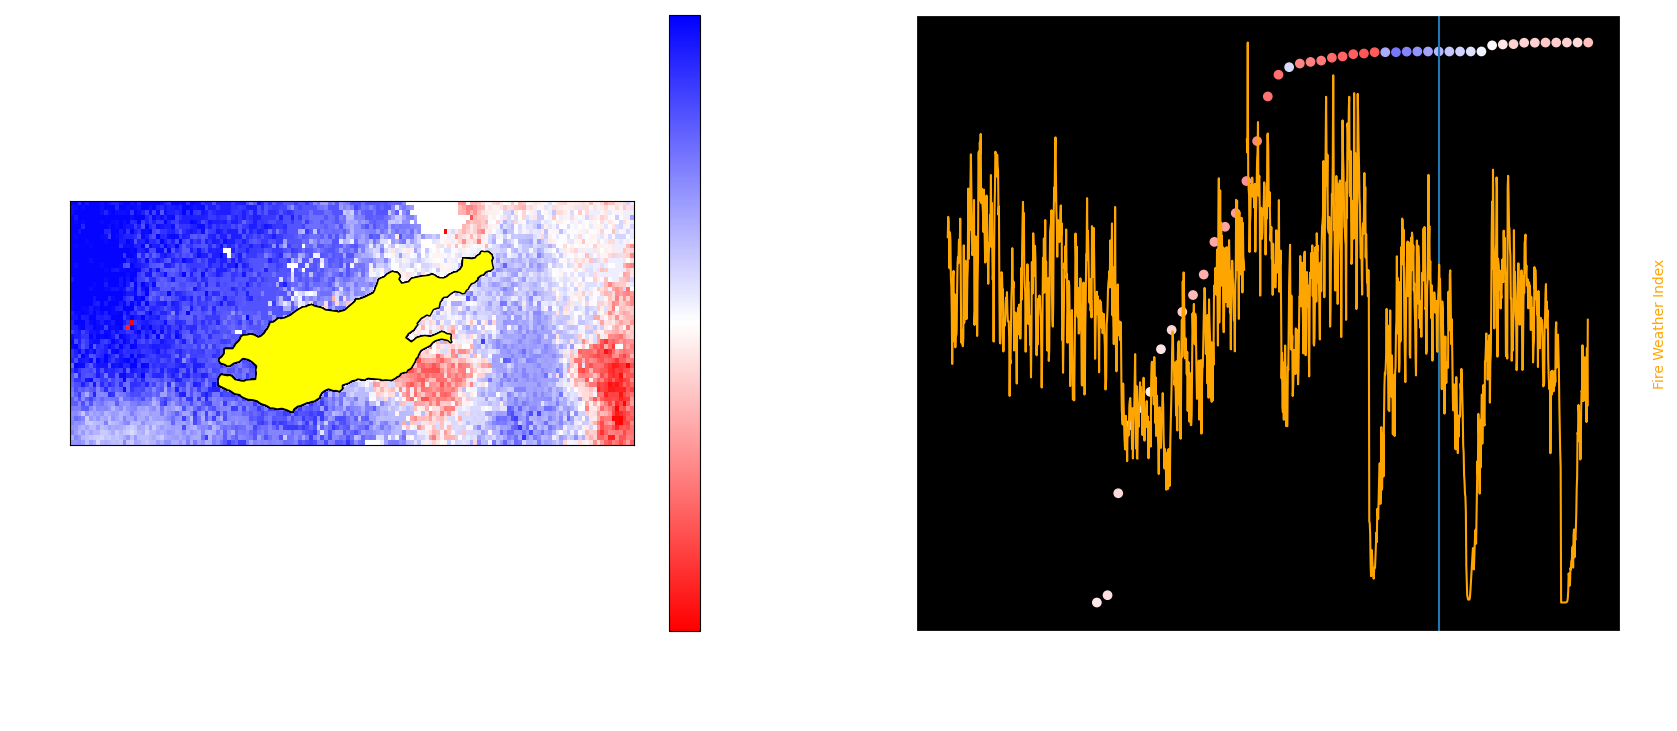

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


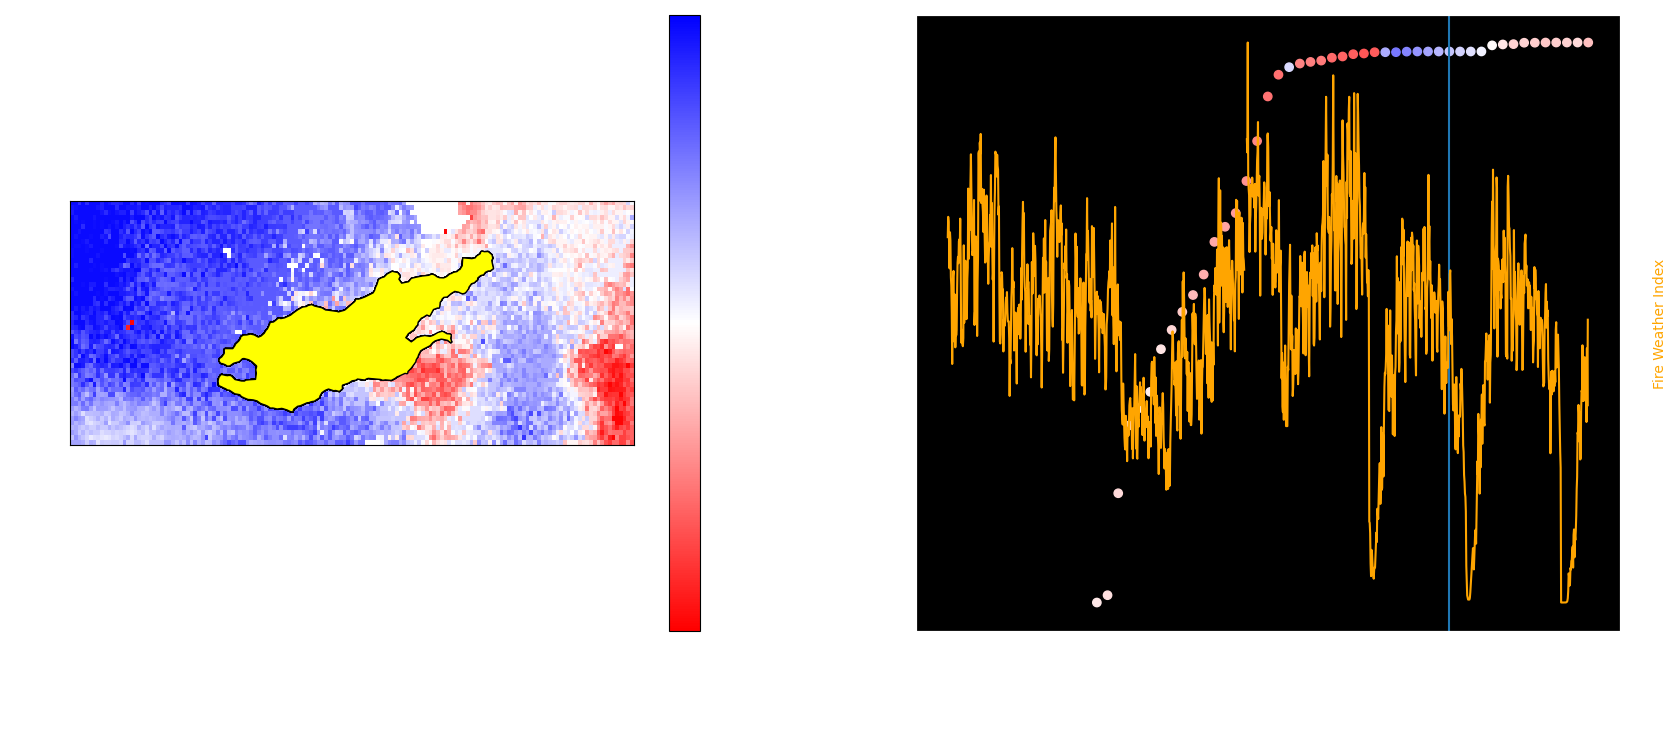

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


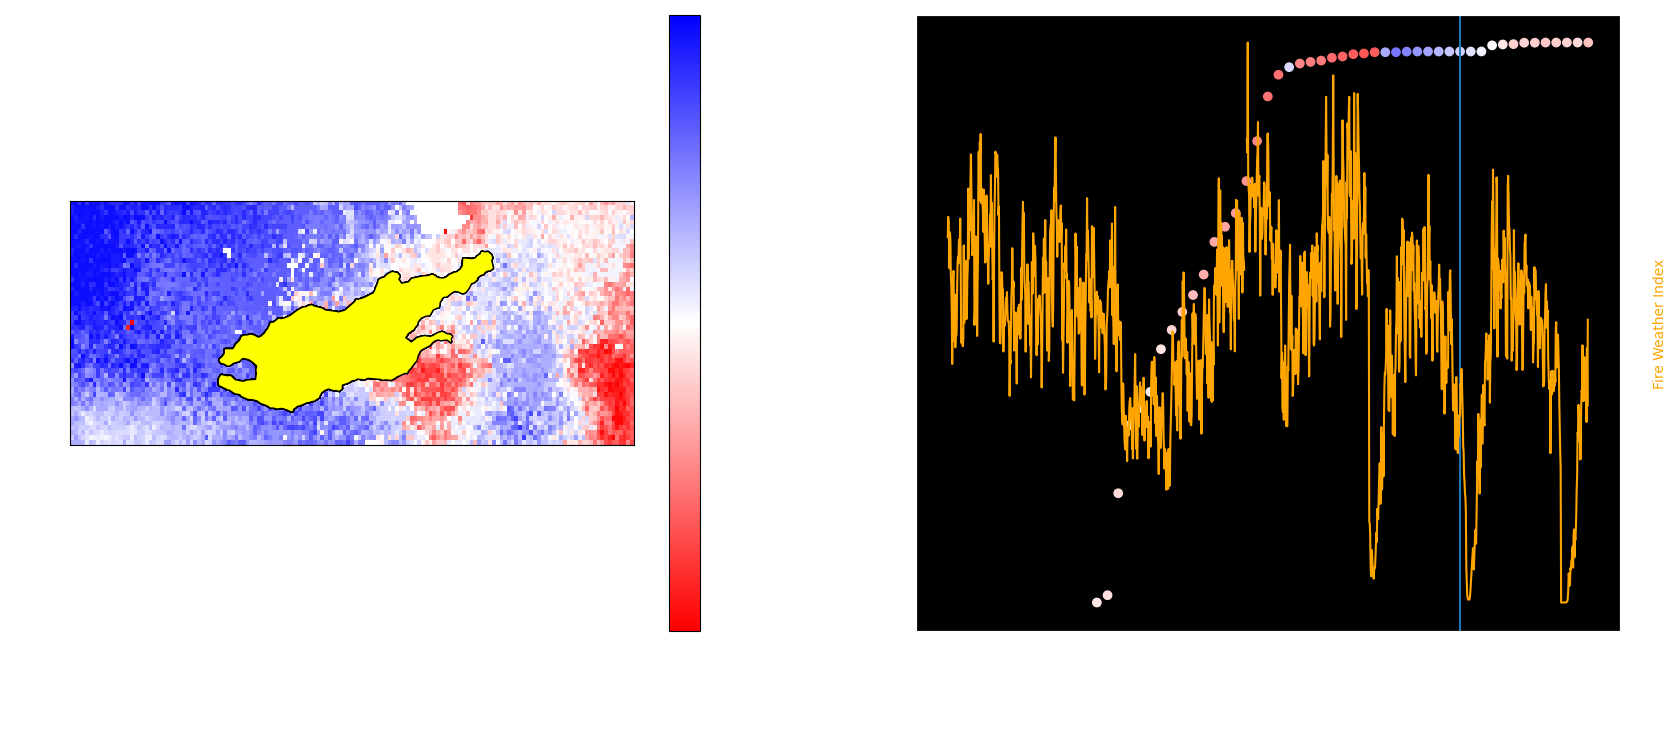

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


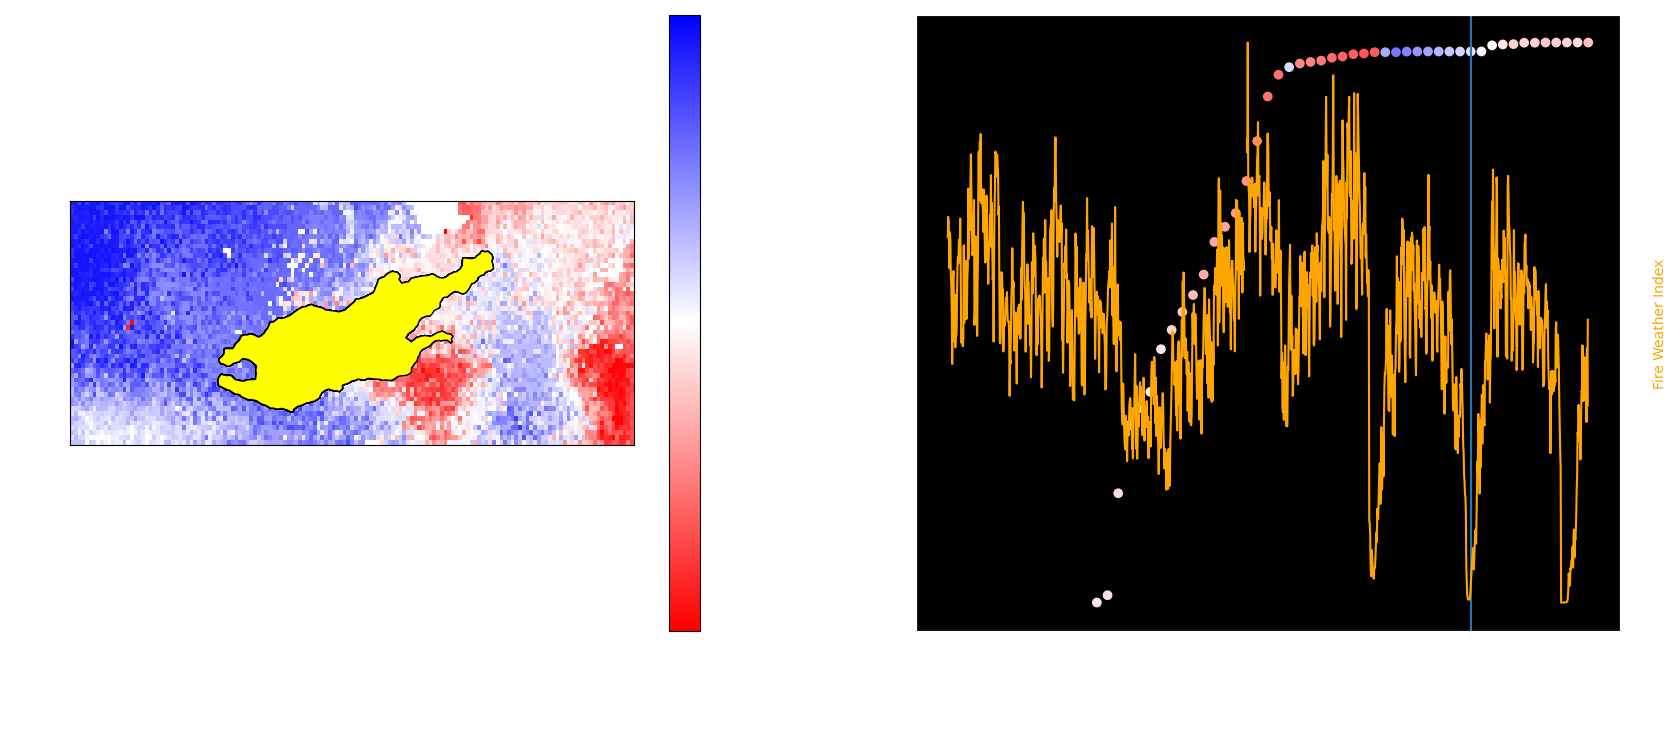

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


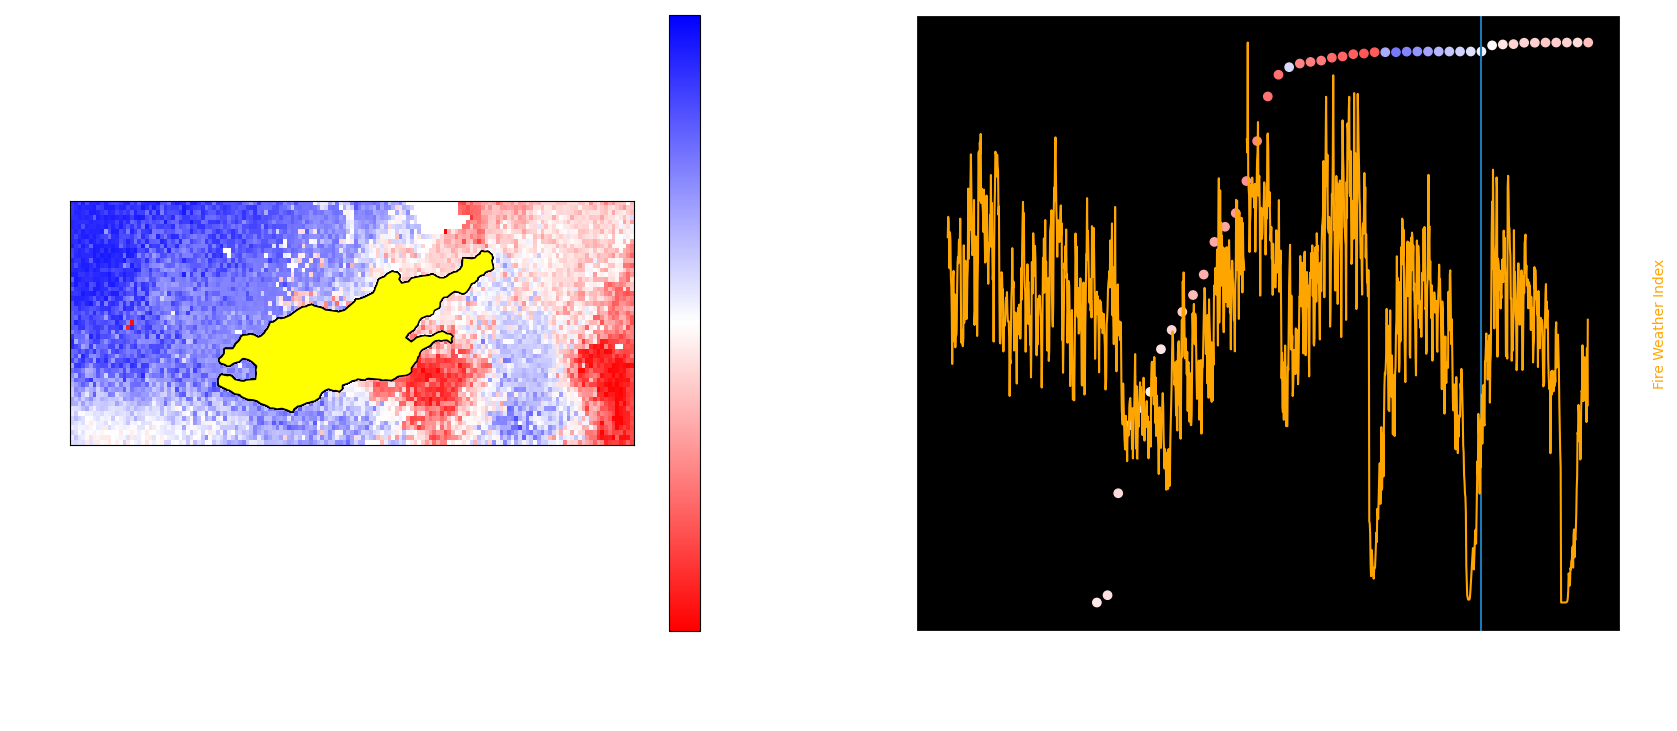

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


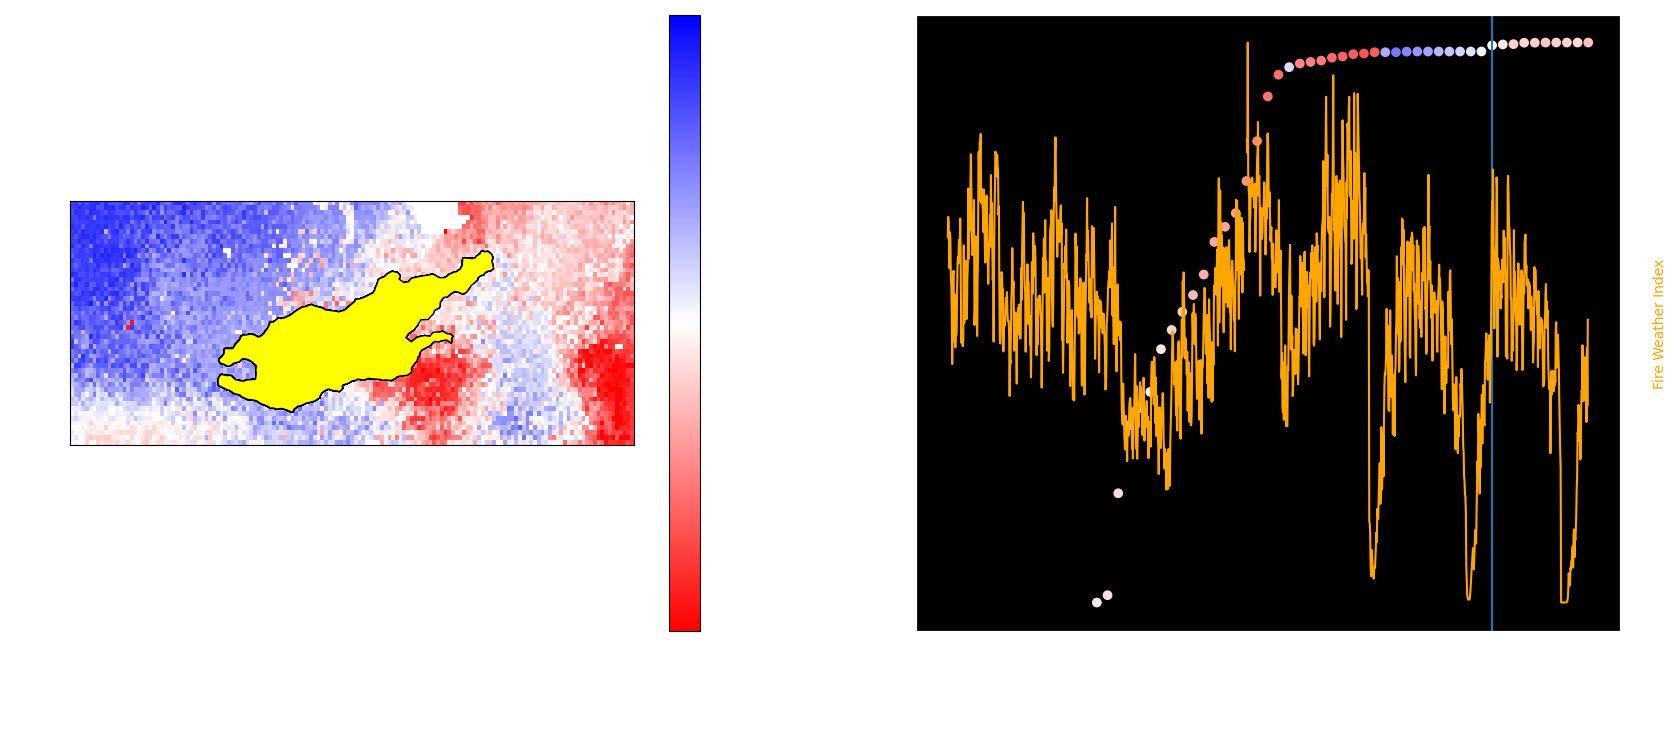

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


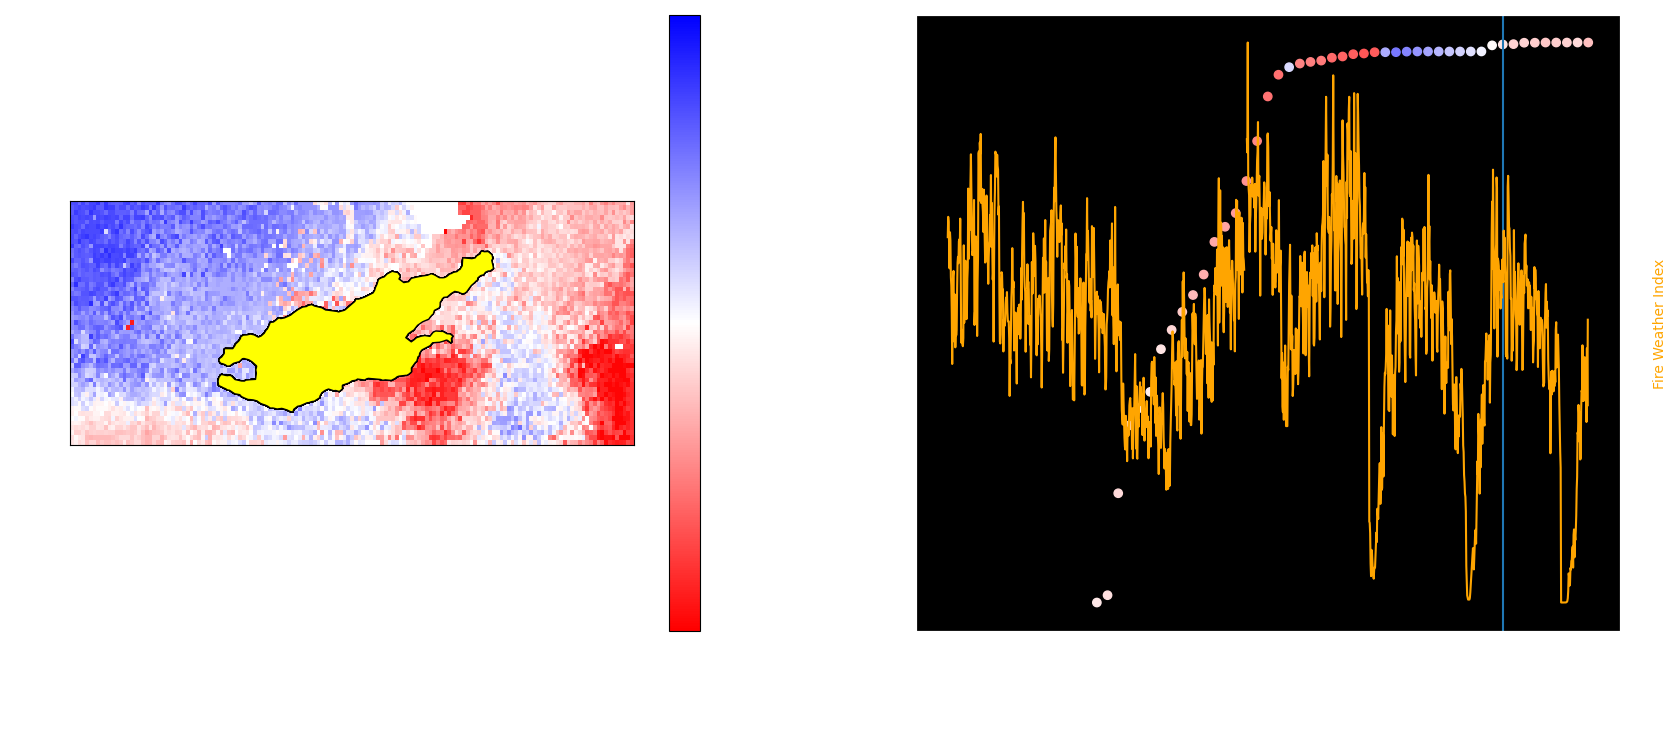

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


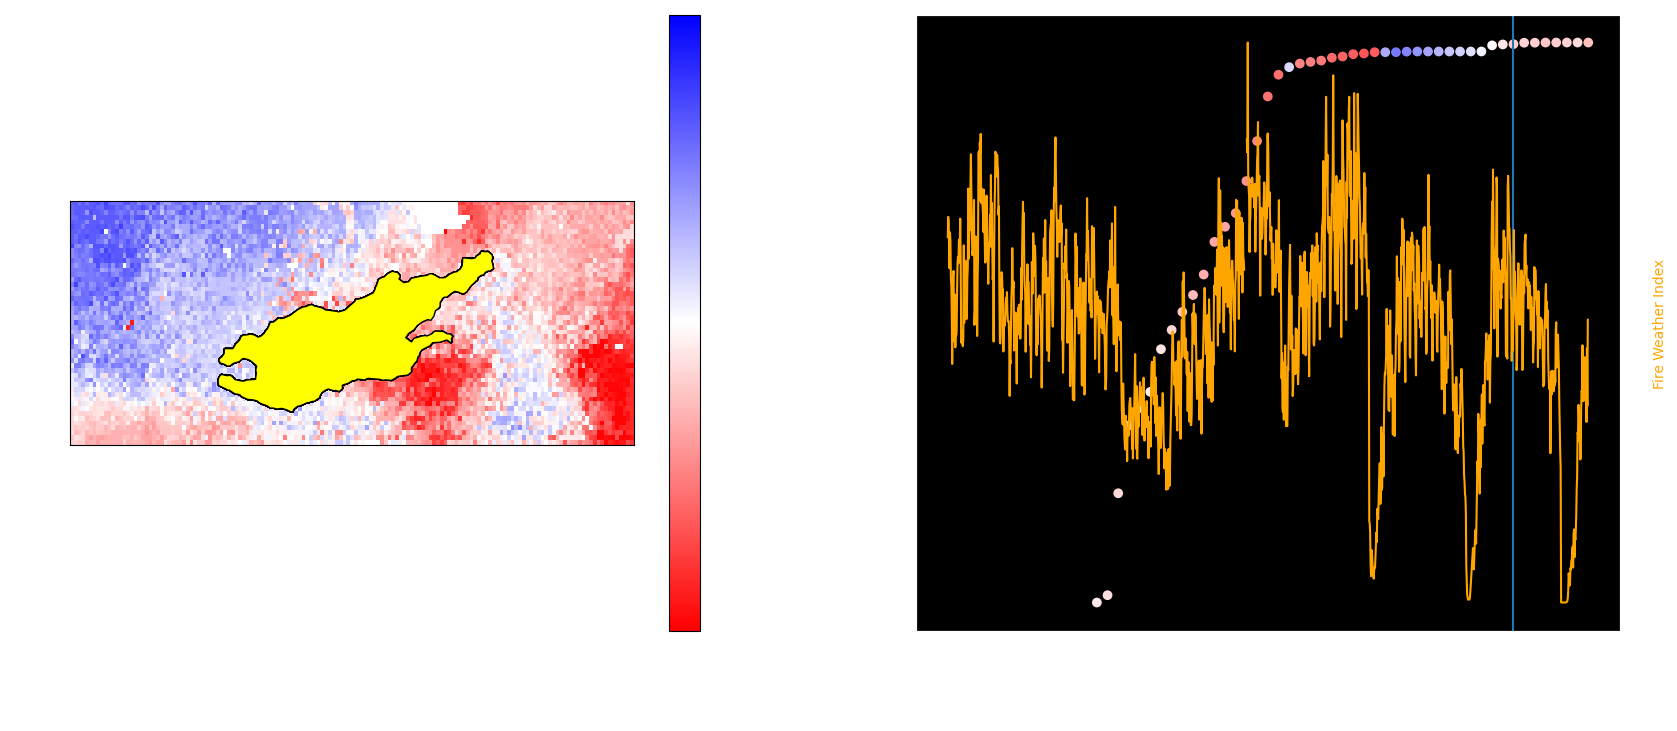

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


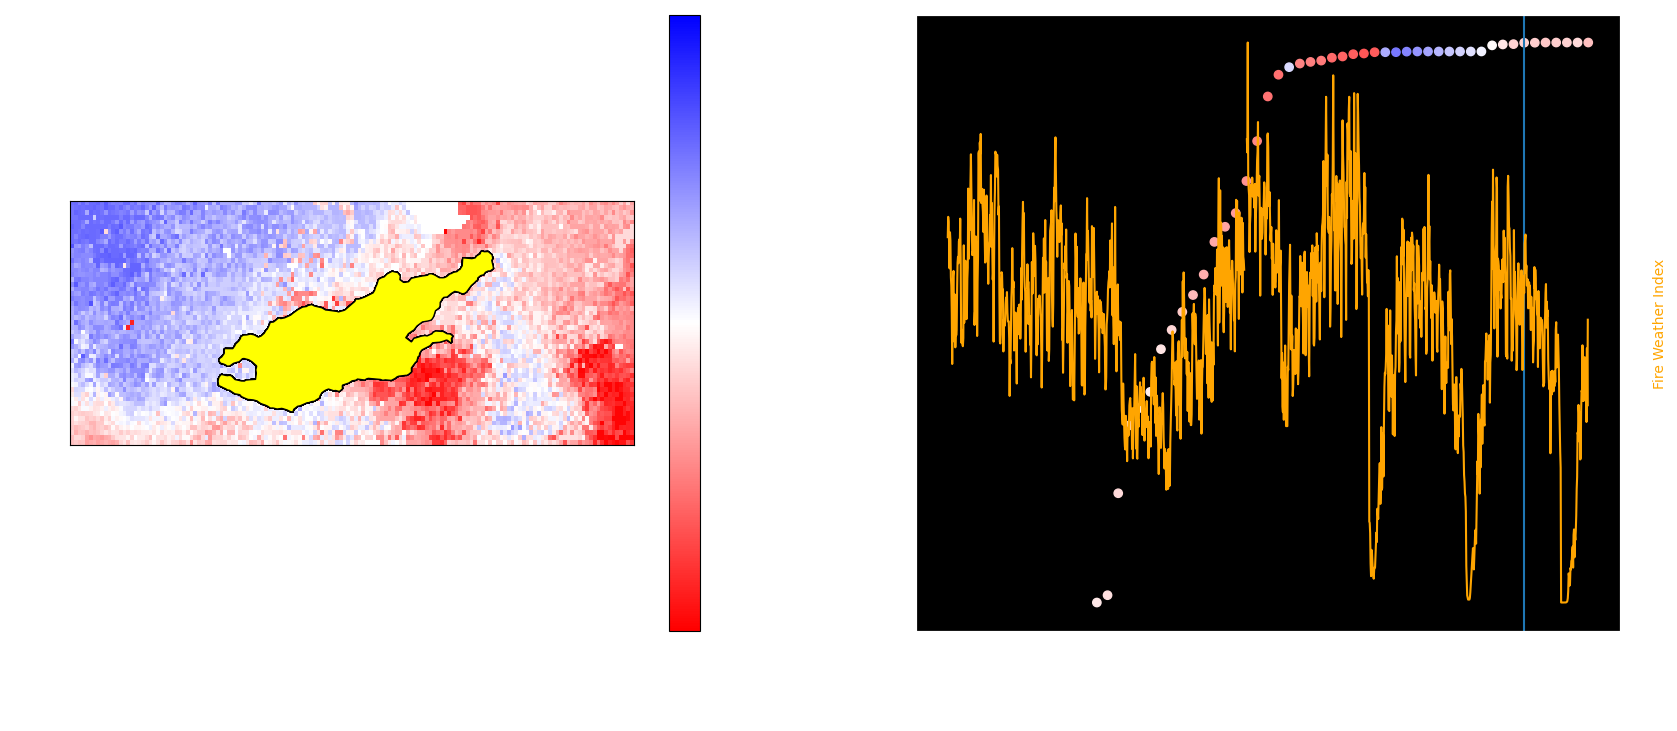

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


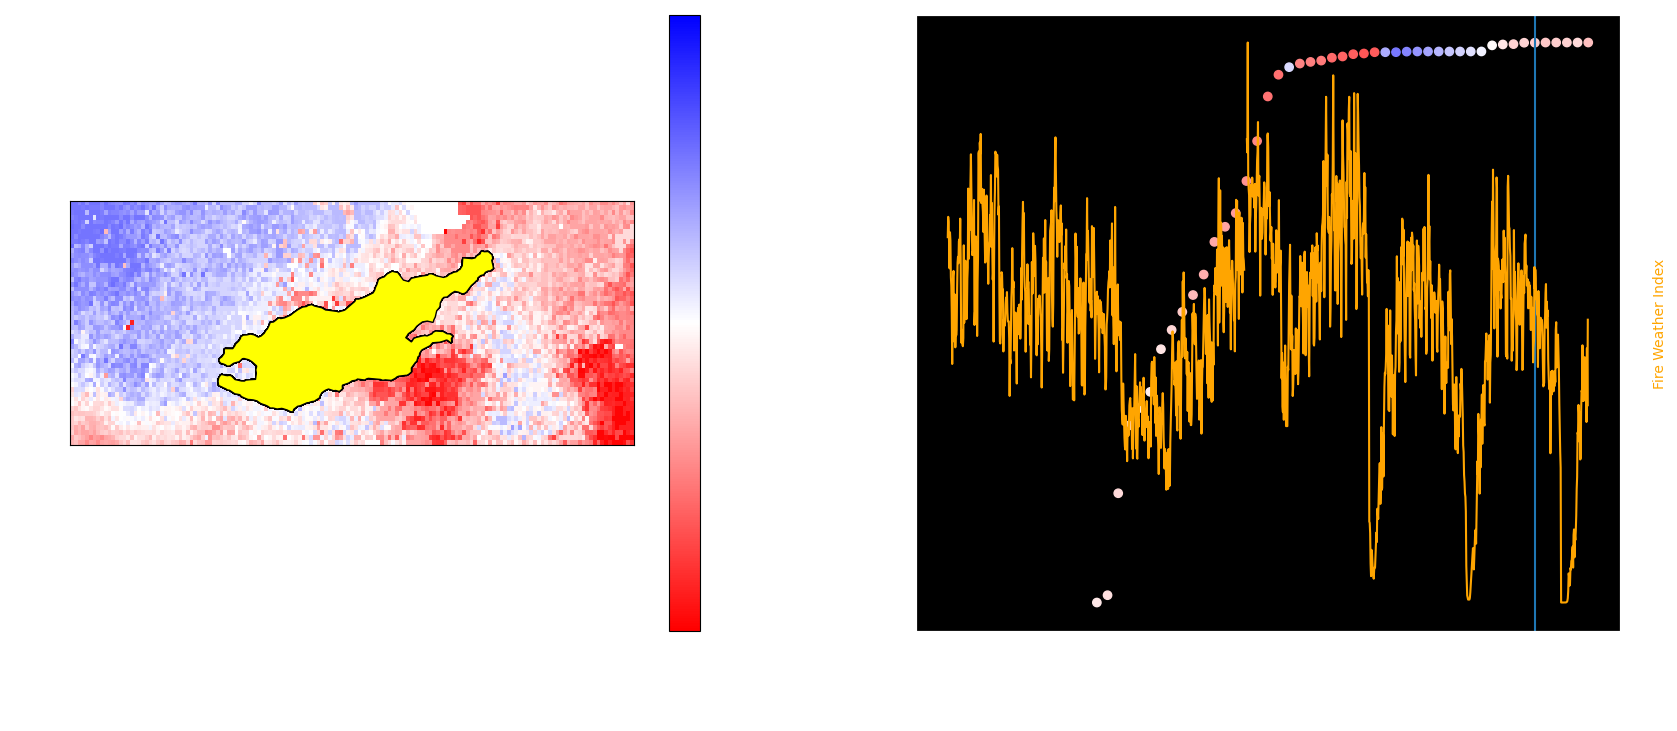

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


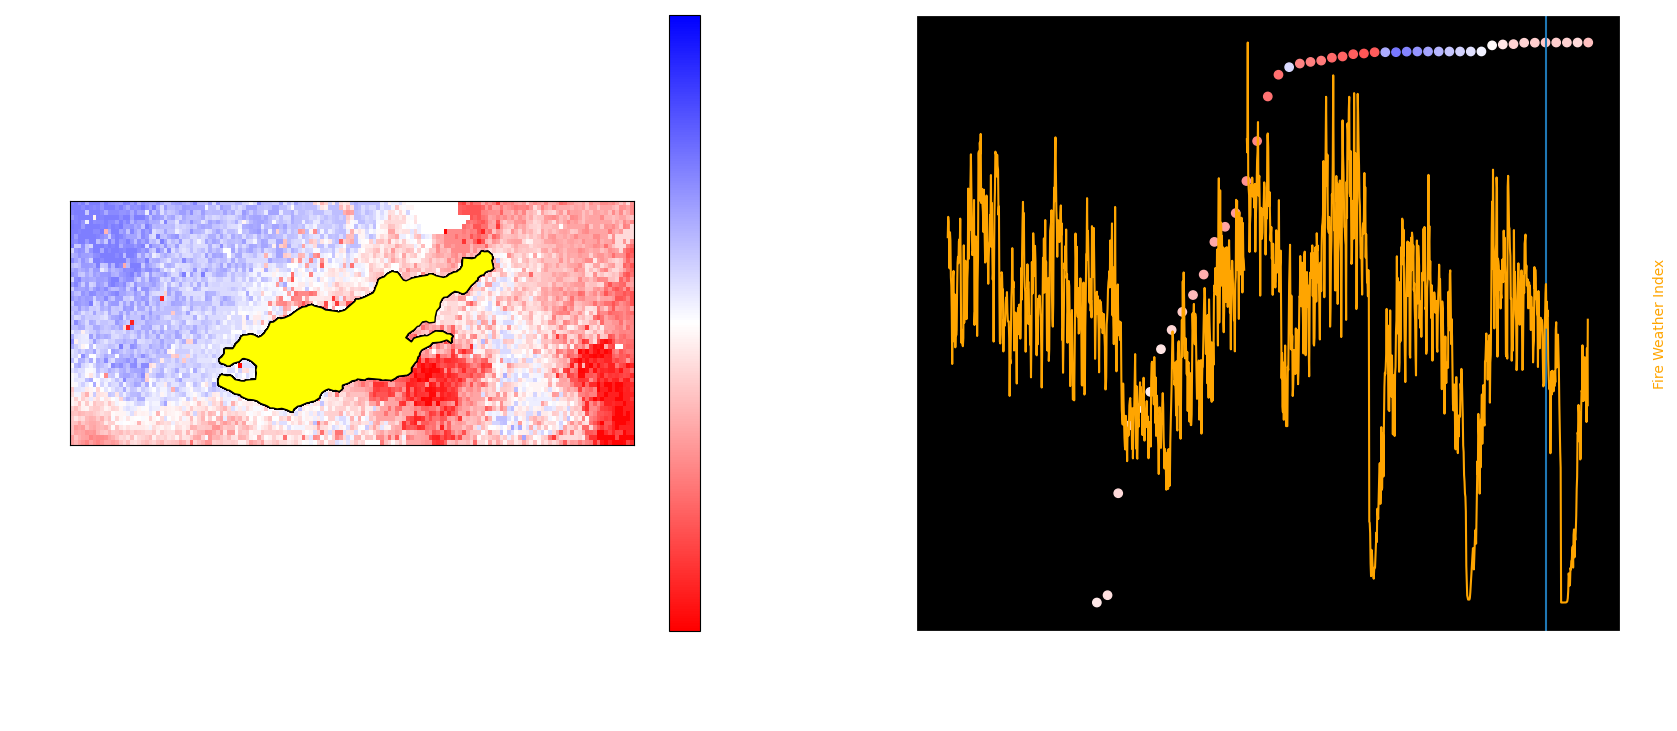

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


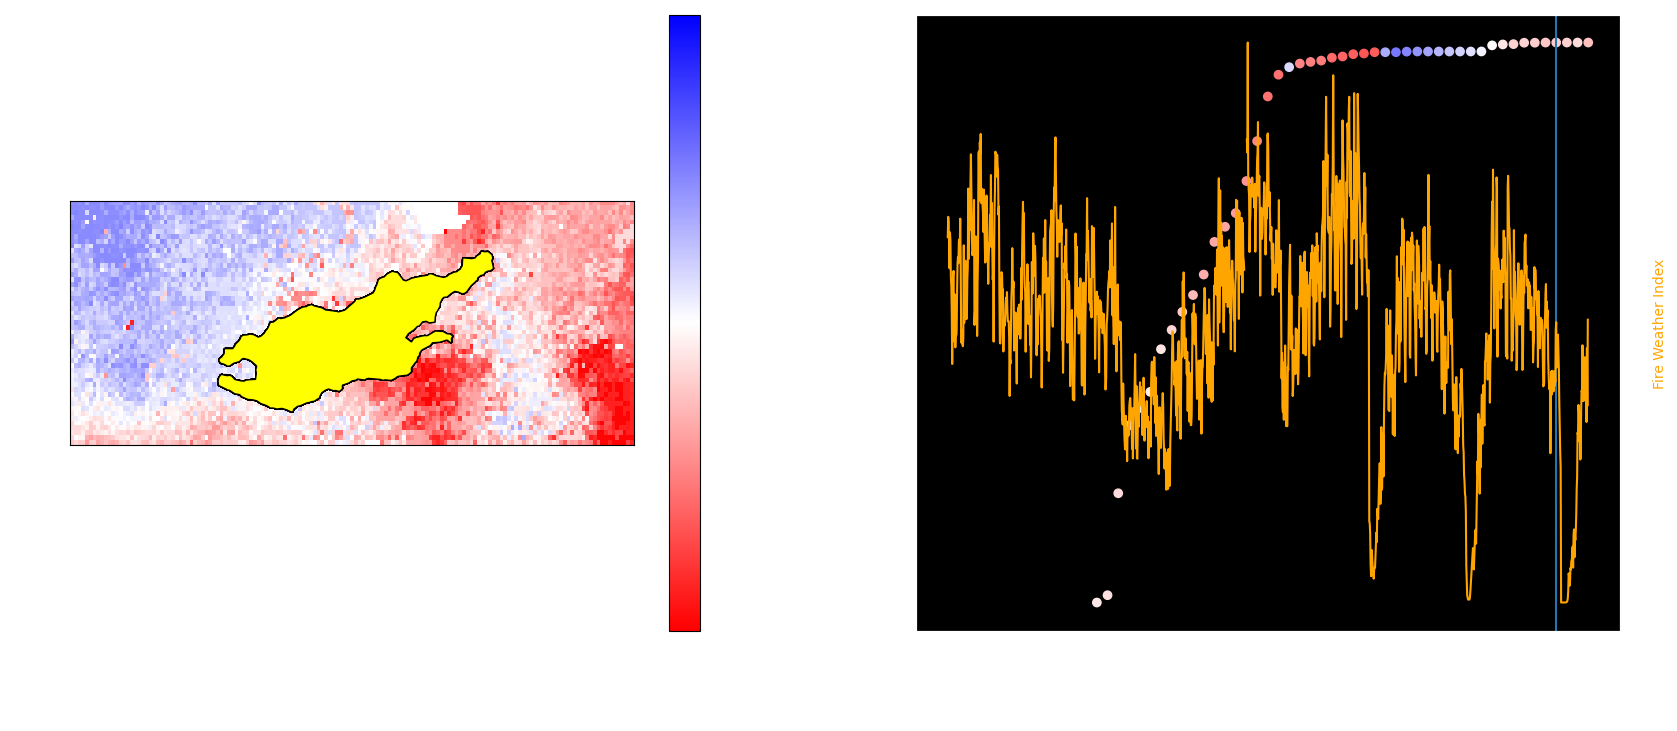

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


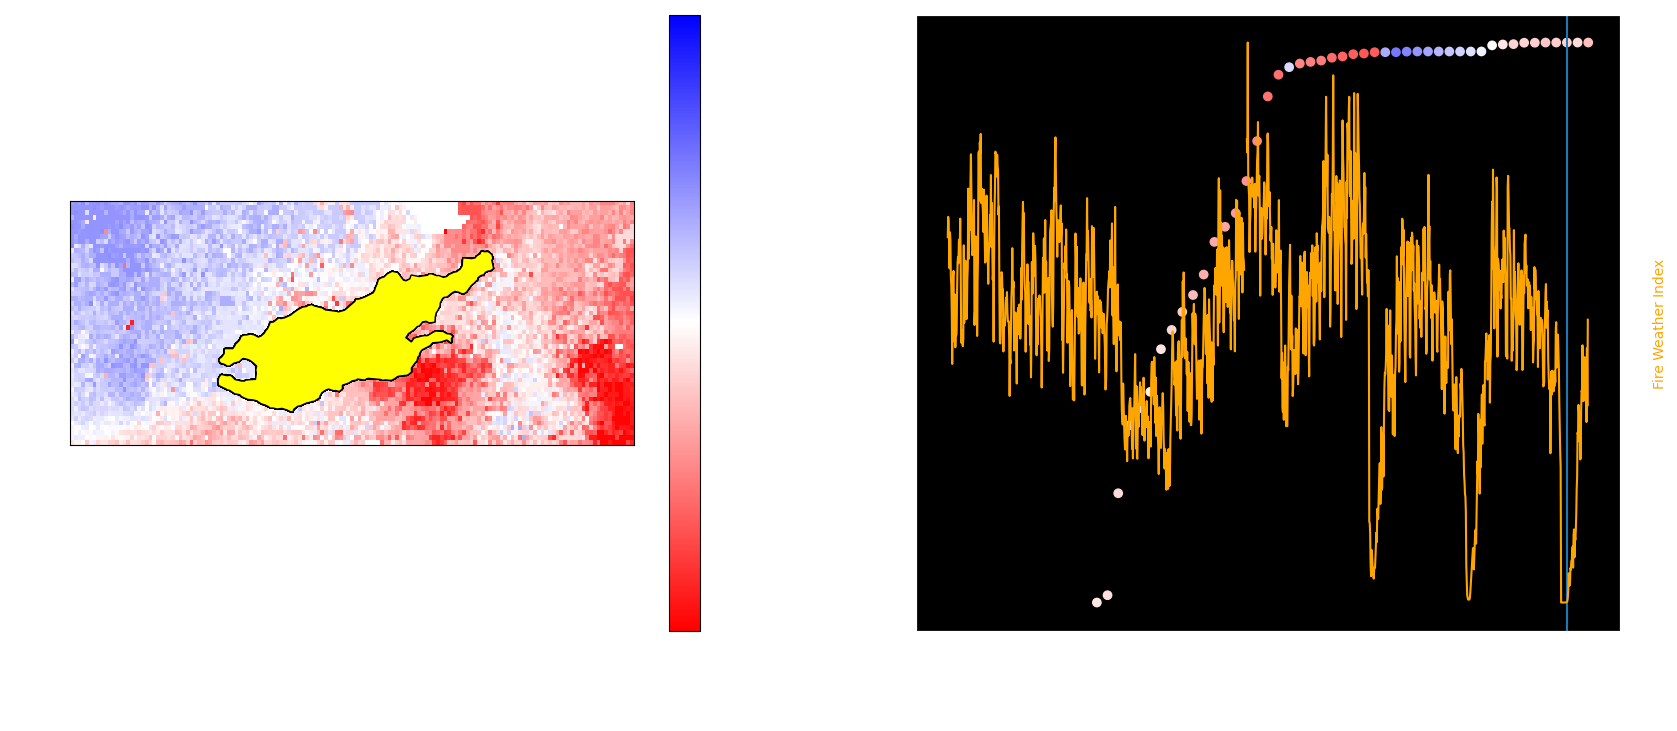

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


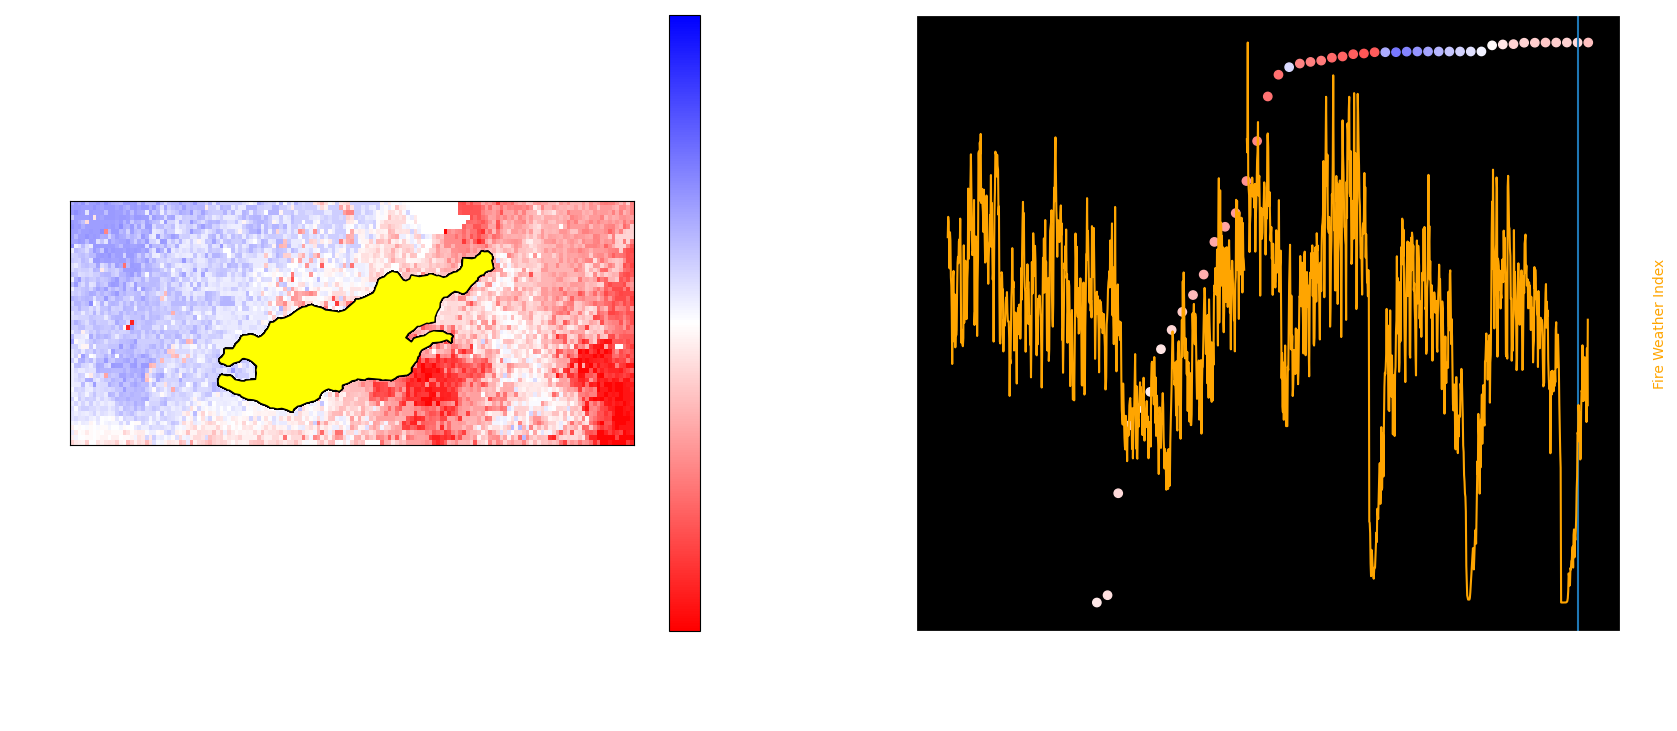

/tmp/ipykernel_28903/3552160082.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")


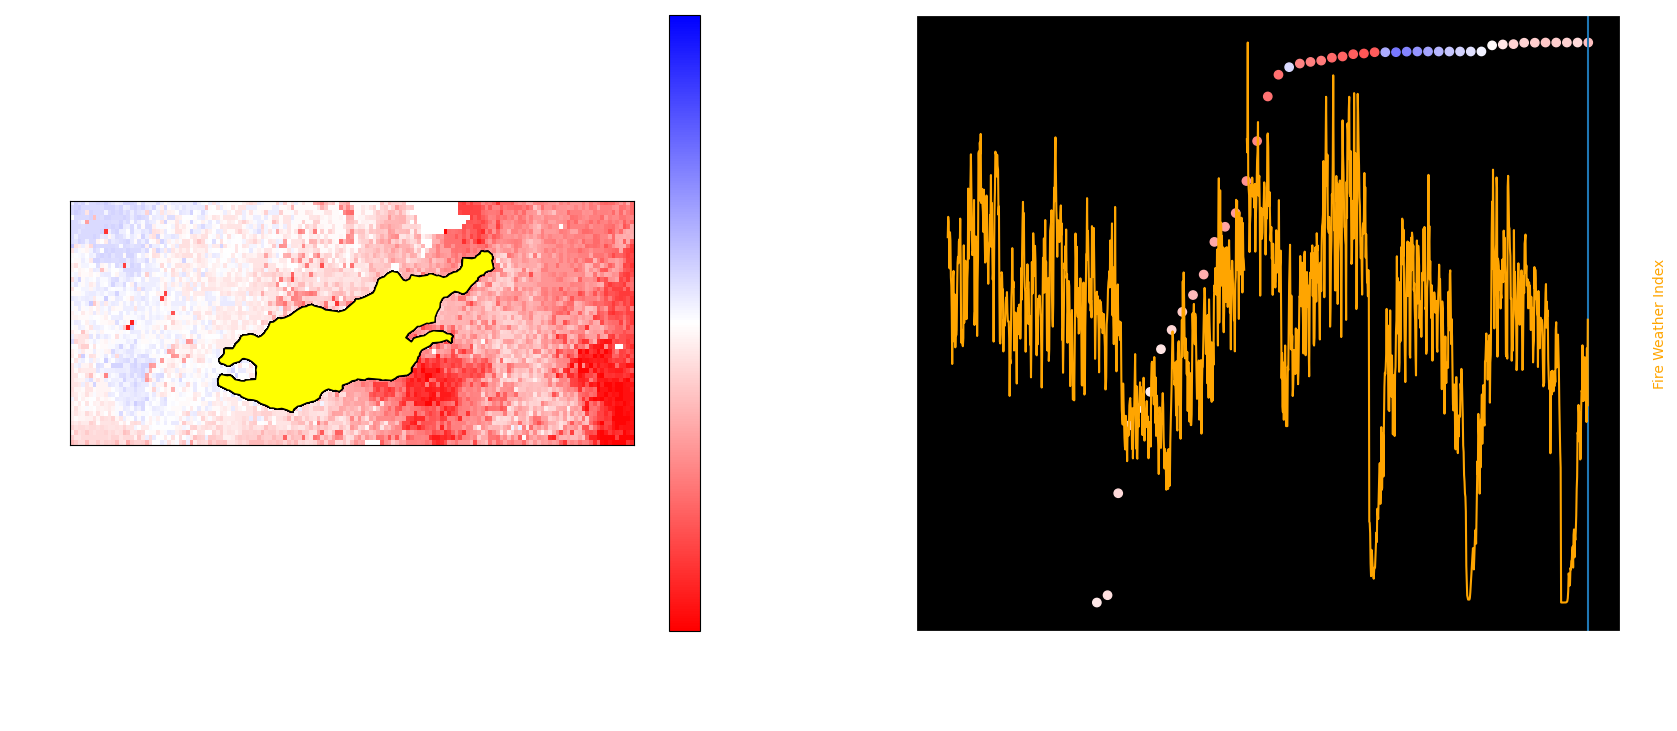

In [88]:

len_days = len(dates)
for i in range(1, len_days):

    ## Static Plot with Doug's feedback
    f, (ax3, ax) = plt.subplots(1, 2, figsize=(20,8))
    
        ## Adding the raster
    root_moist = xr.open_rasterio("s3://veda-data-store-staging/EIS/COG/LIS_WEST_US_DA/RZSM/Percentile_TS." + dates[i] +"0000.d01.cog")
    subset = root_moist.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    subset.plot(ax = ax3, cmap = "bwr_r", vmin = 0, vmax = 1, label = "Soil Water Percentile")
    #ax.set_xlable("Longitude")
    #ax.xlable("Longitude")
    #sub_plot = ax.plot(subset, cmap = "bwr_r", vmin= 1, vmax = 1)
    #if(i <= 6):

    gdf[d0:i].plot(ax=ax3, facecolor="none", edgecolor='none')
    
    if(i > 6):
        index = i - 6
        gdf[d0:index].plot(ax=ax3, facecolor="yellow", edgecolor='black') #facecolor="None"
    #ax.xlable("Longitude")
    ax3.set_ylabel("Latitude", color = "white")
    ax3.set_xlabel("Longitude", color = "white")
    ax3.set_title("Soil Water Percentiles", color = "white")
    #ax.spines["bottom"].set_color('white')
    #ax.spines["top"].set_color('white')
    #ax.spines["left"].set_color('white')
    #ax.spines["right"].set_color('white')
    #ax.xaxis.label.set_color('white')
    #ax.tick_params(colors='white')
    #plt.savefig(fname = (""+ m + "_vs_" + f+".pdf"))
    params = {"text.color" : "white",
          "xtick.color" : "white",
          "ytick.color" : "white"}
    plt.rcParams.update(params)
    if(i < 10):
        i_write = "0" + str(i)
    else:
        i_write = str(i)

    ax.scatter(y = full_fr.farea, x = full_fr.t, c  = full_fr.mean_sw_x, cmap  = "bwr_r", vmin = 0, vmax = 1)
    ax.set_facecolor("black")
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_ylabel("Fire Area km^2",color="white")
    ax.spines["bottom"].set_color('white')
    ax.spines["top"].set_color('white')
    ax.spines["left"].set_color('white')
    ax.spines["right"].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.tick_params(colors='white')
    ax.axvline(x = merge_date.t.iloc[i])
    #plt.ylim([0, 1])
    #plt.xlim(min(date_df.dates_clean), max(date_df.dates_clean))
    ax2=ax.twinx()
    ax2.plot(full_fr.t, full_fr.FWI, color="orange"  ) #, alpha=0.3
    ax2.spines["bottom"].set_color('white')
    ax2.spines["top"].set_color('white')
    ax2.spines["left"].set_color('white')
    ax2.spines["right"].set_color('white')
    ax2.xaxis.label.set_color('white')
    ax2.tick_params(colors='white')
    ax2.set_ylabel("Fire Weather Index",color="orange")


    ## The save statement
    plt.savefig('/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/LIS_visualize/fwi_fig/FWI_'+ i_write +'.png', transparent=True, dpi = 600)
    plt.show()

In [49]:
full_fr.mean_sw.dr

<bound method Series.unique of 1482   NaN
136    NaN
137    NaN
138    NaN
139    NaN
        ..
131    NaN
132    NaN
133    NaN
134    NaN
135    NaN
Name: mean_sw, Length: 1483, dtype: float64>

In [86]:
####3
